# Set up

In this experiment we repeat the training using the strategies show in Experiment 1, except in this case we employ a Drichlet partitioner with an alpha value of 0.1 to create an extremely non-IID distribution of data across clients. By using the strategies in an extremely non-IID distribution of data we can observe the effect of the different weighting mechanisms behaviour and resilience.

In this set of experiments we will skip the communication presentation as it is the same as in Experiment 1.


In [1]:
! pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib
! pip install -U ipywidgets
! pip install numpy==1.26.4
! pip install urllib3==1.26.6


In [2]:
from flwr.simulation import run_simulation
from src.model import *
from src.dataset import load_heterogenous_datasets as load_datasets
from flwr.common import Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents 
from flwr.client import ClientApp 
from src.Original.common import get_evaluate_fn
from src.visualize_data import *
import pickle
import logging
import glob
logging.getLogger("flwr").setLevel(logging.ERROR)
logging.getLogger("flwr.server").setLevel(logging.ERROR)
logging.getLogger("flwr.client").setLevel(logging.ERROR)
logging.getLogger("flwr.server.strategy").setLevel(logging.CRITICAL)
logging.getLogger("flwr.server.client_manager").setLevel(logging.CRITICAL)

In [3]:
experiment_type = "data_heterogenity"
all_results = {}

In [4]:
baseline_results = {}
fedavg_mom2_results = {}
fedavg_mom1_results = {}
pseudo_gradient_results = {}
pseudo_gradient_similarity_avg_results = {}
local_adam_results ={}



#### Load previously collected results -  only if had to restart the kernel

In [4]:
experiment_files = glob.glob(f'{experiment_type}_*.pkl')

for file_path in experiment_files:
    try:
        with open(file_path, 'rb') as f:
            results = pickle.load(f)
            key = file_path.split('data_heterogenity_')[1].replace('.pkl','')
            all_results[key] = results
        print(f"Successfully loaded {file_path}")
    except Exception as e:
        print(f"Error loading {file_path}: {e}")



Successfully loaded data_heterogenity_baseline.pkl
Successfully loaded data_heterogenity_pseudogradient_similarity_avg.pkl
Successfully loaded data_heterogenity_pseudogradient.pkl
Successfully loaded data_heterogenity_local_adam_results.pkl
Successfully loaded data_heterogenity_fedavgmom1.pkl
Successfully loaded data_heterogenity_fedavgmom2.pkl


In [5]:
baseline_results = all_results["baseline"]
fedavg_mom2_results = all_results["fedavgmom2"]
fedavg_mom1_results = all_results["fedavgmom1"]
pseudo_gradient_results = all_results["pseudogradient"]
pseudo_gradient_similarity_avg_results = all_results["pseudogradient_similarity_avg"]
local_adam_results = all_results["local_adam_results"]




In [34]:
for key, value in pseudo_gradient_results.items():
    value[0][1]['total_size'] = value[0][2]['total_size']

# Baselines

## FedAvg


In [5]:
from src.Original.FedAvg.strategy import CustomFedAvg
from src.Original.FedAvg.client import get_fedavg_client_fn

In [6]:

fedavg_client_fn = get_fedavg_client_fn(load_datasets)
client = ClientApp(client_fn=fedavg_client_fn)
net = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, net)

custom_fed_avg_strategy = CustomFedAvg(evaluate_fn=evaluate_fn)

def fedavg_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=custom_fed_avg_strategy,
    )

server = ServerApp(server_fn=fedavg_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000


(ClientAppActor pid=82640) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=82640)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=82643) [Client 0] fit, config: {}
(ClientAppActor pid=82643) Epoch 1: train loss 0.06527859717607498, accuracy 0.20053997300134993
(ClientAppActor pid=82639) [Client 4] fit, config: {} [repeated 5x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=82643) Epoch 3: train loss 0.0540439710021019, accuracy 0.3319334033298335 [repeated 12x across cluster]
(ClientAppActor pid=82643) Epoch 5: train loss 0.048913028091192245, accuracy 0.4127793610319484 [repeated 12x across cluster]
(ClientAppActor pid=82643) Epoch 7: train loss 0.04417910799384117, accuracy 0.48207589620518976 [repeated 12x across cluster]
  Evaluation results - Loss: 0.0661, Accuracy: 0.2508


(ClientAppActor pid=82640) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=82640)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=82642) [Client 2] evaluate, config: {}
(ClientAppActor pid=82639) Epoch 8: train loss 0.04032789543271065, accuracy 0.521902190219022 [repeated 11x across cluster]
(ClientAppActor pid=82638) [Client 1] fit, config: {}
(ClientAppActor pid=82643) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82643) Epoch 1: train loss 0.05073714256286621, accuracy 0.39058047097645116
(ClientAppActor pid=82640) Epoch 1: train loss 0.04971220716834068, accuracy 0.40324032403240323
(ClientAppActor pid=82639) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82643) Epoch 3: train loss 0.04241682589054108, accuracy 0.5054747262636868 [repeated 11x across cluster]
(ClientAppActor pid=82640) Epoch 5: train loss 0.0362984761595726, accuracy 0.5723072307230723 [repeated 12x across cluster]
(ClientAppActor pid=82643) Epoch 7: train loss 0.030203139409422874, accuracy 0.6511174441277936 [repeated 12x across cluster]
  Evaluation result

(ClientAppActor pid=82641) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82641)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82639) [Client 0] evaluate, config: {}
(ClientAppActor pid=82639) Epoch 8: train loss 0.02634155936539173, accuracy 0.6957695769576958 [repeated 11x across cluster]
(ClientAppActor pid=82643) [Client 0] fit, config: {}
(ClientAppActor pid=82643) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82641) Epoch 1: train loss 0.0399390272796154, accuracy 0.5424542454245425
(ClientAppActor pid=82639) Epoch 1: train loss 0.038804586976766586, accuracy 0.5532553255325533
(ClientAppActor pid=82642) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82639) Epoch 3: train loss 0.03044109418988228, accuracy 0.6498649864986499 [repeated 11x across cluster]
(ClientAppActor pid=82643) Epoch 5: train loss 0.024841919541358948, accuracy 0.7204139793010349 [repeated 12x across cluster]
(ClientAppActor pid=82643) Epoch 7: train loss 0.018943792209029198, accuracy 0.7798110094495275 [repeated 12x across cluster]
  Evaluation resul

(ClientAppActor pid=82639) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82639)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82639) [Client 3] evaluate, config: {}
(ClientAppActor pid=82642) Epoch 8: train loss 0.01600741781294346, accuracy 0.8204320432043204 [repeated 11x across cluster]
(ClientAppActor pid=82639) [Client 5] fit, config: {}
(ClientAppActor pid=82643) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82639) Epoch 1: train loss 0.03569155931472778, accuracy 0.5951095109510951
(ClientAppActor pid=82641) Epoch 1: train loss 0.036666907370090485, accuracy 0.5837083708370837
(ClientAppActor pid=82642) [Client 1] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82639) Epoch 3: train loss 0.023618515580892563, accuracy 0.7322232223222322 [repeated 12x across cluster]
(ClientAppActor pid=82641) Epoch 5: train loss 0.01841815374791622, accuracy 0.7908790879087909 [repeated 11x across cluster]
(ClientAppActor pid=82639) Epoch 7: train loss 0.011942131444811821, accuracy 0.8642364236423642 [repeated 12x across cluster]
  Evaluation resu

(ClientAppActor pid=82641) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82641)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82639) [Client 2] fit, config: {}
(ClientAppActor pid=82638) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82638) Epoch 1: train loss 0.03427933156490326, accuracy 0.6257687115644218
(ClientAppActor pid=82639) Epoch 1: train loss 0.032948609441518784, accuracy 0.6452145214521452
(ClientAppActor pid=82643) [Client 5] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82638) Epoch 3: train loss 0.02013416588306427, accuracy 0.7714114294285286 [repeated 11x across cluster]
(ClientAppActor pid=82638) Epoch 5: train loss 0.013199911452829838, accuracy 0.8513574321283935 [repeated 12x across cluster]
(ClientAppActor pid=82642) Epoch 7: train loss 0.009532446041703224, accuracy 0.8981398139813982 [repeated 14x across cluster]
  Evaluation results - Loss: 0.0597, Accuracy: 0.5681


(ClientAppActor pid=82639) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82639)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82639) [Client 5] evaluate, config: {}
(ClientAppActor pid=82643) Epoch 8: train loss 0.007753266952931881, accuracy 0.9108910891089109 [repeated 9x across cluster]
(ClientAppActor pid=82641) [Client 0] fit, config: {}
(ClientAppActor pid=82641) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82641) Epoch 1: train loss 0.03106367401778698, accuracy 0.6572671366431678
(ClientAppActor pid=82643) Epoch 1: train loss 0.029375480487942696, accuracy 0.6765676567656765
(ClientAppActor pid=82639) [Client 5] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82639) Epoch 3: train loss 0.015143487602472305, accuracy 0.8276327632763276 [repeated 11x across cluster]
(ClientAppActor pid=82643) Epoch 5: train loss 0.009478224441409111, accuracy 0.8972397239723973 [repeated 12x across cluster]
(ClientAppActor pid=82643) Epoch 7: train loss 0.00668540270999074, accuracy 0.9296429642964297 [repeated 12x across cluster]
  Evaluation resu

(ClientAppActor pid=82639) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82639)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82639) [Client 1] evaluate, config: {}
(ClientAppActor pid=82641) Epoch 8: train loss 0.006833110004663467, accuracy 0.9299535023248837 [repeated 11x across cluster]
(ClientAppActor pid=82641) [Client 2] fit, config: {}
(ClientAppActor pid=82643) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82638) Epoch 1: train loss 0.02793453074991703, accuracy 0.6887188718871887
(ClientAppActor pid=82640) Epoch 1: train loss 0.02711504139006138, accuracy 0.7073207320732073
(ClientAppActor pid=82643) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82641) Epoch 3: train loss 0.012667493894696236, accuracy 0.8613861386138614 [repeated 15x across cluster]
(ClientAppActor pid=82639) Epoch 6: train loss 0.006547063123434782, accuracy 0.929042904290429 [repeated 14x across cluster]
(ClientAppActor pid=82641) Epoch 8: train loss 0.005585251376032829, accuracy 0.9450945094509451 [repeated 15x across cluster]
  Evaluation resu

(ClientAppActor pid=82638) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82638)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82641) [Client 0] evaluate, config: {}
(ClientAppActor pid=82640) [Client 3] fit, config: {}
(ClientAppActor pid=82638) Epoch 8: train loss 0.006596024613827467, accuracy 0.9264926492649265 [repeated 2x across cluster]
(ClientAppActor pid=82639) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82642) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82643) Epoch 2: train loss 0.014859902672469616, accuracy 0.8284085795710214 [repeated 7x across cluster]
(ClientAppActor pid=82643) Epoch 4: train loss 0.007543807849287987, accuracy 0.9160041997900105 [repeated 12x across cluster]
(ClientAppActor pid=82643) Epoch 6: train loss 0.0060483836568892, accuracy 0.9301034948252588 [repeated 12x across cluster]
(ClientAppActor pid=82640) Epoch 8: train loss 0.005243263207376003, accuracy 0.9438943894389439 [repeated 13x across cluster]
  Evaluation results - Loss: 0.0707, Accuracy: 0.5680


(ClientAppActor pid=82638) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82638)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82643) [Client 5] evaluate, config: {}
(ClientAppActor pid=82639) [Client 3] fit, config: {}
(ClientAppActor pid=82639) Epoch 8: train loss 0.005189189687371254, accuracy 0.9428528573571321 [repeated 4x across cluster]
(ClientAppActor pid=82641) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82641) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82640) Epoch 2: train loss 0.011379778385162354, accuracy 0.8732563371831409 [repeated 11x across cluster]
(ClientAppActor pid=82641) Epoch 4: train loss 0.008207757957279682, accuracy 0.9154042297885105 [repeated 13x across cluster]
(ClientAppActor pid=82639) Epoch 7: train loss 0.005266991909593344, accuracy 0.9431443144314432 [repeated 13x across cluster]
  Evaluation results - Loss: 0.0733, Accuracy: 0.5702
(ClientAppActor pid=82643) [Client 3] evaluate, config: {}
(ClientAppActor pid=82641) Epoch 8: train loss 0.006011747755110264, accuracy 0.9379031048447578

(ClientAppActor pid=82643) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82643)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82638) [Client 1] fit, config: {}
(ClientAppActor pid=82640) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82638) Epoch 1: train loss 0.02136220410466194, accuracy 0.7721613919304035
(ClientAppActor pid=82642) Epoch 1: train loss 0.02114233374595642, accuracy 0.7743774377437744
(ClientAppActor pid=82641) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82640) Epoch 3: train loss 0.008359121158719063, accuracy 0.9077546122693866 [repeated 14x across cluster]
(ClientAppActor pid=82641) Epoch 5: train loss 0.005492330063134432, accuracy 0.936993699369937 [repeated 14x across cluster]
(ClientAppActor pid=82642) Epoch 8: train loss 0.004337646067142487, accuracy 0.9551455145514551 [repeated 13x across cluster]
  Evaluation results - Loss: 0.0744, Accuracy: 0.5685
(ClientAppActor pid=82643) [Client 1] evaluate, config: {}


(ClientAppActor pid=82643) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82643)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82641) Epoch 8: train loss 0.004695575684309006, accuracy 0.9498949894989499 [repeated 5x across cluster]
(ClientAppActor pid=82641) [Client 2] fit, config: {}
(ClientAppActor pid=82642) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82639) Epoch 1: train loss 0.019442368298768997, accuracy 0.7866786678667866 [repeated 3x across cluster]
(ClientAppActor pid=82638) [Client 3] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82639) Epoch 4: train loss 0.005377636291086674, accuracy 0.9432943294329433 [repeated 16x across cluster]
(ClientAppActor pid=82638) Epoch 6: train loss 0.0051133763045072556, accuracy 0.9446444644464447 [repeated 17x across cluster]
  Evaluation results - Loss: 0.0732, Accuracy: 0.5723
(ClientAppActor pid=82641) [Client 1] evaluate, config: {}
(ClientAppActor pid=82638) Epoch 8: train loss 0.004047091118991375, accuracy 0.9615961596159616 [repeated 12x across cluster]


(ClientAppActor pid=82641) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82641)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82639) [Client 2] fit, config: {}
(ClientAppActor pid=82642) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82639) Epoch 1: train loss 0.0184932854026556, accuracy 0.7982298229822983
(ClientAppActor pid=82642) Epoch 1: train loss 0.01985125057399273, accuracy 0.7933103344832758
(ClientAppActor pid=82640) [Client 3] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82638) Epoch 3: train loss 0.006422119680792093, accuracy 0.933993399339934 [repeated 13x across cluster]
(ClientAppActor pid=82643) Epoch 5: train loss 0.004433020483702421, accuracy 0.951552422378881 [repeated 13x across cluster]
(ClientAppActor pid=82642) Epoch 8: train loss 0.0034738737158477306, accuracy 0.9629518524073797 [repeated 15x across cluster]
  Evaluation results - Loss: 0.0779, Accuracy: 0.5673


(ClientAppActor pid=82638) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82638)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82638) [Client 3] evaluate, config: {}
(ClientAppActor pid=82643) Epoch 8: train loss 0.0033747078850865364, accuracy 0.9650517474126293 [repeated 5x across cluster]
(ClientAppActor pid=82643) [Client 3] fit, config: {}
(ClientAppActor pid=82640) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82643) Epoch 1: train loss 0.018180644139647484, accuracy 0.8066306630663066
(ClientAppActor pid=82642) Epoch 1: train loss 0.01636688783764839, accuracy 0.8276586170691466
(ClientAppActor pid=82640) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82641) Epoch 3: train loss 0.005800232756882906, accuracy 0.9381938193819382 [repeated 15x across cluster]
(ClientAppActor pid=82642) Epoch 6: train loss 0.004254041239619255, accuracy 0.9571021448927554 [repeated 14x across cluster]
(ClientAppActor pid=82639) Epoch 8: train loss 0.0026921965181827545, accuracy 0.9741974197419742 [repeated 14x across cluster]
  Evaluation r

(ClientAppActor pid=82640) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82640)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82643) [Client 4] evaluate, config: {}
(ClientAppActor pid=82643) [Client 5] fit, config: {}
(ClientAppActor pid=82640) Epoch 8: train loss 0.003953305073082447, accuracy 0.9607019649017549 [repeated 3x across cluster]
(ClientAppActor pid=82639) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82639) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82639) Epoch 2: train loss 0.006788215134292841, accuracy 0.9295035248237589 [repeated 12x across cluster]
(ClientAppActor pid=82642) Epoch 5: train loss 0.003853517584502697, accuracy 0.9585958595859586 [repeated 13x across cluster]
(ClientAppActor pid=82643) Epoch 7: train loss 0.00304558128118515, accuracy 0.9681968196819682 [repeated 13x across cluster]
  Evaluation results - Loss: 0.0784, Accuracy: 0.5737


(ClientAppActor pid=82640) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82640)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82641) [Client 2] evaluate, config: {}
(ClientAppActor pid=82639) Epoch 8: train loss 0.003143619978800416, accuracy 0.9688015599220039 [repeated 10x across cluster]
(ClientAppActor pid=82641) [Client 4] fit, config: {}
(ClientAppActor pid=82638) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82643) Epoch 1: train loss 0.015476971864700317, accuracy 0.8364836483648365
(ClientAppActor pid=82641) Epoch 1: train loss 0.014666344970464706, accuracy 0.8445844584458446
(ClientAppActor pid=82640) [Client 5] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82639) Epoch 3: train loss 0.006140510551631451, accuracy 0.9348934893489349 [repeated 11x across cluster]
(ClientAppActor pid=82639) Epoch 5: train loss 0.0038604033179581165, accuracy 0.9551455145514551 [repeated 13x across cluster]
(ClientAppActor pid=82640) Epoch 7: train loss 0.0031238195952028036, accuracy 0.9662466246624662 [repeated 16x across cluster]
  Evaluation

(ClientAppActor pid=82638) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82638)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82642) [Client 5] evaluate, config: {}
(ClientAppActor pid=82640) Epoch 8: train loss 0.002334855729714036, accuracy 0.975997599759976 [repeated 6x across cluster]
(ClientAppActor pid=82639) 
(ClientAppActor pid=82643) [Client 2] fit, config: {}
(ClientAppActor pid=82639) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82643) Epoch 1: train loss 0.014422590844333172, accuracy 0.8507350735073508
(ClientAppActor pid=82641) Epoch 1: train loss 0.014557329006493092, accuracy 0.8492349234923492
(ClientAppActor pid=82639) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82639) Epoch 3: train loss 0.004546739161014557, accuracy 0.9574021298935054 [repeated 16x across cluster]
(ClientAppActor pid=82642) Epoch 6: train loss 0.0025235197972506285, accuracy 0.9735973597359736 [repeated 13x across cluster]
(ClientAppActor pid=82643) Epoch 8: train loss 0.003412020392715931, accuracy 0.9645964596459646 [repeated 13x acr

(ClientAppActor pid=82639) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82639)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82639) [Client 0] evaluate, config: {}
(ClientAppActor pid=82639) [Client 5] fit, config: {}
(ClientAppActor pid=82639) Epoch 8: train loss 0.002734103938564658, accuracy 0.9721013949302535 [repeated 4x across cluster]
(ClientAppActor pid=82642) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82642) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82639) Epoch 2: train loss 0.004934981465339661, accuracy 0.9506450645064507 [repeated 7x across cluster]
(ClientAppActor pid=82643) Epoch 4: train loss 0.004128436557948589, accuracy 0.9567956795679567 [repeated 13x across cluster]
(ClientAppActor pid=82639) Epoch 6: train loss 0.003598632290959358, accuracy 0.965946594659466 [repeated 11x across cluster]
(ClientAppActor pid=82643) Epoch 8: train loss 0.0032159718684852123, accuracy 0.9660966096609661 [repeated 14x across cluster]
  Evaluation results - Loss: 0.0828, Accuracy: 0.5687


(ClientAppActor pid=82640) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82640)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82640) [Client 5] evaluate, config: {}
(ClientAppActor pid=82642) Epoch 8: train loss 0.0039262003265321255, accuracy 0.9620518974051298 [repeated 3x across cluster]
(ClientAppActor pid=82638) [Client 0] fit, config: {}
(ClientAppActor pid=82638) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82638) Epoch 1: train loss 0.012778116390109062, accuracy 0.8669566521673916
(ClientAppActor pid=82641) Epoch 1: train loss 0.011726907454431057, accuracy 0.875937593759376
(ClientAppActor pid=82642) [Client 3] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82643) Epoch 3: train loss 0.003213374176993966, accuracy 0.9662516874156292 [repeated 12x across cluster]
(ClientAppActor pid=82638) Epoch 5: train loss 0.0028081927448511124, accuracy 0.9712014399280036 [repeated 11x across cluster]
(ClientAppActor pid=82643) Epoch 7: train loss 0.003970359917730093, accuracy 0.9583020848957552 [repeated 12x across cluster]
  Evaluation r

(ClientAppActor pid=82640) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82640)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82642) [Client 5] evaluate, config: {}
(ClientAppActor pid=82639) Epoch 8: train loss 0.0028430093079805374, accuracy 0.9738973897389739 [repeated 11x across cluster]
(ClientAppActor pid=82638) [Client 3] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=82638) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=82638)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [7]:
fedavg_results=custom_fed_avg_strategy.get_results()
baseline_results['fedavg'] = fedavg_results

## FedPartAvg

In [8]:
from src.FedPart.FedAvg.client import get_fedpart_avg_client_fn
from src.FedPart.FedAvg.strategy import FedPartAvg

In [9]:
fedpartavg_client_fn = get_fedpart_avg_client_fn(load_datasets)
client = ClientApp(client_fn=fedpartavg_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
fedpart_avg_strategy = FedPartAvg(evaluate_fn=evaluate_fn)

def fedpartavg_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=fedpart_avg_strategy,
    )

server = ServerApp(server_fn=fedpartavg_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000


(ClientAppActor pid=93089) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=93089)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=93089) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=93089) [Client 0] initialized
(ClientAppActor pid=93089) [Client 0] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=93089) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=93089) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=93089) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=93089) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=93089) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=93089) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=93089) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=93089) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=93089) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=93089) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=93089) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=93089) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=93089) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=93089) Layer 13 (fc5.bias) is trainable


(ClientAppActor pid=93088) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=93088)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]
(ClientAppActor pid=93088) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=93088) [Client 0] initialized
(ClientAppActor pid=93088) [Client 0] evaluate
(ClientAppActor pid=93088) Epoch 8: train loss 0.04518799111247063, accuracy 0.44757762111894406 [repeated 3x across cluster]
(ClientAppActor pid=93088) [Client 1] get_parameters


(ClientAppActor pid=93084) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=93084) [Client 3] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=93084) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=93084) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=93084) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=93084) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=93084) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=93084) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=93084) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=93084) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=93084) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=93084) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=93084) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=93084) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=93084) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=93084) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=93084) Layer 14 (fc7.weight) i

(ClientAppActor pid=93084) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=93084)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=93088) Epoch 1: train loss 0.05066123977303505, accuracy 0.3933393339333933
(ClientAppActor pid=93085) [Client 0] fit, config: {'trainable_layers': -1, 'updated_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=93085) Layer 15 (fc7.bias) is trainable [repeated 80x across cluster]
(ClientAppActor pid=93085) [Client 0] initialized [repeated 5x across cluster]
(ClientAppActor pid=93089) Epoch 3: train loss 0.041647639125585556, accuracy 0.5099009900990099 [repeated 12x across cluster]
(ClientAppActor pid=93088) Epoch 5: train loss 0.03636186942458153, accuracy 0.5670567056705671 [repeated 12x across cluster]
(ClientAppActor pid=93089) Epoch 7: train loss 0.029550772160291672, accuracy 0.653015301530153 [repeated 12x across cluster]
(ClientAppActor pid=93088) [Client 5] get_parameters
total size: 7449672
aggregated weight size 16 
  Evaluation results - Loss: 0.0446, Accuracy: 0.5131


(ClientAppActor pid=93087) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 3x across cluster]
(ClientAppActor pid=93086) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=93086)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=93086) [Client 3] initialized
(ClientAppActor pid=93086) [Client 3] evaluate
(ClientAppActor pid=93085) Epoch 8: train loss 0.026133671402931213, accuracy 0.6973151342432878 [repeated 11x across cluster]
(ClientAppActor pid=93085) [Client 5] fit, config: {'trainable_layers': 0, 'updated_layers': -1}
(ClientAppActor pid=93085) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=93085) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=93085) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93085) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93085) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93085) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93085) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93085) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93085) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93085) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93085) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93085) Layer 11 

(ClientAppActor pid=93089) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93089)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93089) [Client 0] initialized
(ClientAppActor pid=93089) [Client 0] evaluate
(ClientAppActor pid=93089) [Client 4] fit, config: {'trainable_layers': 0, 'updated_layers': 0}
(ClientAppActor pid=93089) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=93089) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=93089) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93089) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93089) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93089) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93089) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93089) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93089) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93089) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93089) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93089) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=93089) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=93089) Layer 13 (fc5.bias) i

(ClientAppActor pid=93089) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93089)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93089) [Client 4] initialized
(ClientAppActor pid=93089) [Client 4] evaluate
(ClientAppActor pid=93087) Epoch 8: train loss 0.03912045806646347, accuracy 0.5597059705970597 [repeated 17x across cluster]
(ClientAppActor pid=93087) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=93087) [Client 4] fit, config: {'trainable_layers': 1, 'updated_layers': 0}
(ClientAppActor pid=93087) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93087) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93087) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=93087) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=93087) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93087) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93087) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93087) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93087) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93087) Layer 9 (fc3.bias) is frozen
(ClientAppActor

(ClientAppActor pid=93085) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93085)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93088) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=93088) Epoch 8: train loss 0.03600849211215973, accuracy 0.5861086108610861 [repeated 5x across cluster]
(ClientAppActor pid=93088) [Client 1] fit, config: {'trainable_layers': 1, 'updated_layers': 1}
(ClientAppActor pid=93088) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93088) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93088) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=93088) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=93088) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93088) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93088) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93088) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93088) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93088) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93088) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93088) Layer 11 (fc4.bias) is froz

(ClientAppActor pid=93089) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93089)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93089) [Client 4] initialized
(ClientAppActor pid=93089) [Client 4] evaluate
(ClientAppActor pid=93084) 
(ClientAppActor pid=93089) [Client 4] fit, config: {'trainable_layers': 2, 'updated_layers': 1}
(ClientAppActor pid=93084) Epoch 8: train loss 0.035874150693416595, accuracy 0.591870406479676 [repeated 5x across cluster]
(ClientAppActor pid=93084) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=93089) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93089) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93089) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93089) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93089) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=93089) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=93089) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93089) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93089) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93089) Layer 9 (fc3.bias

(ClientAppActor pid=93085) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93085)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93085) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=93089) [Client 4] fit, config: {'trainable_layers': 2, 'updated_layers': 2}
(ClientAppActor pid=93089) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93089) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93089) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93089) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93089) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=93089) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=93089) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93089) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93089) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93089) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93089) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93089) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=93089) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=93089) Layer 13 (fc5.bias) is frozen
(Clien

(ClientAppActor pid=93086) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93086)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93086) [Client 4] initialized
(ClientAppActor pid=93086) [Client 4] evaluate
(ClientAppActor pid=93084) Epoch 8: train loss 0.014874345622956753, accuracy 0.8689065546722664 [repeated 17x across cluster]
(ClientAppActor pid=93088) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=93089) [Client 2] fit, config: {'trainable_layers': 3, 'updated_layers': 2}
(ClientAppActor pid=93089) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93089) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93089) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93089) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93089) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93089) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93089) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=93089) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=93089) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93089) Layer 9 (fc3.bias) is frozen
(ClientAppActo

(ClientAppActor pid=93088) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=93088)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=93088) [Client 3] fit, config: {'trainable_layers': 3, 'updated_layers': 2} [repeated 5x across cluster]
(ClientAppActor pid=93088) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=93088) Layer 7 (fc2.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=93088) [Client 3] initialized
(ClientAppActor pid=93084) Epoch 4: train loss 0.028258783742785454, accuracy 0.6854657267136643 [repeated 19x across cluster]
(ClientAppActor pid=93086) [Client 5] get_parameters
(ClientAppActor pid=93086) Epoch 8: train loss 0.025331800803542137, accuracy 0.7143714371437143 [repeated 19x across cluster]
total size: 2433504
aggregated weight size 2 
updateing layers 6  and 7 
  Evaluation results - Loss: 0.0400, Accuracy: 0.5717
(ClientAppActor pid=93085) [Client 1] initialized
(ClientAppActor pid=93085) [Client 1] evaluate
(ClientAppActor pid=93088) [Client 3] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=93088) Epoch 8: 

(ClientAppActor pid=93085) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=93085)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=93087) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=93087)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=93085) [Client 2] fit, config: {'trainable_layers': 3, 'updated_layers': 3}
(ClientAppActor pid=93085) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93085) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93085) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93085) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93085) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93085) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93085) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=93085) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=93085) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93085) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93085) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93085) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=93085) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=93085) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=93085) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=93085) La

(ClientAppActor pid=93089) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=93089)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=93089) [Client 0] initialized
(ClientAppActor pid=93089) [Client 0] evaluate
(ClientAppActor pid=93089) Epoch 8: train loss 0.023513713851571083, accuracy 0.7311731173117312 [repeated 8x across cluster]
(ClientAppActor pid=93089) [Client 4] get_parameters [repeated 5x across cluster]


(ClientAppActor pid=93086) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=93086)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=93086) [Client 2] fit, config: {'trainable_layers': 4, 'updated_layers': 3}
(ClientAppActor pid=93086) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93086) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93086) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93086) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93086) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93086) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93086) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93086) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93086) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=93086) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=93086) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93086) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=93086) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=93086) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=93086) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=93086) La

(ClientAppActor pid=93086) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=93086)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=93086) [Client 4] initialized
(ClientAppActor pid=93086) [Client 4] evaluate
(ClientAppActor pid=93087) Epoch 8: train loss 0.026787782087922096, accuracy 0.6902654867256637 [repeated 7x across cluster]
(ClientAppActor pid=93087) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=93089) [Client 2] fit, config: {'trainable_layers': 4, 'updated_layers': 4}
(ClientAppActor pid=93089) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93089) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93089) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93089) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93089) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93089) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93089) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93089) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93089) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=93089) Layer 9 (fc3.bias) is trainable
(ClientAppActor

(ClientAppActor pid=93087) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93087)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93088) [Client 0] initialized
(ClientAppActor pid=93088) [Client 0] evaluate
(ClientAppActor pid=93088) Epoch 8: train loss 0.026671675965189934, accuracy 0.6965196519651965 [repeated 17x across cluster]
(ClientAppActor pid=93089) [Client 5] fit, config: {'trainable_layers': 5, 'updated_layers': 4}
(ClientAppActor pid=93089) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93089) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93089) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93089) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93089) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93089) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93089) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93089) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93089) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93089) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93089) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=93089) Layer 11 (fc4

(ClientAppActor pid=93085) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93085)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93088) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=93087) [Client 3] fit, config: {'trainable_layers': 5, 'updated_layers': 5}
(ClientAppActor pid=93087) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93087) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93087) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93087) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93087) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93087) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93087) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93087) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93087) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93087) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93087) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=93087) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=93087) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=93087) Layer 13 (fc5.bias) is frozen
(Clien

(ClientAppActor pid=93086) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93086)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93086) [Client 4] initialized
(ClientAppActor pid=93086) [Client 4] evaluate
(ClientAppActor pid=93085) Epoch 8: train loss 0.02735867165029049, accuracy 0.6863186318631863 [repeated 6x across cluster]
(ClientAppActor pid=93085) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=93086) [Client 2] fit, config: {'trainable_layers': 6, 'updated_layers': 5}
(ClientAppActor pid=93084) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93084) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93084) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93084) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93084) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93084) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93084) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93084) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93084) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93084) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93

(ClientAppActor pid=93086) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93086)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93086) [Client 3] initialized
(ClientAppActor pid=93086) [Client 3] evaluate
(ClientAppActor pid=93089) Epoch 8: train loss 0.02834496833384037, accuracy 0.6773661316934153 [repeated 17x across cluster]
(ClientAppActor pid=93089) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=93088) [Client 5] fit, config: {'trainable_layers': 6, 'updated_layers': 6}
(ClientAppActor pid=93088) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93088) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93088) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93088) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93088) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93088) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93088) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93088) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93088) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93088) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=9

(ClientAppActor pid=93085) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93085)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93089) [Client 3] fit, config: {'trainable_layers': 7, 'updated_layers': 6}
(ClientAppActor pid=93089) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93089) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93089) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93089) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93089) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93089) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93089) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93089) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93089) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93089) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93089) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93089) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=93089) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=93089) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=93089) Layer 14 (fc7.weight) is trainable
(ClientAppActor pid=93089) Layer

(ClientAppActor pid=93089) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93089)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93089) [Client 1] initialized
(ClientAppActor pid=93089) [Client 1] evaluate
(ClientAppActor pid=93084) Epoch 8: train loss 0.027346991002559662, accuracy 0.6846684668466847 [repeated 13x across cluster]
(ClientAppActor pid=93084) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=93085) [Client 0] fit, config: {'trainable_layers': 7, 'updated_layers': 7}
(ClientAppActor pid=93089) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93089) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93089) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93089) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93089) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93089) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93089) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93089) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93089) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93089) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=

(ClientAppActor pid=93089) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93089)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93089) [Client 0] initialized
(ClientAppActor pid=93086) Epoch 8: train loss 0.02759997360408306, accuracy 0.6848184818481848 [repeated 18x across cluster]
(ClientAppActor pid=93085) [Client 2] evaluate
(ClientAppActor pid=93089) 
(ClientAppActor pid=93086) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=93087) [Client 3] initialized [repeated 5x across cluster]
(ClientAppActor pid=93087) [Client 3] evaluate [repeated 5x across cluster]


(ClientAppActor pid=93087) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=93087)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [10]:
fedpartavg_results=fedpart_avg_strategy.get_results()
baseline_results['fedpartavg'] = fedpartavg_results


## Summary

### Accuracy and Loss per Round

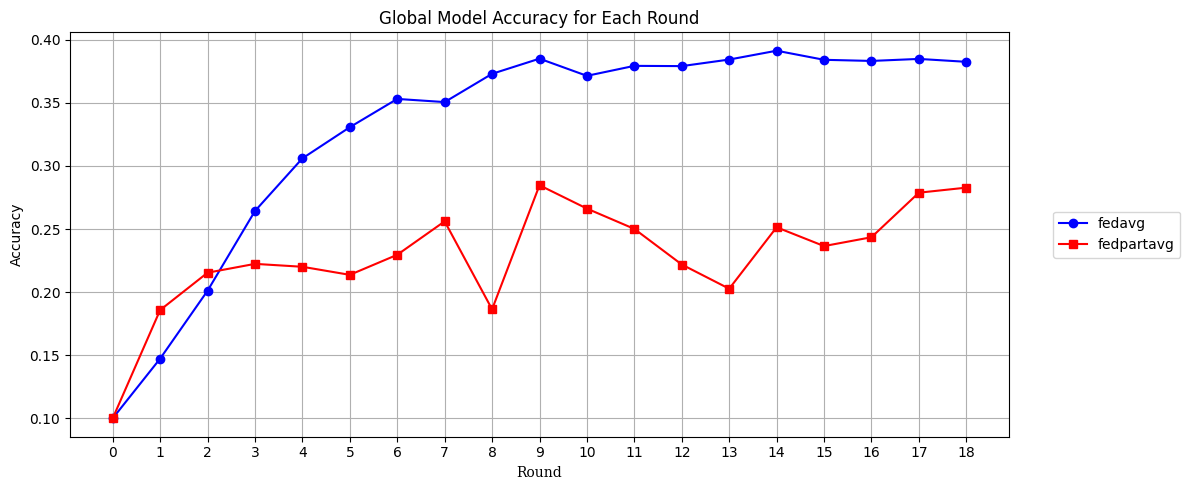

In [6]:
plot_accuracy_per_round(baseline_results)

From the per round accuracy and loss plots we can clearly see that the original FedAvg strategy presents far better performance in both. This is attributed to the fact that though FedPart can help minimizing the layer mismatch problem, there still has to be some form of synchronisation across layers especially if the clients data is not IID. Since FedPart does not incorporate any form of cross layer synchronisation of weights beyond its warm up rounds, it results in really different layers when they are aggregated from clients which cannot collaborate with each other hence worsening the layer mismatch problem in this case.

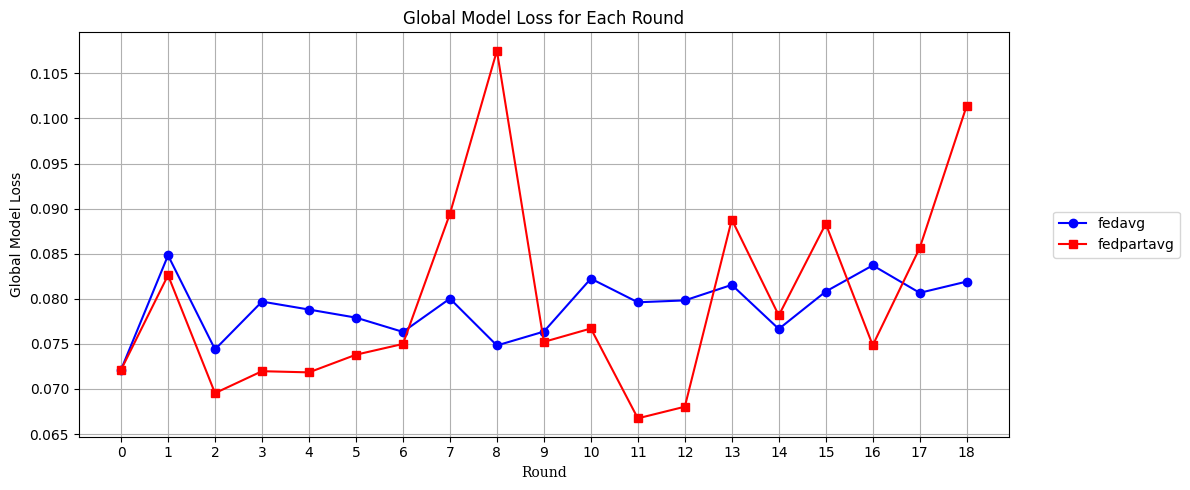

In [7]:
plot_loss_per_round(baseline_results)

### Parameter Differences Across Rounds













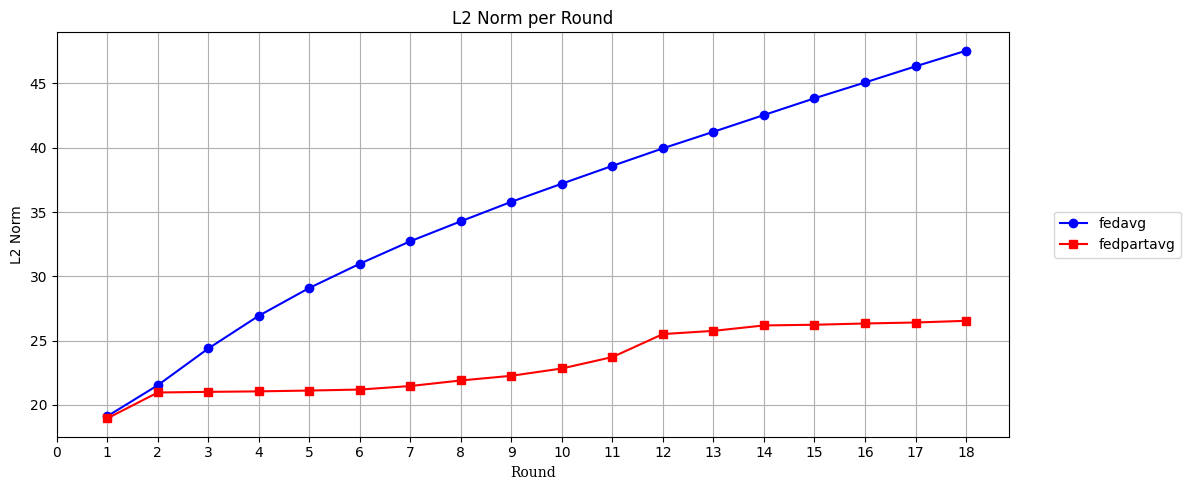

In [8]:
plot_l2_norm_per_round(baseline_results)

The L2 norm further supports the issue of FedPart caused layer mismatch. We can see that the L2 norm across rounds is much smaller for FedPartAvg since the client model layers are so different that they work against each other resulting in a much smaller L2 norm change hence a decrease in feature learning. Meanwhile since FedAvg collects and shares all the layers in each round, it has more opportunities to synchronize the layers across clients then FedPartAvg resulting in a better L2 norm change.

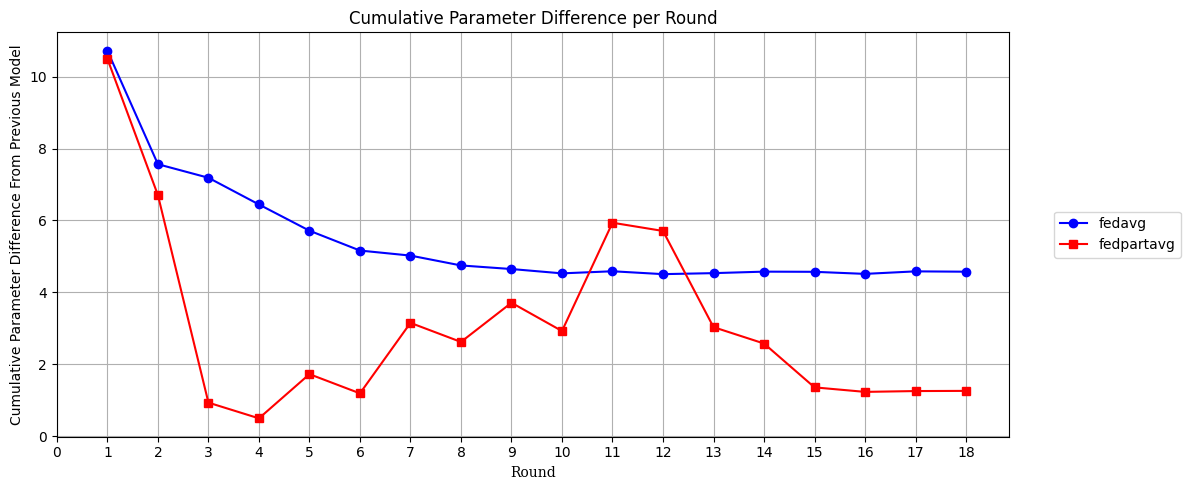

In [9]:
plot_parameter_difference_per_round(baseline_results)

Meanwhile the behaviour of FedAvg is similar to what it has presented in the Ideal Setting experiments, FedPartAvg exhibits a much more fluctuating behaviour in both parameter difference and cosine similarity to previous round's model across the training rounds. The increase in parameter difference and decrease in cosine similarity mainly caused by the more deeper layer of the network which are greatly effected by the the different distribution of data hence changing the model layers much more drastically in each round as there is no synchronisation across layers.

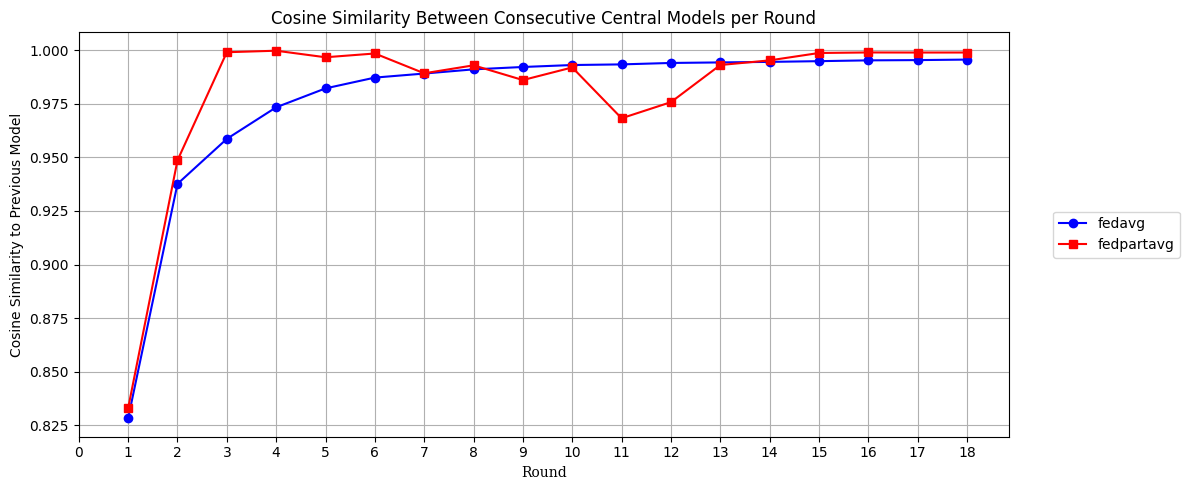

In [10]:
plot_cosine_similarity_per_round(baseline_results)

### Save the results to pickle files

In [16]:
pickle.dump(baseline_results, open(f"{experiment_type}_baseline.pkl", 'wb'))
all_results.update(baseline_results)

# Both Momentum

## FedAvgMom2

Strategies in this section aim to utilize both first and second momentum from the client optimizer states during the result aggregation from client in order to improve the convergence speed of the training process while decreasing the communication cost. The server uses the cosine similarity to weight the parameters and the collected optimizer states from the clients. This section presents 6 different weighting strategies using the cosine similarity of the first and second momentum, including the original approach presented in the previous project.

### FedAvgMom2 Original Weighting

In [7]:
from src.Fedmom2.FedAvg.client import get_fedavg_mom2_client_fn
from src.Fedmom2.FedAvg.strategy import FedAvgMom2

In [8]:
fedavg_mom2_original_client_fn = get_fedavg_mom2_client_fn(load_datasets)
client = ClientApp(client_fn=fedavg_mom2_original_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
fedavg_mom2_strategy_original= FedAvgMom2(evaluate_fn=evaluate_fn, aggregate_mode="original")

def fedavg_mom2_original_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=fedavg_mom2_strategy_original,
    )

server = ServerApp(server_fn=fedavg_mom2_original_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]


(ClientAppActor pid=48922) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=48922)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=48922) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=48922) [Client 3] initialized
(ClientAppActor pid=48922) [Client 3] fit
(ClientAppActor pid=48922) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=48922) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=48922) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=48922) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=48922) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=48922) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=48922) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=48922) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=48922) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=48922) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=48922) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=48922) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=48922) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=48922) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=48922) Layer 14 (fc7.weight) is trai

(ClientAppActor pid=48921) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=48921)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
(ClientAppActor pid=48921) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 5x across cluster]


(ClientAppActor pid=48921) [Client 0] initialized
(ClientAppActor pid=48921) [Client 0] evaluate
(ClientAppActor pid=48921) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48921) [Client 4] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=48921) Epoch 8: train loss 0.037306966954725414, accuracy 0.5564056405640564
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48924) [Client 4] fit
(ClientAppActor pid=48924) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=48924) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=48924) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=48924) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=48924) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=48924) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=48924) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=48924) Layer 7 (fc2

(ClientAppActor pid=48921) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=48921)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=48921) [Client 5] initialized [repeated 11x across cluster]
(ClientAppActor pid=48923) [Client 4] evaluate [repeated 5x across cluster]
(ClientAppActor pid=48922) Epoch 1: train loss 0.12484614217098933, accuracy 0.23117311731173118
(ClientAppActor pid=48921) [Client 5] fit [repeated 5x across cluster]
(ClientAppActor pid=48921) Layer 15 (fc7.bias) is trainable [repeated 80x across cluster]
(ClientAppActor pid=48921) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=48921) training network... [repeated 5x across cluster]
(ClientAppActor pid=48922) Epoch 3: train loss 0.056230212989026564, accuracy 0.31218121812181215 [repeated 12x across cluster]
(ClientAppActor pid=48921) Epoch 4: train loss 0.04824392133169692, accuracy 0.43174317431743175 [repeated 11x across cluster]
(ClientAppActor pid=48925) Epoch 6: train loss 0.04974214067268858, accuracy 0.4150292485375731 [repeated 7x across cluster]
(ClientAppActor pid=48921) Epoch 

(ClientAppActor pid=48922) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=48922)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=48923) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=48923)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=48922) [Client 3] initialized
(ClientAppActor pid=48922) [Client 3] evaluate
(ClientAppActor pid=48921) Epoch 8: train loss 0.044372781740091884, accuracy 0.484998499849985 [repeated 6x across cluster]
(ClientAppActor pid=48921) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48921) [Client 5] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48922) [Client 0] fit
(ClientAppActor pid=48922) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=48922) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=48922) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48922) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48922) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48922) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48922) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48922)

(ClientAppActor pid=48923) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=48923)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=48923) [Client 5] initialized
(ClientAppActor pid=48923) [Client 5] evaluate
(ClientAppActor pid=48924) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48924) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=48924) Epoch 8: train loss 0.04766906125031181, accuracy 0.4515451545154515 [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48920) [Client 3] fit
(ClientAppActor pid=48920) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=48920) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=48920) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48920) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48920) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48920) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48920) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48920)

(ClientAppActor pid=48921) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 10x across cluster]
(ClientAppActor pid=48921)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 10x across cluster]


(ClientAppActor pid=48921) [Client 4] initialized [repeated 10x across cluster]
(ClientAppActor pid=48924) [Client 0] evaluate [repeated 5x across cluster]
(ClientAppActor pid=48920) Epoch 1: train loss 0.04781187376459547, accuracy 0.4458445844584458
(ClientAppActor pid=48925) [Client 1] fit [repeated 5x across cluster]
(ClientAppActor pid=48925) Layer 1 (conv1.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=48925) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=48925) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=48925) training network... [repeated 5x across cluster]
(ClientAppActor pid=48925) [Client 1] initialized
(ClientAppActor pid=48920) Epoch 2: train loss 0.04754897931514114, accuracy 0.4458445844584458 [repeated 6x across cluster]
(ClientAppActor pid=48923) Epoch 3: train loss 0.046874687795413, accuracy 0.4584458445844585 [repeated 6x across cluster]
(ClientAppActor pid=48920) E

(ClientAppActor pid=48921) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=48921)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


(ClientAppActor pid=48921) [Client 2] initialized
(ClientAppActor pid=48921) [Client 2] evaluate
(ClientAppActor pid=48925) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48925) Epoch 8: train loss 0.042582661499053764, accuracy 0.5062246887655617 [repeated 5x across cluster]
(ClientAppActor pid=48925) [Client 1] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48920) [Client 1] fit
(ClientAppActor pid=48924) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48924) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48924) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=48924) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=48924) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48924) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48924) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48924

(ClientAppActor pid=48921) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 8x across cluster]
(ClientAppActor pid=48921)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 8x across cluster]


(ClientAppActor pid=48925) Epoch 1: train loss 0.04703887604107701, accuracy 0.4533453345334533
(ClientAppActor pid=48923) [Client 3] fit [repeated 5x across cluster]
(ClientAppActor pid=48923) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=48923) Layer 3 (conv2.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=48923) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=48923) [Client 3] initialized [repeated 4x across cluster]
(ClientAppActor pid=48923) training network... [repeated 5x across cluster]
(ClientAppActor pid=48925) Epoch 3: train loss 0.0443248265575726, accuracy 0.4894989498949895 [repeated 12x across cluster]
(ClientAppActor pid=48925) Epoch 6: train loss 0.04349268668412518, accuracy 0.49834983498349833 [repeated 18x across cluster]
(ClientAppActor pid=48922) Epoch 7: train loss 0.04436345377192963, accuracy 0.49017549122543874 [repeated 11x across cluster]
(ClientAppActor pid=4892

(ClientAppActor pid=48924) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=48924)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48921) [Client 5] fit
(ClientAppActor pid=48921) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48921) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48921) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=48921) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=48921) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48921) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48921) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48921) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48921) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48921) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=48921) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=48921) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=48921) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=48921) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=48921) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=48922) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48922)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48922) [Client 5] initialized
(ClientAppActor pid=48922) [Client 5] evaluate
(ClientAppActor pid=48922) Epoch 8: train loss 0.04370265650098259, accuracy 0.4891989198919892 [repeated 11x across cluster]
(ClientAppActor pid=48922) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48922) [Client 3] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48920) [Client 2] fit
(ClientAppActor pid=48920) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48920) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48920) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48920) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48920) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=48920) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=48920) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48920

(ClientAppActor pid=48920) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48920)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48920) [Client 5] initialized
(ClientAppActor pid=48920) [Client 5] evaluate
(ClientAppActor pid=48922) Epoch 8: train loss 0.035522834177386324, accuracy 0.59000900090009 [repeated 11x across cluster]
(ClientAppActor pid=48922) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48922) [Client 3] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]


(ClientAppActor pid=48920) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=48920)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=48920) [Client 5] fit
(ClientAppActor pid=48920) [Client 5] initialized [repeated 6x across cluster]
(ClientAppActor pid=48922) [Client 1] evaluate [repeated 5x across cluster]
(ClientAppActor pid=48921) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48921) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48921) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48921) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48921) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=48921) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=48921) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48921) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48921) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48921) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=48921) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=48921) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=48921) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=48921) Layer 13 (fc5.bia

(ClientAppActor pid=48920) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=48920)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=48920) [Client 1] initialized
(ClientAppActor pid=48920) [Client 1] evaluate
(ClientAppActor pid=48922) Epoch 8: train loss 0.03001868755219847, accuracy 0.6614669266536674 [repeated 5x across cluster]
(ClientAppActor pid=48922) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48922) [Client 1] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48925) [Client 2] fit
(ClientAppActor pid=48925) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48925) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48925) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48925) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48925) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48925) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48925) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=48925) La

(ClientAppActor pid=48922) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=48922)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=48922) [Client 1] initialized [repeated 11x across cluster]
(ClientAppActor pid=48923) [Client 2] evaluate [repeated 5x across cluster]
(ClientAppActor pid=48925) Epoch 1: train loss 0.03808859905393997, accuracy 0.5601560156015601
(ClientAppActor pid=48922) [Client 1] fit [repeated 5x across cluster]
(ClientAppActor pid=48922) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=48922) Layer 7 (fc2.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=48922) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=48922) training network... [repeated 5x across cluster]
(ClientAppActor pid=48921) Epoch 2: train loss 0.036640700602223845, accuracy 0.5736573657365737 [repeated 8x across cluster]
(ClientAppActor pid=48925) Epoch 4: train loss 0.03621993793977691, accuracy 0.581008100810081 [repeated 10x across cluster]
(ClientAppActor pid=48921) Epoch 5: train loss 0.03546011737614038, accuracy 

(ClientAppActor pid=48920) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=48920)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=48921) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=48921)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=48920) [Client 3] initialized
(ClientAppActor pid=48920) [Client 3] evaluate
(ClientAppActor pid=48922) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48922) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=48922) Epoch 8: train loss 0.032782699127720805, accuracy 0.623968801559922 [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48920) [Client 2] fit
(ClientAppActor pid=48925) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48925) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48925) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48925) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48925) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48925) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48925) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=48925) La

(ClientAppActor pid=48921) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=48921)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=48921) [Client 4] initialized
(ClientAppActor pid=48921) [Client 4] evaluate
(ClientAppActor pid=48922) Epoch 8: train loss 0.03396922459017218, accuracy 0.6122112211221122 [repeated 5x across cluster]
(ClientAppActor pid=48922) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48922) [Client 5] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48922) [Client 0] fit
(ClientAppActor pid=48922) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48922) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48922) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48922) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48922) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48922) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48922) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48922) Layer

(ClientAppActor pid=48920) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48920)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48920) [Client 5] initialized
(ClientAppActor pid=48920) [Client 5] evaluate
(ClientAppActor pid=48921) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48921) [Client 3] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=48921) Epoch 8: train loss 0.0391683371672214, accuracy 0.5813081308130813 [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48924) [Client 5] fit
(ClientAppActor pid=48924) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48924) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48924) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48924) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48924) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48924) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48924) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48924) Layer 

(ClientAppActor pid=48922) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48922)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48922) [Client 4] initialized
(ClientAppActor pid=48922) [Client 4] evaluate
(ClientAppActor pid=48923) Epoch 8: train loss 0.03641965529277022, accuracy 0.6077107710771077 [repeated 5x across cluster]
(ClientAppActor pid=48923) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48923) [Client 4] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48922) [Client 5] fit
(ClientAppActor pid=48922) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48922) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48922) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48922) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48922) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48922) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48922) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48922) Layer

(ClientAppActor pid=48921) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48921)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48921) [Client 1] initialized
(ClientAppActor pid=48921) [Client 1] evaluate
(ClientAppActor pid=48921) Epoch 8: train loss 0.038108572913761296, accuracy 0.5846084608460846 [repeated 11x across cluster]
(ClientAppActor pid=48921) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48921) [Client 3] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48924) [Client 4] fit
(ClientAppActor pid=48924) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48924) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48924) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48924) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48924) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48924) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48924) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48924) Lay

(ClientAppActor pid=48921) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48921)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48921) [Client 5] initialized
(ClientAppActor pid=48921) [Client 5] evaluate
(ClientAppActor pid=48925) Epoch 8: train loss 0.03648306962752035, accuracy 0.5943594359435943 [repeated 11x across cluster]
(ClientAppActor pid=48925) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48925) [Client 2] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48920) [Client 5] fit
(ClientAppActor pid=48920) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48920) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48920) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48920) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48920) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48920) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48920) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48920) Laye

(ClientAppActor pid=48925) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48925)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48925) [Client 3] initialized
(ClientAppActor pid=48925) [Client 3] evaluate
(ClientAppActor pid=48925) Epoch 8: train loss 0.03606203074144809, accuracy 0.5909090909090909 [repeated 11x across cluster]
(ClientAppActor pid=48925) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48925) [Client 3] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48920) [Client 1] fit
(ClientAppActor pid=48920) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48920) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48920) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48920) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48920) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48920) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48920) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48920) Laye

(ClientAppActor pid=48920) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48920)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48920) [Client 3] initialized
(ClientAppActor pid=48920) [Client 3] evaluate
(ClientAppActor pid=48922) Epoch 8: train loss 0.03545210264375036, accuracy 0.591959195919592 [repeated 11x across cluster]
(ClientAppActor pid=48922) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48922) [Client 3] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48921) [Client 4] fit
(ClientAppActor pid=48923) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48923) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48923) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48923) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48923) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48923) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48923) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48923) Layer

(ClientAppActor pid=48922) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48922)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48922) [Client 0] initialized
(ClientAppActor pid=48922) [Client 0] evaluate
(ClientAppActor pid=48922) Epoch 8: train loss 0.03489786818303929, accuracy 0.6058197090145493 [repeated 11x across cluster]
(ClientAppActor pid=48922) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48922) [Client 0] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48922) [Client 5] fit
(ClientAppActor pid=48922) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48922) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48922) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48922) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48922) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48922) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48922) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48922) Laye

(ClientAppActor pid=48921) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=48921)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=48921) [Client 0] initialized [repeated 11x across cluster]
(ClientAppActor pid=48925) [Client 2] evaluate [repeated 5x across cluster]
(ClientAppActor pid=48922) Epoch 1: train loss 0.03536394854547596, accuracy 0.5955595559555955
(ClientAppActor pid=48921) [Client 0] fit [repeated 5x across cluster]
(ClientAppActor pid=48921) Layer 13 (fc5.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=48921) Layer 15 (fc7.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=48921) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=48921) training network... [repeated 5x across cluster]
(ClientAppActor pid=48921) Epoch 2: train loss 0.035129359695745835, accuracy 0.6043197840107994 [repeated 11x across cluster]
(ClientAppActor pid=48925) Epoch 4: train loss 0.03442769314553907, accuracy 0.6066606660666066 [repeated 7x across cluster]
(ClientAppActor pid=48925) Epoch 6: train loss 0.03437936090507416, accurac

(ClientAppActor pid=48923) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=48923)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=48925) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=48925)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=48923) [Client 4] initialized
(ClientAppActor pid=48923) [Client 4] evaluate
(ClientAppActor pid=48921) Epoch 8: train loss 0.034728509295875384, accuracy 0.6074696265186741 [repeated 5x across cluster]
(ClientAppActor pid=48921) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48921) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=48924) [Client 1] initialized [repeated 5x across cluster]
(ClientAppActor pid=48924) [Client 1] evaluate [repeated 5x across cluster]


(ClientAppActor pid=48924) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=48924)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


In [32]:
fedavg_mom2_original_results=fedavg_mom2_strategy_original.get_results()
fedavg_mom2_results['fedavg_mom2_original'] = fedavg_mom2_original_results

3

### FedAvgMom2 Softmax Weighting

In [10]:
fedavg_mom2_softmax_client_fn = get_fedavg_mom2_client_fn(load_datasets)
client = ClientApp(client_fn=fedavg_mom2_softmax_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
fedavg_mom2_strategy_softmax= FedAvgMom2(evaluate_fn=evaluate_fn, aggregate_mode="softmax")

def fedavg_mom2_softmax_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=fedavg_mom2_strategy_softmax,
    )

server = ServerApp(server_fn=fedavg_mom2_softmax_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64989) [Client 5] initialized
(ClientAppActor pid=64989) [Client 5] fit
(ClientAppActor pid=64989) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=64989) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=64989) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=64989) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=64989) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=64989) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=64989) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=64989) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=64989) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=64989) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=64989) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=64989) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=64989) Layer 12 (fc5.weight) 

(ClientAppActor pid=64989) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=64989)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=64989) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=64994) 
(ClientAppActor pid=64989) Epoch 1: train loss 0.06663725950536949, accuracy 0.17461746174617462
(ClientAppActor pid=64994) [Client 1] initialized [repeated 5x across cluster]
(ClientAppActor pid=64994) [Client 1] fit [repeated 5x across cluster]
(ClientAppActor pid=64994) Layer 15 (fc7.bias) is trainable [repeated 80x across cluster]
(ClientAppActor pid=64994) training network... [repeated 5x across cluster]
(ClientAppActor pid=64994) Epoch 2: train loss 0.059952276872698114, accuracy 0.22978851057447128 [repeated 11x across cluster]
(ClientAppActor pid=64989) Epoch 4: train loss 0.05202916295829565, accuracy 0.3616861686168617 [repeated 7x across cluster]
(ClientAppActor pid=64994) Epoch 5: train loss 0.049675475429948594, accuracy 0.39883005849707515 [repeated 11x across cluster]
(ClientAppActor pid=64992) Epoch 7: train loss 0.042843162414371666, accuracy 0.4888988898889889 [repeated 7x across cluster]
(ClientAppActor pid=64992) Epoch 8: train loss 0.039

(ClientAppActor pid=64991) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=64991)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
(ClientAppActor pid=64994) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 5x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64993) [Client 5] fit
(ClientAppActor pid=64993) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=64993) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=64993) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=64993) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=64993) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=64993) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=64993) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=64993) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=64993) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=64993) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=64993) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=64993) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=64993) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=64993) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=64993) Laye

(ClientAppActor pid=64994) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=64994)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64995) [Client 1] fit
(ClientAppActor pid=64995) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=64995) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=64995) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=64995) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=64995) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=64995) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=64995) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=64995) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=64995) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=64995) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=64995) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=64995) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=64995) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=64995) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=64995) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=64991) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=64991)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64991) [Client 0] fit
(ClientAppActor pid=64994) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=64994) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=64994) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=64994) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=64994) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=64994) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=64994) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=64994) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=64994) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=64994) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=64994) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=64994) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=64994) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=64994) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=64994) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=64992) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=64992)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=64992) [Client 4] initialized
(ClientAppActor pid=64992) [Client 4] evaluate
(ClientAppActor pid=64992) Epoch 8: train loss 0.06884750649623601, accuracy 0.17416741674167416 [repeated 11x across cluster]
(ClientAppActor pid=64989) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=64989) [Client 1] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64991) [Client 0] fit
(ClientAppActor pid=64991) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=64991) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=64991) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=64991) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=64991) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=64991) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=64991) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=6499

(ClientAppActor pid=64989) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=64989)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=64992) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=64992) [Client 5] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64991) [Client 3] fit
(ClientAppActor pid=64991) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=64991) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=64991) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=64991) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=64991) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=64991) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=64991) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=64991) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=64991) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=64991) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=64991) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid

(ClientAppActor pid=64989) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=64989)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64995) [Client 2] fit
(ClientAppActor pid=64995) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=64995) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=64995) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=64995) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=64995) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=64995) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=64995) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=64995) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=64995) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=64995) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=64995) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=64995) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=64995) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=64995) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=64995) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=64991) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=64991)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=64995) [Client 4] initialized
(ClientAppActor pid=64995) [Client 4] evaluate
(ClientAppActor pid=64993) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=64993) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=64993) Epoch 8: train loss 0.05751881403455996, accuracy 0.3100344982750862 [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64993) [Client 3] fit
(ClientAppActor pid=64993) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=64993) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=64993) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=64993) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=64993) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=64993) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=64993) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=64993)

(ClientAppActor pid=64989) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=64989)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64991) [Client 3] fit
(ClientAppActor pid=64991) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=64991) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=64991) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=64991) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=64991) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=64991) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=64991) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=64991) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=64991) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=64991) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=64991) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=64991) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=64991) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=64991) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=64991) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=64993) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=64993)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64994) [Client 1] fit
(ClientAppActor pid=64994) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=64994) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=64994) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=64994) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=64994) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=64994) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=64994) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=64994) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=64994) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=64994) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=64994) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=64994) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=64994) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=64994) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=64994) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=64991) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 8x across cluster]
(ClientAppActor pid=64991)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 8x across cluster]


(ClientAppActor pid=64994) Epoch 1: train loss 0.053928055397767224, accuracy 0.3574321283935803
(ClientAppActor pid=64992) [Client 0] fit [repeated 5x across cluster]
(ClientAppActor pid=64992) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=64992) Layer 7 (fc2.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=64992) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=64992) training network... [repeated 5x across cluster]
(ClientAppActor pid=64992) [Client 0] initialized [repeated 3x across cluster]
(ClientAppActor pid=64994) Epoch 3: train loss 0.05366187655659331, accuracy 0.35968201589920507 [repeated 12x across cluster]
(ClientAppActor pid=64994) Epoch 5: train loss 0.05346858633750022, accuracy 0.36538173091345433 [repeated 12x across cluster]
(ClientAppActor pid=64994) Epoch 7: train loss 0.053306624344733766, accuracy 0.3631318434078296 [repeated 12x across cluster]
(ClientAppActor pid=649

(ClientAppActor pid=64989) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=64989)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64993) [Client 2] fit
(ClientAppActor pid=64993) [Client 2] initialized [repeated 6x across cluster]
(ClientAppActor pid=64995) [Client 0] evaluate [repeated 5x across cluster]
(ClientAppActor pid=64991) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=64991) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=64991) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=64991) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=64991) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=64991) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=64991) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=64991) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=64991) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=64991) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=64991) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=64991) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=64991) L

(ClientAppActor pid=64993) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=64993)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=64993) Epoch 1: train loss 0.05385500777422255, accuracy 0.3568856885688569
(ClientAppActor pid=64994) [Client 4] fit [repeated 5x across cluster]
(ClientAppActor pid=64994) [Client 4] initialized [repeated 5x across cluster]
(ClientAppActor pid=64994) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=64994) Layer 9 (fc3.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=64994) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=64994) training network... [repeated 5x across cluster]
(ClientAppActor pid=64989) Epoch 3: train loss 0.052793404217636196, accuracy 0.37218721872187216 [repeated 12x across cluster]
(ClientAppActor pid=64995) Epoch 5: train loss 0.05279133622750396, accuracy 0.3727313634318284 [repeated 12x across cluster]
(ClientAppActor pid=64989) Epoch 7: train loss 0.05243240350937293, accuracy 0.3766876687668767 [repeated 12x across cluster]
(ClientAppActor pid=64989

(ClientAppActor pid=64989) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=64989)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64993) [Client 1] fit
(ClientAppActor pid=64993) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=64993) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=64993) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=64993) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=64993) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=64993) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=64993) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=64993) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=64993) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=64993) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=64993) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=64993) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=64993) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=64993) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=64993) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=64989) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=64989)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64994) [Client 0] fit
(ClientAppActor pid=64994) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=64994) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=64994) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=64994) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=64994) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=64994) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=64994) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=64994) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=64994) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=64994) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=64994) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=64994) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=64994) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=64994) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=64994) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=64989) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=64989)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64995) [Client 1] fit
(ClientAppActor pid=64989) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=64989) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=64989) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=64989) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=64989) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=64989) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=64989) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=64989) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=64989) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=64989) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=64989) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=64989) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=64989) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=64989) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=64989) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=64992) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=64992)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=64992) [Client 2] initialized
(ClientAppActor pid=64992) [Client 2] evaluate
(ClientAppActor pid=64993) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=64992) [Client 3] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=64993) Epoch 8: train loss 0.051355822251574826, accuracy 0.3886888688868887 [repeated 2x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64992) [Client 3] fit
(ClientAppActor pid=64991) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=64991) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=64991) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=64991) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=64991) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=64991) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=64991) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=64991) Laye

(ClientAppActor pid=64993) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=64993)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64994) [Client 5] fit
(ClientAppActor pid=64994) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=64994) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=64994) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=64994) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=64994) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=64994) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=64994) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=64994) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=64994) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=64994) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=64994) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=64994) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=64994) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=64994) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=64994) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=64994) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=64994)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64993) [Client 1] fit
(ClientAppActor pid=64993) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=64993) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=64993) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=64993) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=64993) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=64993) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=64993) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=64993) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=64993) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=64993) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=64993) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=64993) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=64993) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=64993) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=64993) Layer 14 (fc7.weight) is trainable
(ClientAppA

(ClientAppActor pid=64989) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=64989)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64989) [Client 1] fit
(ClientAppActor pid=64989) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=64989) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=64989) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=64989) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=64989) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=64989) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=64989) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=64989) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=64989) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=64989) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=64989) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=64989) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=64989) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=64989) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=64989) Layer 14 (fc7.weight) is trainable
(ClientAppA

(ClientAppActor pid=64992) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=64992)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=64992) [Client 1] initialized
(ClientAppActor pid=64992) [Client 1] evaluate
(ClientAppActor pid=64991) Epoch 8: train loss 0.05057456709406521, accuracy 0.3991899189918992 [repeated 8x across cluster]
(ClientAppActor pid=64991) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=64991) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=64993) [Client 4] initialized [repeated 5x across cluster]
(ClientAppActor pid=64993) [Client 4] evaluate [repeated 5x across cluster]


(ClientAppActor pid=64993) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=64993)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [33]:
fedavg_mom2_softmax_results=fedavg_mom2_strategy_softmax.get_results()
fedavg_mom2_results['fedavg_mom2_softmax'] = fedavg_mom2_softmax_results

3

### FedAvgMom2 Sigmoid Weighting

In [12]:
fedavg_mom2_sigmoid_client_fn = get_fedavg_mom2_client_fn(load_datasets)
client = ClientApp(client_fn=fedavg_mom2_sigmoid_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
fedavg_mom2_strategy_sigmoid= FedAvgMom2(evaluate_fn=evaluate_fn, aggregate_mode="sigmoid")

def fedavg_mom2_sigmoid_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=fedavg_mom2_strategy_sigmoid,
    )

server = ServerApp(server_fn=fedavg_mom2_sigmoid_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]


(ClientAppActor pid=80350) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80350)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=80350) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=80350) [Client 2] initialized
(ClientAppActor pid=80350) [Client 2] fit
(ClientAppActor pid=80350) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=80350) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=80350) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=80350) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=80350) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=80350) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=80350) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=80350) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=80350) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=80350) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=80350) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=80350) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=80350) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=80350) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=80350) Layer 14 (fc7.weight) is trai

(ClientAppActor pid=80349) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=80349)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]
(ClientAppActor pid=80349) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.
(ClientAppActor pid=80346) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.
(ClientAppActor pid=80346) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActo

(ClientAppActor pid=80346) [Client 4] initialized [repeated 2x across cluster]
(ClientAppActor pid=80346) [Client 4] evaluate [repeated 2x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80346) [Client 3] fit
(ClientAppActor pid=80346) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=80346) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=80346) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=80346) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=80346) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=80346) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=80346) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=80346) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=80346) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=80346) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=80346) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=80346) Layer 11 (fc4.bias) is trainabl

(ClientAppActor pid=80347) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 2x across cluster]
(ClientAppActor pid=80345) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 9x across cluster]
(ClientAppActor pid=80345)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 9x across cluster]


  Evaluation results - Loss: 0.0567, Accuracy: 0.3128
(ClientAppActor pid=80350) [Client 2] initialized
(ClientAppActor pid=80350) [Client 2] evaluate
(ClientAppActor pid=80345) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=80345) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=80345) Epoch 8: train loss 0.05015257510964402, accuracy 0.39943002849857506 [repeated 4x across cluster]


(ClientAppActor pid=80348) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.
(ClientAppActor pid=80350) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80350)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=80346) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80346)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80349) [Client 3] fit
(ClientAppActor pid=80349) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=80349) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=80349) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80349) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80349) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80349) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80349) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80349) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80349) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80349) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80349) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=80349) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=80349) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=80349) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=80349) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=80345) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 10x across cluster]
(ClientAppActor pid=80345)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 10x across cluster]


(ClientAppActor pid=80347) Epoch 1: train loss 0.0565318785561996, accuracy 0.3224838758062097
(ClientAppActor pid=80345) [Client 4] fit [repeated 5x across cluster]
(ClientAppActor pid=80345) Layer 1 (conv1.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=80345) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=80345) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=80345) training network... [repeated 5x across cluster]
(ClientAppActor pid=80345) [Client 4] initialized [repeated 5x across cluster]
(ClientAppActor pid=80347) Epoch 3: train loss 0.05590434476355482, accuracy 0.3334333283335833 [repeated 12x across cluster]
(ClientAppActor pid=80346) Epoch 5: train loss 0.05548552203528916, accuracy 0.33723372337233726 [repeated 12x across cluster]
(ClientAppActor pid=80349) Epoch 7: train loss 0.055191457969020016, accuracy 0.3327332733273327 [repeated 12x across cluster]
(ClientAppActor pid=8034

(ClientAppActor pid=80348) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80348)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=80348) [Client 4] initialized
(ClientAppActor pid=80348) [Client 4] evaluate
(ClientAppActor pid=80345) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=80345) [Client 4] get_parameters [repeated 5x across cluster]


(ClientAppActor pid=80347) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80347)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80350) [Client 5] fit
(ClientAppActor pid=80350) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=80350) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=80350) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80350) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80350) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80350) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80350) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80350) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80350) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80350) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80350) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=80350) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=80350) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=80350) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=80350) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=80346) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=80346)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=80346) [Client 0] initialized
(ClientAppActor pid=80346) [Client 0] evaluate
(ClientAppActor pid=80346) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=80346) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=80346) Epoch 8: train loss 0.05474198356246204, accuracy 0.3481325933703315
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80345) [Client 3] fit
(ClientAppActor pid=80345) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80345) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80345) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=80345) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=80345) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80345) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80345) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80345) Layer 7 (fc2.bias) is frozen

(ClientAppActor pid=80346) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80346)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80345) [Client 2] fit
(ClientAppActor pid=80345) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80345) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80345) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=80345) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=80345) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80345) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80345) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80345) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80345) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80345) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80345) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=80345) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=80345) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=80345) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=80345) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=80349) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80349)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80349) [Client 1] fit
(ClientAppActor pid=80349) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80349) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80349) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80349) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80349) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=80349) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=80349) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80349) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80349) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80349) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80349) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=80349) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=80349) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=80349) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=80349) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=80350) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80350)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80345) [Client 3] fit
(ClientAppActor pid=80346) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80346) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80346) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80346) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80346) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=80346) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=80346) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80346) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80346) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80346) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80346) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=80346) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=80346) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=80346) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=80346) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=80349) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80349)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80350) [Client 3] fit
(ClientAppActor pid=80350) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80350) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80350) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80350) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80350) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80350) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80350) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=80350) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=80350) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80350) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80350) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=80350) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=80350) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=80350) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=80350) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=80345) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80345)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80347) [Client 3] fit
(ClientAppActor pid=80347) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80347) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80347) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80347) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80347) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80347) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80347) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=80347) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=80347) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80347) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80347) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=80347) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=80347) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=80347) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=80347) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=80345) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 7x across cluster]
(ClientAppActor pid=80345)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 7x across cluster]


(ClientAppActor pid=80347) Epoch 1: train loss 0.0459402067826526, accuracy 0.46264626462646263
(ClientAppActor pid=80346) [Client 4] fit [repeated 5x across cluster]
(ClientAppActor pid=80346) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=80346) Layer 7 (fc2.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=80346) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=80346) training network... [repeated 5x across cluster]
(ClientAppActor pid=80346) [Client 4] initialized [repeated 4x across cluster]
(ClientAppActor pid=80348) Epoch 2: train loss 0.045430637196381456, accuracy 0.47104710471047107 [repeated 7x across cluster]
(ClientAppActor pid=80347) Epoch 4: train loss 0.0452821645298914, accuracy 0.46954695469546953 [repeated 11x across cluster]
(ClientAppActor pid=80347) Epoch 6: train loss 0.044861449722838835, accuracy 0.47254725472547254 [repeated 12x across cluster]
(ClientAppActor pid=8035

(ClientAppActor pid=80348) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=80348)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=80348) [Client 0] initialized
(ClientAppActor pid=80348) [Client 0] evaluate
(ClientAppActor pid=80346) Epoch 8: train loss 0.043209470895686525, accuracy 0.4960996099609961 [repeated 6x across cluster]
(ClientAppActor pid=80350) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=80350) [Client 5] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80348) [Client 1] fit
(ClientAppActor pid=80348) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80348) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80348) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80348) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80348) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80348) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80348) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80348) Laye

(ClientAppActor pid=80345) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 10x across cluster]
(ClientAppActor pid=80345)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 10x across cluster]


(ClientAppActor pid=80348) Epoch 1: train loss 0.04540373232297781, accuracy 0.47922603869806507
(ClientAppActor pid=80349) [Client 0] fit [repeated 5x across cluster]
(ClientAppActor pid=80349) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=80349) Layer 9 (fc3.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=80349) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=80349) training network... [repeated 5x across cluster]
(ClientAppActor pid=80349) [Client 0] initialized [repeated 2x across cluster]
(ClientAppActor pid=80347) Epoch 2: train loss 0.0436348240546482, accuracy 0.4912991299129913 [repeated 7x across cluster]
(ClientAppActor pid=80349) Epoch 3: train loss 0.044575982004766146, accuracy 0.47982600869956504 [repeated 10x across cluster]
(ClientAppActor pid=80348) Epoch 5: train loss 0.0440765741759375, accuracy 0.48687565621718915 [repeated 7x across cluster]
(ClientAppActor pid=80347) 

(ClientAppActor pid=80346) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=80346)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80350) [Client 3] fit
(ClientAppActor pid=80350) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80350) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80350) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80350) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80350) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80350) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80350) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80350) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80350) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=80350) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=80350) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=80350) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=80350) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=80350) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=80350) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=80345) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80345)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80347) [Client 2] fit
(ClientAppActor pid=80347) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80347) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80347) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80347) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80347) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80347) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80347) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80347) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80347) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80347) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80347) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=80347) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=80347) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=80347) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=80347) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=80345) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80345)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80345) [Client 5] fit
(ClientAppActor pid=80345) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80345) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80345) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80345) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80345) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80345) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80345) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80345) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80345) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80345) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80345) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=80345) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=80345) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=80345) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=80345) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=80350) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80350)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=80346) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=80346) [Client 0] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80345) [Client 5] fit
(ClientAppActor pid=80345) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80345) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80345) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80345) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80345) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80345) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80345) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80345) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80345) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80345) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80345) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=80345

(ClientAppActor pid=80346) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 7x across cluster]
(ClientAppActor pid=80346)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 7x across cluster]


(ClientAppActor pid=80346) [Client 0] initialized [repeated 7x across cluster]
(ClientAppActor pid=80346) [Client 2] evaluate [repeated 5x across cluster]
(ClientAppActor pid=80345) Epoch 1: train loss 0.04541412450120573, accuracy 0.4768976897689769
(ClientAppActor pid=80347) [Client 1] fit [repeated 5x across cluster]
(ClientAppActor pid=80347) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=80347) Layer 13 (fc5.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=80347) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=80347) training network... [repeated 5x across cluster]
(ClientAppActor pid=80347) [Client 1] initialized [repeated 4x across cluster]
(ClientAppActor pid=80348) Epoch 2: train loss 0.043731941597046096, accuracy 0.4915991599159916 [repeated 7x across cluster]
(ClientAppActor pid=80345) Epoch 4: train loss 0.043470029363466244, accuracy 0.4930993099309931 [repeated 11x across clust

(ClientAppActor pid=80345) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=80345)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80346) [Client 4] fit
(ClientAppActor pid=80346) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80346) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80346) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80346) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80346) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80346) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80346) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80346) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80346) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80346) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80346) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=80346) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=80346) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=80346) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=80346) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=80348) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80348)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=80348) [Client 0] initialized
(ClientAppActor pid=80348) [Client 0] evaluate
(ClientAppActor pid=80350) Epoch 8: train loss 0.042383648712213715, accuracy 0.5036003600360036 [repeated 8x across cluster]
(ClientAppActor pid=80350) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=80350) [Client 5] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80350) [Client 0] fit
(ClientAppActor pid=80350) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80350) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80350) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80350) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80350) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80350) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80350) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80350) Laye

(ClientAppActor pid=80346) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80346)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=80346) [Client 3] initialized
(ClientAppActor pid=80346) [Client 3] evaluate
(ClientAppActor pid=80347) Epoch 8: train loss 0.042907341067368224, accuracy 0.4981998199819982 [repeated 11x across cluster]
(ClientAppActor pid=80347) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=80347) [Client 5] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80345) [Client 5] fit
(ClientAppActor pid=80345) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80345) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80345) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80345) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80345) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80345) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80345) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80345) Lay

(ClientAppActor pid=80346) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80346)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=80346) [Client 2] initialized
(ClientAppActor pid=80346) [Client 2] evaluate
(ClientAppActor pid=80350) Epoch 8: train loss 0.04228386668303404, accuracy 0.5009000900090009 [repeated 6x across cluster]
(ClientAppActor pid=80350) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=80350) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=80350) [Client 0] initialized [repeated 5x across cluster]
(ClientAppActor pid=80350) [Client 0] evaluate [repeated 5x across cluster]


(ClientAppActor pid=80350) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=80350)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


In [34]:
fedavg_mom2_sigmoid_results=fedavg_mom2_strategy_sigmoid.get_results()
fedavg_mom2_results['fedavg_mom2_sigmoid'] = fedavg_mom2_sigmoid_results

3

### FedAvgMom2 Normalized Sigmoid Weighting

In [14]:
fedavg_mom2_normalized_sigmoid_client_fn = get_fedavg_mom2_client_fn(load_datasets)
client = ClientApp(client_fn=fedavg_mom2_normalized_sigmoid_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
fedavg_mom2_strategy_normalized_sigmoid= FedAvgMom2(evaluate_fn=evaluate_fn, aggregate_mode="normalized_sigmoid")

def fedavg_mom2_normalized_sigmoid_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=fedavg_mom2_strategy_normalized_sigmoid,
    )

server = ServerApp(server_fn=fedavg_mom2_normalized_sigmoid_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]


(ClientAppActor pid=96282) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=96282)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=96282) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=96282)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=96282) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=96282) [Client 3] initialized
(ClientAppActor pid=96282) [Client 3] fit
(ClientAppActor pid=96283) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=96283) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=96283) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=96283) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=96283) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=96283) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=96283) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=96283) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=96283) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=96283) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=96283) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=96283) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=96283) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=96283) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=96283) Layer 14 (fc7.weight) is trai

(ClientAppActor pid=96281) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=96281)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
(ClientAppActor pid=96284) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 5x across cluster]


(ClientAppActor pid=96281) [Client 4] initialized
(ClientAppActor pid=96281) [Client 4] evaluate
(ClientAppActor pid=96284) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=96284) [Client 1] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96280) [Client 5] fit
(ClientAppActor pid=96280) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=96280) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=96280) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=96280) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=96280) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=96280) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=96280) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=96280) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=96280) Layer 8 (fc3.weight) is trainable
(ClientAppActor 

(ClientAppActor pid=96281) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=96281)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=96281) [Client 0] initialized
(ClientAppActor pid=96281) [Client 0] evaluate
(ClientAppActor pid=96284) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=96284) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=96284) Epoch 8: train loss 0.055016837396131064, accuracy 0.33268336583170843 [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96284) [Client 2] fit
(ClientAppActor pid=96284) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=96284) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=96284) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=96284) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=96284) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=96284) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=96284) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=9628

(ClientAppActor pid=96285) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=96285)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=96285) [Client 2] initialized
(ClientAppActor pid=96285) [Client 2] evaluate
(ClientAppActor pid=96283) Epoch 8: train loss 0.06435754329207563, accuracy 0.18271827182718273 [repeated 11x across cluster]
(ClientAppActor pid=96283) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=96283) [Client 3] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96281) [Client 4] fit
(ClientAppActor pid=96280) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=96280) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=96280) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=96280) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=96280) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=96280) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=96280) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=9628

(ClientAppActor pid=96284) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=96284)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96280) [Client 1] fit
(ClientAppActor pid=96280) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=96280) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=96280) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=96280) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=96280) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=96280) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=96280) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=96280) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=96280) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=96280) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=96280) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=96280) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=96280) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=96280) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=96280) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=96283) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=96283)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=96281) [Client 4] initialized
(ClientAppActor pid=96281) [Client 4] evaluate
(ClientAppActor pid=96285) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=96285) [Client 2] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96281) [Client 0] fit
(ClientAppActor pid=96281) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=96281) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=96281) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=96281) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=96281) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=96281) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=96281) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=96281) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=96281) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=96281) Layer 9 (f

(ClientAppActor pid=96285) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=96285)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=96285) [Client 4] initialized
(ClientAppActor pid=96285) [Client 4] evaluate
(ClientAppActor pid=96284) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=96284) [Client 3] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=96284) Epoch 8: train loss 0.06015952859166646, accuracy 0.23312331233123312 [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96282) [Client 4] fit
(ClientAppActor pid=96282) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=96282) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=96282) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=96282) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=96282) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=96282) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=96282) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=96282

(ClientAppActor pid=96280) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=96280)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96280) [Client 3] fit
(ClientAppActor pid=96280) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=96280) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=96280) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=96280) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=96280) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=96280) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=96280) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=96280) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=96280) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=96280) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=96280) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=96280) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=96280) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=96280) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=96280) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=96281) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=96281)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


(ClientAppActor pid=96281) [Client 1] initialized
(ClientAppActor pid=96281) [Client 1] evaluate
(ClientAppActor pid=96281) Epoch 8: train loss 0.05509883174301088, accuracy 0.3268826882688269 [repeated 11x across cluster]
(ClientAppActor pid=96281) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=96281) [Client 2] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96280) [Client 0] fit
(ClientAppActor pid=96280) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=96280) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=96280) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=96280) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=96280) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=96280) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=96280) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=96280) L

(ClientAppActor pid=96280) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=96280)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96280) [Client 4] fit
(ClientAppActor pid=96280) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=96280) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=96280) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=96280) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=96280) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=96280) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=96280) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=96280) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=96280) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=96280) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=96280) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=96280) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=96280) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=96280) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=96280) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=96280) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=96280)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96281) [Client 0] fit
(ClientAppActor pid=96281) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=96281) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=96281) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=96281) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=96281) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=96281) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=96281) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=96281) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=96281) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=96281) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=96281) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=96281) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=96281) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=96281) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=96281) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=96283) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=96283)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96281) [Client 5] fit
(ClientAppActor pid=96281) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=96281) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=96281) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=96281) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=96281) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=96281) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=96281) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=96281) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=96281) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=96281) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=96281) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=96281) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=96281) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=96281) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=96281) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=96282) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=96282)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


(ClientAppActor pid=96282) [Client 2] initialized
(ClientAppActor pid=96282) [Client 2] evaluate
(ClientAppActor pid=96285) Epoch 8: train loss 0.05198531705470963, accuracy 0.3809809509524524 [repeated 11x across cluster]
(ClientAppActor pid=96285) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=96285) [Client 0] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96281) [Client 0] fit
(ClientAppActor pid=96281) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=96281) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=96281) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=96281) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=96281) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=96281) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=96281) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=96281) Laye

(ClientAppActor pid=96283) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=96283)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=96282) [Client 5] initialized
(ClientAppActor pid=96282) [Client 5] evaluate
(ClientAppActor pid=96283) Epoch 8: train loss 0.051250993293432585, accuracy 0.38163816381638166 [repeated 11x across cluster]
(ClientAppActor pid=96283) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=96283) [Client 4] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96285) [Client 3] fit
(ClientAppActor pid=96282) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=96282) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=96282) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=96282) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=96282) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=96282) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=96282) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=96282) La

(ClientAppActor pid=96281) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=96281)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=96281) [Client 2] initialized
(ClientAppActor pid=96281) [Client 2] evaluate
(ClientAppActor pid=96280) Epoch 8: train loss 0.051692906144106245, accuracy 0.38203089845507726 [repeated 11x across cluster]
(ClientAppActor pid=96280) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=96280) [Client 1] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96284) [Client 5] fit
(ClientAppActor pid=96284) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=96284) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=96284) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=96284) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=96284) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=96284) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=96284) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=96284) La

(ClientAppActor pid=96280) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=96280)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96280) [Client 2] fit
(ClientAppActor pid=96280) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=96280) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=96280) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=96280) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=96280) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=96280) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=96280) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=96280) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=96280) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=96280) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=96280) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=96280) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=96280) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=96280) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=96280) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=96281) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=96281)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=96281) [Client 0] initialized
(ClientAppActor pid=96281) [Client 0] evaluate
(ClientAppActor pid=96285) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=96285) [Client 4] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96282) [Client 3] fit
(ClientAppActor pid=96282) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=96282) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=96282) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=96282) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=96282) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=96282) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=96282) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=96282) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=96282) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=96282) Layer 9 (fc3.bia

(ClientAppActor pid=96281) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=96281)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=96281) [Client 3] initialized
(ClientAppActor pid=96281) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=96281) [Client 4] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=96281) Epoch 8: train loss 0.05036573577420761, accuracy 0.3940894089408941 [repeated 5x across cluster]
(ClientAppActor pid=96282) [Client 2] evaluate
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96280) [Client 2] fit
(ClientAppActor pid=96280) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=96280) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=96280) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=96280) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=96280) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=96280) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=96280) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=96280) Layer

(ClientAppActor pid=96280) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=96280)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


(ClientAppActor pid=96283) [Client 1] initialized [repeated 5x across cluster]
(ClientAppActor pid=96283) [Client 1] evaluate [repeated 5x across cluster]


(ClientAppActor pid=96283) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=96283)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [35]:
fedavg_mom2_normalized_sigmoid_results=fedavg_mom2_strategy_normalized_sigmoid.get_results()
fedavg_mom2_results['fedavg_mom2_normalized_sigmoid'] = fedavg_mom2_normalized_sigmoid_results

3

### FedAvgMom2 Linear Weighting



In [16]:
fedavg_mom2_linear_client_fn = get_fedavg_mom2_client_fn(load_datasets)
client = ClientApp(client_fn=fedavg_mom2_linear_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
fedavg_mom2_strategy_linear= FedAvgMom2(evaluate_fn=evaluate_fn, aggregate_mode="linear")

def fedavg_mom2_linear_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=fedavg_mom2_strategy_linear,
    )

server = ServerApp(server_fn=fedavg_mom2_linear_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]


(ClientAppActor pid=12019) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=12019)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=12019) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=12019) [Client 1] initialized
(ClientAppActor pid=12019) [Client 1] fit
(ClientAppActor pid=12019) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=12019) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=12019) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=12019) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=12019) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=12019) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=12019) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=12019) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=12019) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=12019) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=12019) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=12019) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=12019) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=12019) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=12019) Layer 14 (fc7.weight) is trai

(ClientAppActor pid=12015) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=12015)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
(ClientAppActor pid=12015) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 5x across cluster]


(ClientAppActor pid=12015) [Client 4] initialized
(ClientAppActor pid=12015) [Client 4] evaluate
(ClientAppActor pid=12020) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=12020) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=12020) Epoch 8: train loss 0.04301199658943006, accuracy 0.48597570121493927
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12017) [Client 1] fit
(ClientAppActor pid=12017) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=12017) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=12017) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=12017) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=12017) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=12017) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=12017) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=12017) Layer 7 (fc2

(ClientAppActor pid=12015) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=12015)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=12015) [Client 4] initialized
(ClientAppActor pid=12015) [Client 4] evaluate
(ClientAppActor pid=12020) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=12020) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=12020) Epoch 8: train loss 0.05339465454920346, accuracy 0.36043197840107993 [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12020) [Client 2] fit
(ClientAppActor pid=12020) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=12020) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=12020) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=12020) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=12020) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=12020) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=12020) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=12020

(ClientAppActor pid=12017) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=12017)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=12017) [Client 4] initialized [repeated 11x across cluster]
(ClientAppActor pid=12016) [Client 5] evaluate [repeated 5x across cluster]
(ClientAppActor pid=12019) Epoch 1: train loss 0.06784847045209434, accuracy 0.18346834683468347
(ClientAppActor pid=12015) Epoch 1: train loss 0.06795010005978964, accuracy 0.18794060296985152
(ClientAppActor pid=12017) [Client 4] fit [repeated 5x across cluster]
(ClientAppActor pid=12017) Layer 1 (conv1.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=12017) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=12017) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=12017) training network... [repeated 5x across cluster]
(ClientAppActor pid=12019) Epoch 3: train loss 0.06280063778081528, accuracy 0.22082208220822083 [repeated 11x across cluster]
(ClientAppActor pid=12017) Epoch 4: train loss 0.062256429973680125, accuracy 0.21992199219921993 [re

(ClientAppActor pid=12018) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=12018)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=12015) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=12015)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12020) [Client 3] fit
(ClientAppActor pid=12020) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=12020) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=12020) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=12020) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=12020) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=12020) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=12020) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=12020) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=12020) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=12020) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=12020) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=12020) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=12020) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=12020) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=12020) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=12017) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=12017)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=12020) Epoch 1: train loss 0.061300105566453406, accuracy 0.2298229822982298
(ClientAppActor pid=12017) [Client 0] fit [repeated 5x across cluster]
(ClientAppActor pid=12017) Layer 1 (conv1.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=12017) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=12017) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=12017) training network... [repeated 5x across cluster]
(ClientAppActor pid=12017) [Client 0] initialized
(ClientAppActor pid=12020) Epoch 3: train loss 0.060992583136210886, accuracy 0.23342334233423342 [repeated 12x across cluster]
(ClientAppActor pid=12016) Epoch 5: train loss 0.060770309869140754, accuracy 0.23927392739273928 [repeated 12x across cluster]
(ClientAppActor pid=12016) Epoch 7: train loss 0.06058853381823893, accuracy 0.24197419741974197 [repeated 12x across cluster]
(ClientAppActor pid=12016) After training, got o

(ClientAppActor pid=12016) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=12016)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=12018) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=12018)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12015) [Client 5] fit
(ClientAppActor pid=12015) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=12015) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=12015) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=12015) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=12015) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=12015) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=12015) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=12015) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=12015) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=12015) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=12015) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=12015) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=12015) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=12015) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=12015) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=12019) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=12019)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=12020) [Client 2] initialized
(ClientAppActor pid=12020) [Client 2] evaluate
(ClientAppActor pid=12019) Epoch 8: train loss 0.05948061988477481, accuracy 0.25397539753975396 [repeated 7x across cluster]
(ClientAppActor pid=12019) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=12019) [Client 2] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12017) [Client 3] fit
(ClientAppActor pid=12020) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=12020) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=12020) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=12020) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=12020) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=12020) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=12020) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=12020

(ClientAppActor pid=12017) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=12017)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12016) [Client 3] fit
(ClientAppActor pid=12016) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=12016) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=12016) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=12016) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=12016) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=12016) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=12016) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=12016) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=12016) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=12016) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=12016) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=12016) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=12016) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=12016) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=12016) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=12020) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 14x across cluster]
(ClientAppActor pid=12020)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 14x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12015) [Client 3] fit
(ClientAppActor pid=12015) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=12015) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=12015) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=12015) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=12015) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=12015) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=12015) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=12015) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=12015) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=12015) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=12015) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=12015) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=12015) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=12015) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=12015) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=12020) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=12020)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12019) [Client 3] fit
(ClientAppActor pid=12017) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=12017) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=12017) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=12017) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=12017) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=12017) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=12017) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=12017) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=12017) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=12017) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=12017) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=12017) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=12017) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=12017) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=12017) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=12016) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=12016)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12017) [Client 5] fit
(ClientAppActor pid=12017) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=12017) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=12017) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=12017) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=12017) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=12017) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=12017) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=12017) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=12017) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=12017) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=12017) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=12017) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=12017) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=12017) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=12017) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=12015) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=12015)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=12015) [Client 0] initialized
(ClientAppActor pid=12015) [Client 0] evaluate
(ClientAppActor pid=12015) Epoch 8: train loss 0.04984915290473193, accuracy 0.4090295485225739 [repeated 11x across cluster]
(ClientAppActor pid=12015) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=12015) [Client 0] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12018) [Client 0] fit
(ClientAppActor pid=12018) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=12018) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=12018) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=12018) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=12018) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=12018) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=12018) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=12018) Laye

(ClientAppActor pid=12015) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 10x across cluster]
(ClientAppActor pid=12015)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 10x across cluster]


(ClientAppActor pid=12015) [Client 3] initialized [repeated 9x across cluster]
(ClientAppActor pid=12017) [Client 5] evaluate [repeated 5x across cluster]
(ClientAppActor pid=12018) Epoch 1: train loss 0.05097680283536864, accuracy 0.39868006599670014
(ClientAppActor pid=12017) [Client 2] fit [repeated 5x across cluster]
(ClientAppActor pid=12017) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=12017) Layer 9 (fc3.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=12017) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=12017) training network... [repeated 5x across cluster]
(ClientAppActor pid=12017) [Client 2] initialized [repeated 2x across cluster]
(ClientAppActor pid=12019) Epoch 2: train loss 0.049747179004050665, accuracy 0.40812959352032396 [repeated 8x across cluster]
(ClientAppActor pid=12018) Epoch 4: train loss 0.049806340713094734, accuracy 0.4105294735263237 [repeated 10x across clus

(ClientAppActor pid=12018) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=12018)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12020) [Client 4] fit
(ClientAppActor pid=12020) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=12020) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=12020) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=12020) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=12020) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=12020) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=12020) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=12020) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=12020) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=12020) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=12020) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=12020) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=12020) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=12020) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=12020) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=12015) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=12015)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=12015) [Client 1] initialized
(ClientAppActor pid=12015) [Client 1] evaluate
(ClientAppActor pid=12020) Epoch 8: train loss 0.04776369128683613, accuracy 0.43399339933993397 [repeated 11x across cluster]
(ClientAppActor pid=12020) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=12020) [Client 4] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12020) [Client 0] fit
(ClientAppActor pid=12019) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=12019) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=12019) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=12019) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=12019) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=12019) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=12019) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=12019) Lay

(ClientAppActor pid=12020) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=12020)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12020) [Client 5] fit
(ClientAppActor pid=12020) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=12020) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=12020) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=12020) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=12020) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=12020) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=12020) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=12020) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=12020) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=12020) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=12020) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=12020) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=12020) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=12020) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=12020) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=12020) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=12020)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=12020) [Client 5] initialized
(ClientAppActor pid=12018) Epoch 8: train loss 0.048303167919407294, accuracy 0.4314431443144314 [repeated 7x across cluster]
(ClientAppActor pid=12018) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=12018) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=12020) [Client 5] evaluate
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12015) [Client 4] fit
(ClientAppActor pid=12015) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=12015) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=12015) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=12015) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=12015) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=12015) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=12015) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=12015) Laye

(ClientAppActor pid=12019) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=12019)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


(ClientAppActor pid=12020) [Client 2] initialized
(ClientAppActor pid=12020) [Client 2] evaluate
(ClientAppActor pid=12018) Epoch 8: train loss 0.07665478453672646, accuracy 0.39508024598770064 [repeated 11x across cluster]
(ClientAppActor pid=12018) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=12018) [Client 1] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12015) [Client 2] fit
(ClientAppActor pid=12015) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=12015) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=12015) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=12015) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=12015) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=12015) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=12015) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=12015) Lay

(ClientAppActor pid=12015) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=12015)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=12015) [Client 5] initialized
(ClientAppActor pid=12015) [Client 5] evaluate
(ClientAppActor pid=12016) Epoch 8: train loss 0.06784213486999639, accuracy 0.41224122412241226 [repeated 11x across cluster]
(ClientAppActor pid=12016) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=12016) [Client 3] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12020) [Client 3] fit
(ClientAppActor pid=12020) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=12020) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=12020) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=12020) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=12020) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=12020) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=12020) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=12020) Lay

(ClientAppActor pid=12020) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=12020)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12019) [Client 3] fit
(ClientAppActor pid=12019) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=12019) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=12019) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=12019) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=12019) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=12019) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=12019) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=12019) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=12019) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=12019) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=12019) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=12019) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=12019) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=12019) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=12019) Layer 14 (fc7.weight) is trainable
(ClientAppA

(ClientAppActor pid=12017) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 9x across cluster]
(ClientAppActor pid=12017)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 9x across cluster]


(ClientAppActor pid=12019) Epoch 1: train loss 0.056021558533836474, accuracy 0.3853885388538854
(ClientAppActor pid=12016) [Client 4] fit [repeated 5x across cluster]
(ClientAppActor pid=12016) Layer 13 (fc5.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=12016) Layer 15 (fc7.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=12016) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=12016) training network... [repeated 5x across cluster]
(ClientAppActor pid=12016) [Client 4] initialized [repeated 2x across cluster]
(ClientAppActor pid=12020) Epoch 2: train loss 0.05634024781290919, accuracy 0.3927392739273927 [repeated 10x across cluster]
(ClientAppActor pid=12019) Epoch 4: train loss 0.05544153350343083, accuracy 0.39363936393639365 [repeated 8x across cluster]
(ClientAppActor pid=12019) Epoch 6: train loss 0.05409193788245745, accuracy 0.39723972397239726 [repeated 12x across cluster]
(ClientAppActor pid=1201

(ClientAppActor pid=12016) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=12016)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


(ClientAppActor pid=12020) [Client 0] initialized [repeated 5x across cluster]
(ClientAppActor pid=12020) [Client 0] evaluate [repeated 5x across cluster]


(ClientAppActor pid=12020) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=12020)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


In [36]:
fedavg_mom2_linear_results=fedavg_mom2_strategy_linear.get_results()
fedavg_mom2_results['fedavg_mom2_linear'] = fedavg_mom2_linear_results

### FedAvgMom2 Absolute Weighting

In [18]:
fedavg_mom2_absolute_client_fn = get_fedavg_mom2_client_fn(load_datasets)
client = ClientApp(client_fn=fedavg_mom2_absolute_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
fedavg_mom2_strategy_absolute= FedAvgMom2(evaluate_fn=evaluate_fn, aggregate_mode="absolute")

def fedavg_mom2_absolute_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=fedavg_mom2_strategy_absolute,
    )

server = ServerApp(server_fn=fedavg_mom2_absolute_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]


(ClientAppActor pid=28195) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=28195)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=28195) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=28195) [Client 4] initialized
(ClientAppActor pid=28195) [Client 4] fit
(ClientAppActor pid=28195) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=28195) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=28195) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=28195) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=28195) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=28195) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=28195) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=28195) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=28195) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=28195) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=28195) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=28195) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=28195) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=28195) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=28195) Layer 14 (fc7.weight) is trai

(ClientAppActor pid=28195) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=28195)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
(ClientAppActor pid=28194) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 5x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=28196) [Client 4] fit
(ClientAppActor pid=28196) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=28196) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=28196) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=28196) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=28196) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=28196) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=28196) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=28196) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=28196) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=28196) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=28196) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=28196) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=28196) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=28196) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=28196) Laye

(ClientAppActor pid=28194) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=28194)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=28194) [Client 2] initialized
(ClientAppActor pid=28194) [Client 2] evaluate
(ClientAppActor pid=28197) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=28197) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=28197) Epoch 8: train loss 0.04998639934474567, accuracy 0.4049797510124494 [repeated 3x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=28198) [Client 4] fit
(ClientAppActor pid=28198) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=28198) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=28198) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=28198) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=28198) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=28198) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=28198) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=28198)

(ClientAppActor pid=28194) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=28194)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


(ClientAppActor pid=28194) [Client 0] initialized
(ClientAppActor pid=28194) [Client 0] evaluate
(ClientAppActor pid=28195) Epoch 8: train loss 0.06498278938110906, accuracy 0.19786978697869786 [repeated 5x across cluster]
(ClientAppActor pid=28195) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=28195) [Client 3] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=28197) [Client 3] fit
(ClientAppActor pid=28194) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=28194) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=28194) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=28194) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=28194) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=28194) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=28194) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=28194

(ClientAppActor pid=28195) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=28195)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=28199) [Client 2] fit
(ClientAppActor pid=28199) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=28199) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=28199) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=28199) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=28199) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=28199) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=28199) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=28199) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=28199) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=28199) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=28199) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=28199) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=28199) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=28199) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=28199) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=28194) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=28194)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=28194) [Client 5] initialized
(ClientAppActor pid=28194) [Client 5] evaluate
(ClientAppActor pid=28195) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=28195) [Client 3] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=28195) Epoch 8: train loss 0.061746396855338, accuracy 0.23477347734773477 [repeated 3x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]


(ClientAppActor pid=28194) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=28194)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=28194) [Client 2] fit
(ClientAppActor pid=28194) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=28194) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=28194) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=28194) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=28194) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=28194) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=28194) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=28194) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=28194) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=28194) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=28194) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=28194) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=28194) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=28194) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=28194) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=28194) Layer 15 (fc7.bias) is frozen
(ClientAppActor pid=28194)

(ClientAppActor pid=28199) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=28199)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=28194) [Client 4] fit
(ClientAppActor pid=28194) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=28194) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=28194) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=28194) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=28194) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=28194) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=28194) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=28194) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=28194) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=28194) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=28194) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=28194) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=28194) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=28194) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=28194) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=28194) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=28194)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=28194) [Client 0] initialized
(ClientAppActor pid=28194) [Client 0] evaluate
(ClientAppActor pid=28198) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=28198) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=28198) Epoch 8: train loss 0.05070215040764495, accuracy 0.40047997600119994 [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=28194) [Client 1] fit
(ClientAppActor pid=28194) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=28194) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=28194) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=28194) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=28194) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=28194) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=28194) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=28194

(ClientAppActor pid=28194) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=28194)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=28194) [Client 3] initialized
(ClientAppActor pid=28194) [Client 3] evaluate
(ClientAppActor pid=28198) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=28198) Epoch 8: train loss 0.04990350552829681, accuracy 0.41232938353082343 [repeated 10x across cluster]
(ClientAppActor pid=28198) [Client 0] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=28195) [Client 5] fit
(ClientAppActor pid=28195) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=28195) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=28195) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=28195) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=28195) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=28195) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=28195) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=28195) 

(ClientAppActor pid=28194) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=28194)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=28194) [Client 2] initialized
(ClientAppActor pid=28194) [Client 2] evaluate
(ClientAppActor pid=28197) Epoch 8: train loss 0.049988938350774774, accuracy 0.4051905190519052 [repeated 9x across cluster]
(ClientAppActor pid=28195) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 4x across cluster]
(ClientAppActor pid=28195) [Client 5] get_parameters [repeated 4x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=28194) [Client 0] fit
(ClientAppActor pid=28194) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=28194) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=28194) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=28194) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=28194) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=28194) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=28194) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=28194) L

(ClientAppActor pid=28197) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=28197)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=28195) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 4x across cluster]
(ClientAppActor pid=28195) [Client 2] get_parameters [repeated 4x across cluster]
(ClientAppActor pid=28195) Epoch 8: train loss 0.048436710918911795, accuracy 0.43234323432343236 [repeated 4x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=28199) [Client 5] fit
(ClientAppActor pid=28195) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=28195) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=28195) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=28195) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=28195) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=28195) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=28195) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=28195) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=28195) Layer 8 (fc3.weight) is trainable
(ClientApp

(ClientAppActor pid=28195) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=28195)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=28195) [Client 0] initialized
(ClientAppActor pid=28195) [Client 0] evaluate
(ClientAppActor pid=28198) Epoch 8: train loss 0.08738780461593751, accuracy 0.41434143414341434 [repeated 7x across cluster]
(ClientAppActor pid=28198) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 3x across cluster]
(ClientAppActor pid=28198) [Client 3] get_parameters [repeated 3x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=28195) [Client 5] fit
(ClientAppActor pid=28195) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=28195) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=28195) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=28195) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=28195) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=28195) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=28195) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=28195) Laye

(ClientAppActor pid=28197) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=28197)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=28198) [Client 5] fit
(ClientAppActor pid=28198) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=28198) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=28198) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=28198) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=28198) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=28198) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=28198) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=28198) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=28198) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=28198) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=28198) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=28198) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=28198) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=28198) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=28198) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=28199) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=28199)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=28196) Epoch 1: train loss 0.06674431338168607, accuracy 0.4057905790579058
(ClientAppActor pid=28199) [Client 0] fit [repeated 5x across cluster]
(ClientAppActor pid=28199) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=28199) Layer 11 (fc4.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=28199) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=28199) training network... [repeated 5x across cluster]
(ClientAppActor pid=28199) [Client 0] initialized
(ClientAppActor pid=28198) Epoch 2: train loss 0.16108481808177996, accuracy 0.400990099009901 [repeated 10x across cluster]
(ClientAppActor pid=28198) Epoch 3: train loss 0.15095633248684823, accuracy 0.4065406540654065 [repeated 8x across cluster]
(ClientAppActor pid=28197) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX
(ClientAppActor pid=28197) [Client 1] get_parameters
(ClientAppActor pid=

(ClientAppActor pid=28194) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=28194)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=28196) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=28196)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=28194) [Client 2] initialized
(ClientAppActor pid=28194) [Client 2] evaluate
(ClientAppActor pid=28199) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 3x across cluster]
(ClientAppActor pid=28199) [Client 0] get_parameters [repeated 3x across cluster]
(ClientAppActor pid=28199) Epoch 8: train loss 0.051959135461929984, accuracy 0.4358782060896955
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=28198) [Client 5] fit
(ClientAppActor pid=28198) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=28198) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=28198) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=28198) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=28198) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=28198) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=28198) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=28198) Layer 7 (fc2.bias) is frozen
(Cli

(ClientAppActor pid=28197) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=28197)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=28197) [Client 1] fit
(ClientAppActor pid=28197) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=28197) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=28197) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=28197) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=28197) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=28197) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=28197) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=28197) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=28197) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=28197) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=28197) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=28197) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=28197) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=28197) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=28197) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=28194) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 10x across cluster]
(ClientAppActor pid=28194)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 10x across cluster]


(ClientAppActor pid=28194) [Client 2] initialized [repeated 10x across cluster]
(ClientAppActor pid=28199) [Client 2] evaluate [repeated 5x across cluster]
(ClientAppActor pid=28197) Epoch 1: train loss 0.09368287283243831, accuracy 0.40362981850907453
(ClientAppActor pid=28198) [Client 4] fit [repeated 5x across cluster]
(ClientAppActor pid=28198) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=28198) Layer 13 (fc5.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=28198) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=28198) training network... [repeated 5x across cluster]
(ClientAppActor pid=28198) [Client 4] initialized
(ClientAppActor pid=28199) Epoch 2: train loss 0.06749697304544526, accuracy 0.39708970897089707 [repeated 11x across cluster]
(ClientAppActor pid=28195) Epoch 3: train loss 0.06924967566589461, accuracy 0.4168916891689169 [repeated 7x across cluster]
(ClientAppActor pid=2819

(ClientAppActor pid=28194) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=28194)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


(ClientAppActor pid=28194) [Client 1] initialized
(ClientAppActor pid=28194) [Client 1] evaluate
(ClientAppActor pid=28198) Epoch 8: train loss 0.06187754159498744, accuracy 0.44224422442244227 [repeated 11x across cluster]
(ClientAppActor pid=28198) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 3x across cluster]
(ClientAppActor pid=28198) [Client 4] get_parameters [repeated 3x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=28195) [Client 0] fit
(ClientAppActor pid=28195) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=28195) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=28195) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=28195) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=28195) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=28195) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=28195) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=28195) Lay

(ClientAppActor pid=28197) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 10x across cluster]
(ClientAppActor pid=28197)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 10x across cluster]


(ClientAppActor pid=28195) Epoch 1: train loss 0.13943199738044332, accuracy 0.40992950352482377
(ClientAppActor pid=28198) [Client 5] fit [repeated 5x across cluster]
(ClientAppActor pid=28198) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=28198) Layer 13 (fc5.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=28198) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=28198) training network... [repeated 5x across cluster]
(ClientAppActor pid=28198) [Client 5] initialized [repeated 2x across cluster]
(ClientAppActor pid=28197) Epoch 3: train loss 0.0619687195819805, accuracy 0.43002849857507125 [repeated 11x across cluster]
(ClientAppActor pid=28195) Epoch 4: train loss 0.0820663376013271, accuracy 0.4223788810559472 [repeated 11x across cluster]
(ClientAppActor pid=28196) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX
(ClientAppActor pid=28196) Epoch 8: train 

(ClientAppActor pid=28194) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=28194)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


(ClientAppActor pid=28194) [Client 3] initialized
(ClientAppActor pid=28194) [Client 3] evaluate
(ClientAppActor pid=28198) Epoch 8: train loss 0.05635558130002186, accuracy 0.4239423942394239 [repeated 7x across cluster]
(ClientAppActor pid=28198) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 3x across cluster]
(ClientAppActor pid=28198) [Client 5] get_parameters [repeated 3x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=28197) [Client 0] fit
(ClientAppActor pid=28194) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=28194) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=28194) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=28194) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=28194) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=28194) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=28194) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=28194) Layer

(ClientAppActor pid=28197) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=28197)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=28195) [Client 0] fit
(ClientAppActor pid=28195) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=28195) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=28195) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=28195) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=28195) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=28195) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=28195) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=28195) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=28195) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=28195) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=28195) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=28195) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=28195) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=28195) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=28195) Layer 14 (fc7.weight) is trainable
(ClientAppA

(ClientAppActor pid=28195) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=28195)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=28196) [Client 2] initialized [repeated 5x across cluster]
(ClientAppActor pid=28196) [Client 2] evaluate [repeated 5x across cluster]


(ClientAppActor pid=28196) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=28196)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [30]:
fedavg_mom2_absolute_results=fedavg_mom2_strategy_absolute.get_results()
fedavg_mom2_results['fedavg_mom2_absolute'] = fedavg_mom2_absolute_results

## Summary

### Accuracy and Loss per Round

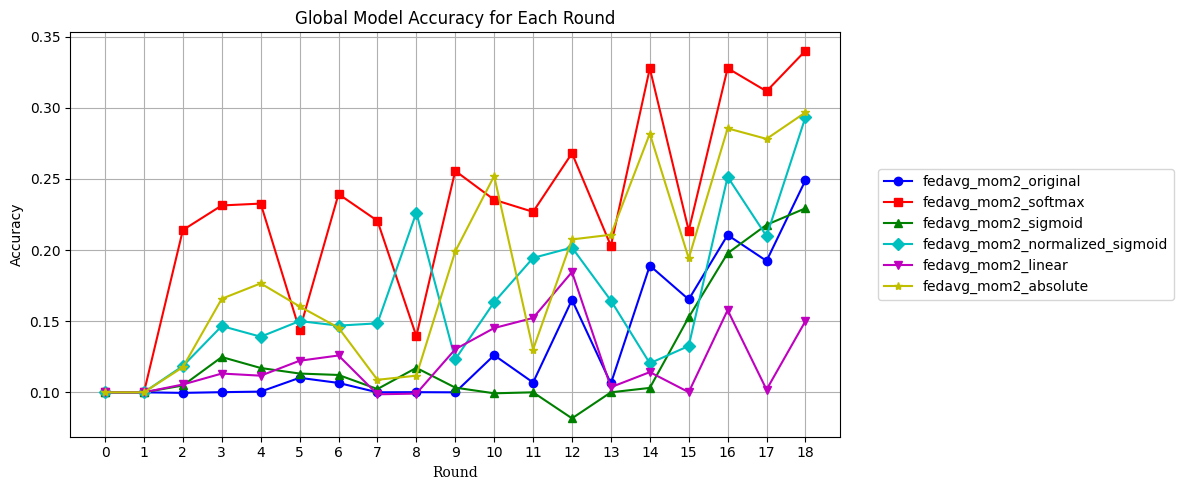

In [11]:
plot_accuracy_per_round(fedavg_mom2_results)

For strategies that use both momentum we can see a clear fluctuation in the loss and accuracy values. However, even with these fluctuation updates  half of the weighting mechanism (softmax, absolute and normalized sigmoid) managed to outperform the FedPartAvg strategy. This fluctuation is also caused by the contrasting nature of the data distribution which creates contrasting optimizer states. When these optimiser states are aggregated based on cosine similarity (regardless of the weighting mechanism) their differences are further amplified creating a more contrasting optimizer state in each client and hence causing fluctuation in the training process.














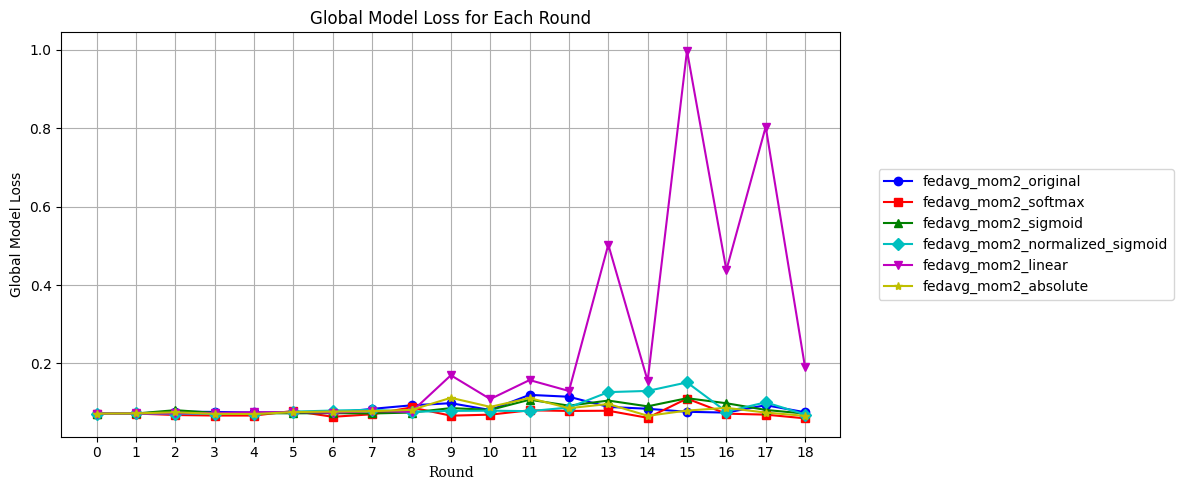

In [12]:
plot_loss_per_round(fedavg_mom2_results)

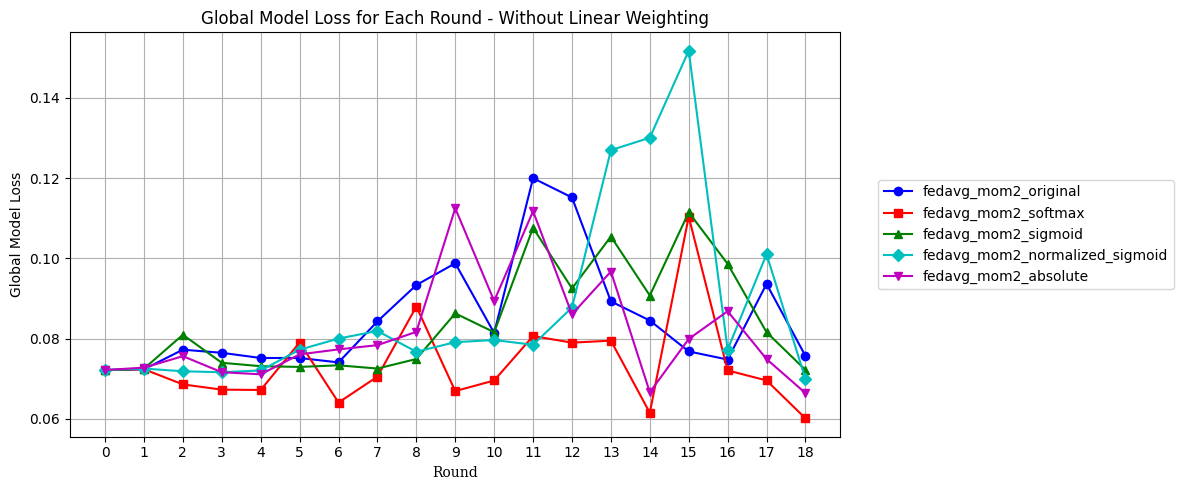

In [13]:
fedavg_mom2_results_without_linear_weighting= fedavg_mom2_results.copy()
fedavg_mom2_results_without_linear_weighting.pop('fedavg_mom2_linear')
plot_loss_per_round(fedavg_mom2_results_without_linear_weighting, modified_label="Without Linear Weighting")

### Parameter Differences Across Round













The L2 norm values for all strategies indicate a plateauing trend meaning that the models do not change significantly between rounds. This is suggest that the models stop learning or at least the learning is very slow. Furthermore, the parameter differences between consecutive central models as well as their cosine similarity are showing an amplified behaviour compared to the "Ideal Setting" experiments especially in the deeper layers. This can be also explained by the great difference between client data that that is further amplified by the cosine similarity and hence layers with more parameters are more affected by the data heterogeneity.














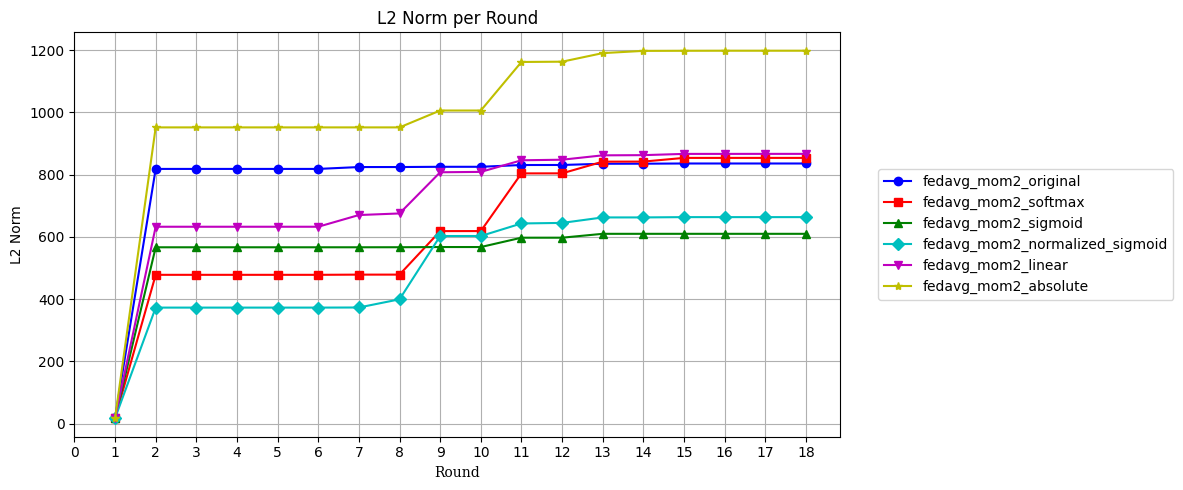

In [14]:
plot_l2_norm_per_round(fedavg_mom2_results)

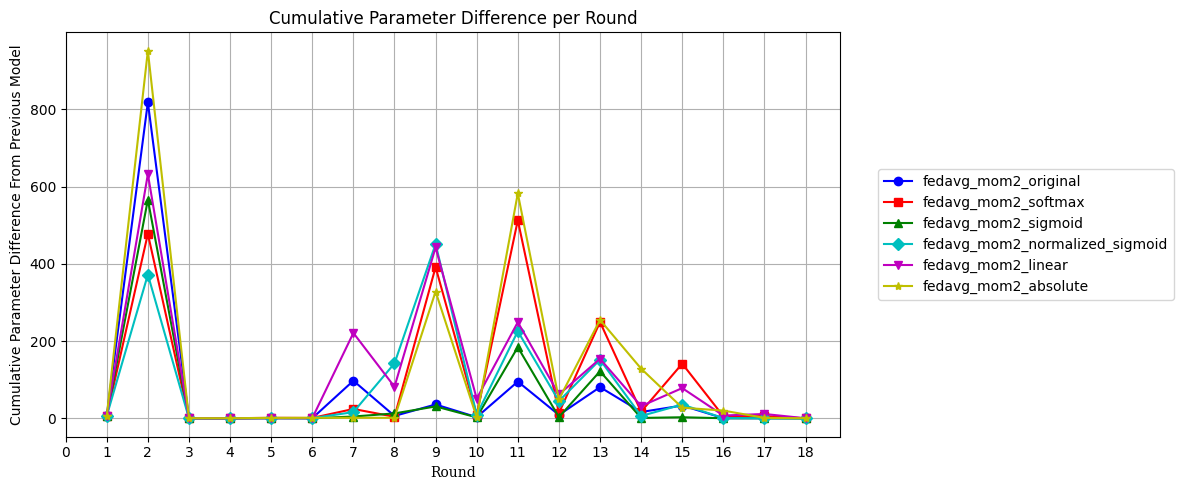

In [15]:
plot_parameter_difference_per_round(fedavg_mom2_results)

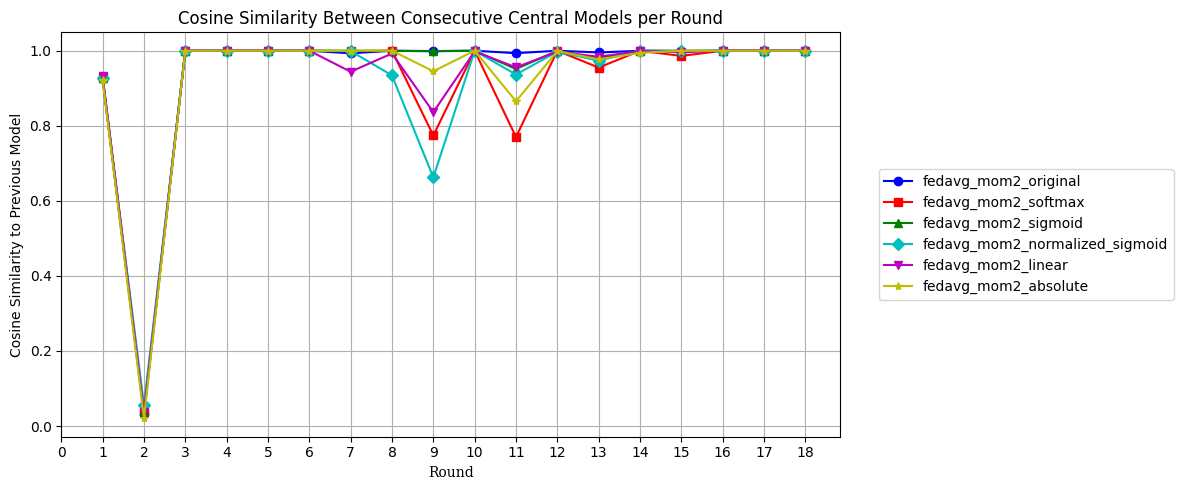

In [16]:
plot_cosine_similarity_per_round(fedavg_mom2_results)

### Save the results to pickle files

In [44]:
pickle.dump(fedavg_mom2_results, open(f"{experiment_type}_fedavgmom2.pkl", 'wb'))
all_results.update(fedavg_mom2_results)

# Single Momentum

## FedAvgMom1

### FedAvgMom1 Original Weighting


In [6]:
from src.FedMom1.FedAvg.client import get_fedavg_mom1_client_fn
from src.FedMom1.FedAvg.strategy import FedAvgMom1

In [7]:
fedavg_mom1_original_client_fn = get_fedavg_mom1_client_fn(load_datasets)
client = ClientApp(client_fn=fedavg_mom1_original_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
fedavg_mom1_original_strategy = FedAvgMom1(evaluate_fn=evaluate_fn, aggregate_mode="original")

def fedavg_mom1_original_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=fedavg_mom1_original_strategy,
    )

server = ServerApp(server_fn=fedavg_mom1_original_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Tue Jun 24 02:55:08 2025).
/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]


(ClientAppActor pid=5228) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=5228) Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Tue Jun 24 02:55:08 2025).
(ClientAppActor pid=5228) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=5228)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=5228) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=5226) [Client 5] initialized
(ClientAppActor pid=5226) [Client 5] fit
(ClientAppActor pid=5228) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=5228) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=5228) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=5228) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=5228) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=5228) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=5228) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=5228) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=5228) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=5228) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=5228) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=5228) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=5228) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=5228) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=5228) Layer 14 (fc7.weight) is trainable
(ClientAppA

(ClientAppActor pid=5228) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub [repeated 6x across cluster]
(ClientAppActor pid=5228) Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Tue Jun 24 02:55:08 2025). [repeated 6x across cluster]
(ClientAppActor pid=5230) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=5230)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]
(ClientAppActor pid=5230) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 5x across clu

(ClientAppActor pid=5226) [Client 3] initialized
(ClientAppActor pid=5226) [Client 3] evaluate
(ClientAppActor pid=5230) Epoch 8: train loss 0.04034220954190671, accuracy 0.5176241187940603 [repeated 11x across cluster]
(ClientAppActor pid=5230) [Client 1] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=5226) [Client 2] fit
(ClientAppActor pid=5226) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=5226) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=5226) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=5226) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=5226) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=5226) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=5226) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=5226) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=5226) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=5226) Layer 9 (fc3.bias

(ClientAppActor pid=5228) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub [repeated 6x across cluster]
(ClientAppActor pid=5228) Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Tue Jun 24 02:55:08 2025). [repeated 6x across cluster]
(ClientAppActor pid=5228) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 7x across cluster]
(ClientAppActor pid=5228)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 7x across cluster]


(ClientAppActor pid=5226) Epoch 1: train loss 0.06940255167246079, accuracy 0.2476747674767477
(ClientAppActor pid=5230) [Client 0] fit [repeated 5x across cluster]
(ClientAppActor pid=5230) Layer 15 (fc7.bias) is trainable [repeated 80x across cluster]
(ClientAppActor pid=5230) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=5230) training network... [repeated 5x across cluster]
(ClientAppActor pid=5230) [Client 0] initialized [repeated 5x across cluster]
(ClientAppActor pid=5228) Epoch 3: train loss 0.04971480421429098, accuracy 0.3988898889888989 [repeated 12x across cluster]
(ClientAppActor pid=5228) Epoch 5: train loss 0.044710581979700084, accuracy 0.4675967596759676 [repeated 12x across cluster]
(ClientAppActor pid=5228) Epoch 7: train loss 0.0427219887109551, accuracy 0.4951995199519952 [repeated 12x across cluster]
(ClientAppActor pid=5228) [Client 5] get_parameters
[-0.1983700841665268, -0.29843568801879883, 0.2017807811498642, -0.080

(ClientAppActor pid=5228) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub [repeated 6x across cluster]
(ClientAppActor pid=5228) Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Tue Jun 24 02:55:08 2025). [repeated 6x across cluster]
(ClientAppActor pid=5231) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=5231)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=5231) [Client 2] initialized
(ClientAppActor pid=5231) [Client 2] evaluate
(ClientAppActor pid=5227) Epoch 8: train loss 0.043777761080584794, accuracy 0.4843984398439844 [repeated 11x across cluster]
(ClientAppActor pid=5227) [Client 3] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]


(ClientAppActor pid=5228) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub [repeated 6x across cluster]
(ClientAppActor pid=5228) Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Tue Jun 24 02:55:08 2025). [repeated 6x across cluster]
(ClientAppActor pid=5226) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=5226)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=5226) [Client 4] fit
(ClientAppActor pid=5226) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=5226) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=5226) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=5226) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=5226) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=5226) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=5226) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=5226) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=5226) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=5226) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=5226) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=5226) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=5226) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=5226) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=5226) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=5226) Layer 15 (fc7.bias) is frozen
(ClientAppActor pid=5226) Got optimizer sta

(ClientAppActor pid=5228) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub [repeated 6x across cluster]
(ClientAppActor pid=5228) Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Tue Jun 24 02:55:08 2025). [repeated 6x across cluster]
(ClientAppActor pid=5228) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 7x across cluster]
(ClientAppActor pid=5228)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 7x across cluster]


(ClientAppActor pid=5227) [Client 4] initialized
(ClientAppActor pid=5228) Epoch 8: train loss 0.0820026130749222, accuracy 0.24103794810259488 [repeated 11x across cluster]
(ClientAppActor pid=5230) [Client 0] evaluate
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=5226) [Client 3] fit
(ClientAppActor pid=5226) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=5226) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=5226) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=5226) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=5226) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=5226) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=5226) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=5226) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=5226) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=5226) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=5226) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=5226) Layer 

(ClientAppActor pid=5228) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub [repeated 12x across cluster]
(ClientAppActor pid=5228) Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Tue Jun 24 02:55:08 2025). [repeated 12x across cluster]
(ClientAppActor pid=5230) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=5230)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=5226) [Client 5] fit
(ClientAppActor pid=5226) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=5226) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=5226) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=5226) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=5226) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=5226) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=5226) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=5226) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=5226) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=5226) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=5226) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=5226) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=5226) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=5226) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=5226) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=5226

(ClientAppActor pid=5230) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub [repeated 11x across cluster]
(ClientAppActor pid=5230) Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Tue Jun 24 02:55:08 2025). [repeated 11x across cluster]
(ClientAppActor pid=5227) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=5227)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


(ClientAppActor pid=5229) [Client 1] initialized
(ClientAppActor pid=5229) [Client 1] evaluate
(ClientAppActor pid=5227) Epoch 8: train loss 0.0528808890110088, accuracy 0.3541854185418542 [repeated 11x across cluster]
(ClientAppActor pid=5227) [Client 4] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=5231) [Client 1] fit
(ClientAppActor pid=5231) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=5231) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=5231) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=5231) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=5231) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=5231) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=5231) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=5231) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=5231) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=5231) Layer 9 (fc3.bias) is frozen
(ClientApp

(ClientAppActor pid=5227) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=5227)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=5227) [Client 5] initialized
(ClientAppActor pid=5227) [Client 5] evaluate
(ClientAppActor pid=5229) Epoch 8: train loss 0.052969671586881054, accuracy 0.3621362136213621 [repeated 11x across cluster]
(ClientAppActor pid=5229) [Client 5] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=5231) [Client 0] fit
(ClientAppActor pid=5226) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=5226) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=5226) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=5226) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=5226) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=5226) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=5226) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=5226) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=5226) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=5226) Layer 9 (fc3.bias) is frozen
(ClientA

(ClientAppActor pid=5227) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 9x across cluster]
(ClientAppActor pid=5227)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 9x across cluster]


(ClientAppActor pid=5227) [Client 2] initialized [repeated 9x across cluster]
(ClientAppActor pid=5231) [Client 0] evaluate [repeated 5x across cluster]
(ClientAppActor pid=5231) Epoch 1: train loss 0.06005447588886692, accuracy 0.3673316334183291
(ClientAppActor pid=5228) [Client 5] fit [repeated 5x across cluster]
(ClientAppActor pid=5228) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=5228) Layer 5 (fc1.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=5228) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=5228) training network... [repeated 5x across cluster]
(ClientAppActor pid=5228) [Client 5] initialized [repeated 2x across cluster]
(ClientAppActor pid=5231) Epoch 4: train loss 0.048254147719564475, accuracy 0.42342882855857206 [repeated 18x across cluster]
(ClientAppActor pid=5228) Epoch 6: train loss 0.04852322835733395, accuracy 0.4446444644464446 [repeated 17x across cluster]
(Client

(ClientAppActor pid=5229) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=5229)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=5230) [Client 4] fit
(ClientAppActor pid=5230) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=5230) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=5230) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=5230) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=5230) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=5230) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=5230) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=5230) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=5230) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=5230) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=5230) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=5230) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=5230) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=5230) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=5230) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=5230

(ClientAppActor pid=5227) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=5227)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=5227) [Client 2] initialized
(ClientAppActor pid=5227) [Client 2] evaluate
(ClientAppActor pid=5227) Epoch 8: train loss 0.04556843097453857, accuracy 0.4648964896489649 [repeated 11x across cluster]
(ClientAppActor pid=5227) [Client 3] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=5230) [Client 4] fit
(ClientAppActor pid=5230) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=5230) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=5230) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=5230) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=5230) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=5230) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=5230) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=5230) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=5230) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=5230) Layer 9 (fc3.bias) is frozen
(ClientAp

(ClientAppActor pid=5226) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=5226)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=5227) [Client 3] fit
(ClientAppActor pid=5227) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=5227) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=5227) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=5227) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=5227) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=5227) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=5227) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=5227) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=5227) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=5227) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=5227) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=5227) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=5227) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=5227) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=5227) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=5227

(ClientAppActor pid=5226) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=5226)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=5227) Epoch 1: train loss 0.04731177351977637, accuracy 0.4465946594659466
(ClientAppActor pid=5226) [Client 1] fit [repeated 5x across cluster]
(ClientAppActor pid=5226) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=5226) Layer 7 (fc2.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=5226) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=5226) training network... [repeated 5x across cluster]
(ClientAppActor pid=5231) Epoch 3: train loss 0.04691604543404646, accuracy 0.4564956495649565 [repeated 16x across cluster]
(ClientAppActor pid=5228) Epoch 6: train loss 0.046260526624776546, accuracy 0.46227688615569223 [repeated 14x across cluster]
(ClientAppActor pid=5228) [Client 0] get_parameters
(ClientAppActor pid=5229) Epoch 8: train loss 0.04610134950458127, accuracy 0.44854485448544856 [repeated 13x across cluster]
[0.9078409075737, 0.972993791103363, 0.9256439208984375, 0.9

(ClientAppActor pid=5227) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=5227)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=5231) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=5231)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=5226) [Client 0] fit
(ClientAppActor pid=5226) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=5226) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=5226) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=5226) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=5226) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=5226) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=5226) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=5226) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=5226) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=5226) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=5226) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=5226) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=5226) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=5226) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=5226) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=5226

(ClientAppActor pid=5226) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=5226)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=5228) [Client 0] fit
(ClientAppActor pid=5228) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=5228) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=5228) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=5228) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=5228) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=5228) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=5228) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=5228) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=5228) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=5228) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=5228) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=5228) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=5228) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=5228) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=5228) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=5228

(ClientAppActor pid=5227) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=5227)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=5227) [Client 5] initialized
(ClientAppActor pid=5227) [Client 5] evaluate
(ClientAppActor pid=5230) Epoch 8: train loss 0.04569282792475071, accuracy 0.46339633963396337 [repeated 3x across cluster]
(ClientAppActor pid=5227) [Client 1] get_parameters [repeated 3x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=5227) [Client 5] fit
(ClientAppActor pid=5227) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=5227) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=5227) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=5227) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=5227) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=5227) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=5227) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=5227) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=5227) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=5227) Layer 9 (fc3.bias) is frozen
(ClientAppActor

(ClientAppActor pid=5227) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=5227)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=5227) [Client 2] initialized
(ClientAppActor pid=5227) [Client 2] evaluate
(ClientAppActor pid=5231) Epoch 8: train loss 0.04433985178091902, accuracy 0.47637618119094044 [repeated 11x across cluster]
(ClientAppActor pid=5231) [Client 1] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=5226) [Client 4] fit
(ClientAppActor pid=5226) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=5226) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=5226) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=5226) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=5226) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=5226) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=5226) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=5226) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=5226) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=5226) Layer 9 (fc3.bias) is frozen
(ClientAppActo

(ClientAppActor pid=5228) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=5228)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=5227) [Client 2] fit
(ClientAppActor pid=5227) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=5227) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=5227) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=5227) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=5227) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=5227) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=5227) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=5227) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=5227) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=5227) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=5227) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=5227) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=5227) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=5227) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=5227) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=5227

(ClientAppActor pid=5228) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=5228)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=5228) [Client 5] initialized
(ClientAppActor pid=5228) [Client 5] evaluate
(ClientAppActor pid=5231) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=5231) Epoch 8: train loss 0.044206251442942, accuracy 0.48192590370481475 [repeated 8x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=5228) [Client 0] fit
(ClientAppActor pid=5228) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=5228) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=5228) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=5228) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=5228) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=5228) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=5228) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=5228) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=5228) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=5228) Layer 9 (fc3.bias) is frozen
(ClientAppActor p

(ClientAppActor pid=5227) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=5227)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=5227) [Client 0] initialized
(ClientAppActor pid=5227) [Client 0] evaluate
(ClientAppActor pid=5230) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=5227) Epoch 8: train loss 0.044393746927268794, accuracy 0.4813981398139814 [repeated 3x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=5230) [Client 2] fit
(ClientAppActor pid=5230) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=5230) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=5230) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=5230) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=5230) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=5230) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=5230) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=5230) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=5230) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=5230) Layer 9 (fc3.bias) is frozen
(ClientAppActor

(ClientAppActor pid=5229) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=5229)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=5231) [Client 3] fit
(ClientAppActor pid=5227) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=5227) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=5227) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=5227) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=5227) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=5227) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=5227) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=5227) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=5227) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=5227) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=5227) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=5227) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=5227) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=5227) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=5227) Layer 14 (fc7.weight) is trainable
(ClientAppActor pid=5227) L

(ClientAppActor pid=5228) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=5228)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=5228) [Client 1] initialized
(ClientAppActor pid=5228) [Client 1] evaluate
(ClientAppActor pid=5230) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=5230) Epoch 8: train loss 0.04400334235179042, accuracy 0.47824782478247824 [repeated 13x across cluster]
(ClientAppActor pid=5229) [Client 5] initialized [repeated 5x across cluster]
(ClientAppActor pid=5229) [Client 5] evaluate [repeated 5x across cluster]


(ClientAppActor pid=5229) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=5229)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [8]:
fedavg_mom1_original_results=fedavg_mom1_original_strategy.get_results()
fedavg_mom1_results['fedavg_mom1_original'] = fedavg_mom1_original_results

### FedAvgMom1 Softmax Weighting



In [9]:
fedavg_mom1_softmax_client_fn = get_fedavg_mom1_client_fn(load_datasets)
client = ClientApp(client_fn=fedavg_mom1_softmax_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
fedavg_mom1_softmax_strategy = FedAvgMom1(evaluate_fn=evaluate_fn, aggregate_mode="softmax")

def fedavg_mom1_softmax_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=fedavg_mom1_softmax_strategy,
    )

server = ServerApp(server_fn=fedavg_mom1_softmax_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]


(ClientAppActor pid=19298) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=19298)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=19298) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=19298) [Client 1] initialized
(ClientAppActor pid=19298) [Client 1] fit
(ClientAppActor pid=19298) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=19298) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=19298) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=19298) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=19298) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=19298) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=19298) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=19298) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=19298) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=19298) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=19298) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=19298) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=19298) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=19298) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=19298) Layer 14 (fc7.weight) is trai

(ClientAppActor pid=19300) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=19300)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
(ClientAppActor pid=19295) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 5x across cluster]


(ClientAppActor pid=19300) [Client 1] initialized
(ClientAppActor pid=19300) [Client 1] evaluate
(ClientAppActor pid=19296) Epoch 8: train loss 0.040754314767967426, accuracy 0.5091509150915091 [repeated 5x across cluster]
(ClientAppActor pid=19296) [Client 4] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=19299) [Client 0] fit
(ClientAppActor pid=19299) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=19299) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=19299) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=19299) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=19299) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=19299) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=19299) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=19299) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=19299) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=19299) La

(ClientAppActor pid=19296) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19296)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=19296) [Client 2] fit
(ClientAppActor pid=19296) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=19296) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=19296) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=19296) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=19296) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=19296) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=19296) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=19296) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=19296) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=19296) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=19296) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=19296) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=19296) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=19296) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=19296) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=19300) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19300)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19300) [Client 0] initialized
(ClientAppActor pid=19300) [Client 0] evaluate
(ClientAppActor pid=19300) Epoch 8: train loss 0.05351823562979162, accuracy 0.3511851185118512 [repeated 5x across cluster]
(ClientAppActor pid=19300) [Client 5] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=19299) [Client 2] fit
(ClientAppActor pid=19299) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=19299) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=19299) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=19299) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=19299) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=19299) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=19299) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=19299) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=19299) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=19299) Layer 9 (fc3.bias) is fr

(ClientAppActor pid=19300) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19300)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19295) [Client 2] initialized
(ClientAppActor pid=19295) [Client 2] evaluate
(ClientAppActor pid=19296) Epoch 8: train loss 0.05229717139917388, accuracy 0.3685315734213289 [repeated 11x across cluster]
(ClientAppActor pid=19296) [Client 0] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=19299) [Client 0] fit
(ClientAppActor pid=19299) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=19299) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=19299) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=19299) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=19299) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=19299) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=19299) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=19299) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=19299) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=19299) Layer 9 (fc3.bias) is f

(ClientAppActor pid=19295) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19295)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19295) [Client 3] initialized
(ClientAppActor pid=19295) [Client 3] evaluate
(ClientAppActor pid=19296) Epoch 8: train loss 0.05032383151116607, accuracy 0.3941802909854507 [repeated 11x across cluster]
(ClientAppActor pid=19296) [Client 1] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=19297) [Client 4] fit
(ClientAppActor pid=19297) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=19297) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=19297) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=19297) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=19297) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=19297) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=19297) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=19297) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=19297) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=19297) Layer 9 (fc3.bias) is f

(ClientAppActor pid=19299) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19299)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19299) [Client 3] initialized
(ClientAppActor pid=19299) [Client 3] evaluate
(ClientAppActor pid=19299) Epoch 8: train loss 0.04899445165843286, accuracy 0.4088795560221989 [repeated 7x across cluster]
(ClientAppActor pid=19299) [Client 0] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=19299) [Client 4] fit
(ClientAppActor pid=19298) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=19298) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=19298) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=19298) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=19298) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=19298) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=19298) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=19298) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=19298) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=19298) Layer 9 (fc3.bias) is fr

(ClientAppActor pid=19295) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19295)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19295) [Client 0] initialized
(ClientAppActor pid=19295) [Client 0] evaluate
(ClientAppActor pid=19297) Epoch 8: train loss 0.04087122310899665, accuracy 0.4921992199219922 [repeated 11x across cluster]
(ClientAppActor pid=19297) [Client 5] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=19297) [Client 3] fit
(ClientAppActor pid=19298) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=19298) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=19298) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=19298) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=19298) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=19298) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=19298) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=19298) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=19298) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=19298) Layer 9 (fc3.bias) is f

(ClientAppActor pid=19299) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 14x across cluster]
(ClientAppActor pid=19299)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 14x across cluster]


(ClientAppActor pid=19299) [Client 4] initialized
(ClientAppActor pid=19299) [Client 4] evaluate
(ClientAppActor pid=19296) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=19296) Epoch 8: train loss 0.03836087078222669, accuracy 0.551005100510051 [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=19296) [Client 3] fit
(ClientAppActor pid=19297) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=19297) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=19297) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=19297) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=19297) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=19297) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=19297) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=19297) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=19297) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=19297) Layer 9 (fc3.bias) is fro

(ClientAppActor pid=19299) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19299)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19299) [Client 2] initialized
(ClientAppActor pid=19299) [Client 2] evaluate
(ClientAppActor pid=19295) [Client 1] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=19300) [Client 1] fit
(ClientAppActor pid=19300) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=19300) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=19300) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=19300) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=19300) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=19300) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=19300) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=19300) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=19300) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=19300) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=19300) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=19300) Layer 11 (fc4.bias) is frozen
(Cli

(ClientAppActor pid=19299) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19299)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19299) [Client 5] initialized
(ClientAppActor pid=19299) [Client 5] evaluate
(ClientAppActor pid=19296) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=19296) Epoch 8: train loss 0.03990961551809325, accuracy 0.5354035403540354 [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=19296) [Client 2] fit
(ClientAppActor pid=19296) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=19296) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=19296) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=19296) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=19296) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=19296) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=19296) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=19296) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=19296) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=19296) Layer 9 (fc3.bias) is train

(ClientAppActor pid=19298) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19298)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19298) [Client 4] initialized
(ClientAppActor pid=19298) [Client 4] evaluate
(ClientAppActor pid=19299) Epoch 8: train loss 0.04114402642184976, accuracy 0.5321733913304335 [repeated 11x across cluster]
(ClientAppActor pid=19299) [Client 1] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=19300) [Client 3] fit
(ClientAppActor pid=19300) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=19300) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=19300) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=19300) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=19300) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=19300) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=19300) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=19300) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=19300) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=19300) Layer 9 (fc3.bias) is trai

(ClientAppActor pid=19300) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19300)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19300) [Client 0] initialized
(ClientAppActor pid=19300) [Client 0] evaluate
(ClientAppActor pid=19298) Epoch 8: train loss 0.03997630555101103, accuracy 0.5379537953795379 [repeated 11x across cluster]
(ClientAppActor pid=19298) [Client 2] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=19299) [Client 1] fit
(ClientAppActor pid=19299) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=19299) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=19299) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=19299) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=19299) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=19299) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=19299) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=19299) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=19299) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=19299) Layer 9 (fc3.bias) is frozen


(ClientAppActor pid=19296) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19296)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=19300) [Client 1] fit
(ClientAppActor pid=19299) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=19299) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=19299) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=19299) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=19299) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=19299) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=19299) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=19299) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=19299) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=19299) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=19299) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=19299) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=19299) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=19299) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=19299) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=19300) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=19300)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


(ClientAppActor pid=19295) [Client 3] initialized
(ClientAppActor pid=19295) [Client 3] evaluate
(ClientAppActor pid=19297) Epoch 8: train loss 0.03908145577028425, accuracy 0.5426042604260426 [repeated 11x across cluster]
(ClientAppActor pid=19300) [Client 1] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]


(ClientAppActor pid=19299) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=19299)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=19299) [Client 2] fit
(ClientAppActor pid=19299) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=19299) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=19299) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=19299) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=19299) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=19299) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=19299) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=19299) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=19299) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=19299) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=19299) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=19299) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=19299) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=19299) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=19299) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=19299) Layer 15 (fc7.bias) is frozen
(ClientAppActor pid=19299)

(ClientAppActor pid=19297) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=19297)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=19296) [Client 0] fit
(ClientAppActor pid=19295) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=19295) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=19295) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=19295) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=19295) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=19295) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=19295) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=19295) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=19295) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=19295) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=19295) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=19295) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=19295) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=19295) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=19295) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=19300) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19300)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19300) [Client 1] initialized
(ClientAppActor pid=19300) [Client 1] evaluate
(ClientAppActor pid=19297) Epoch 8: train loss 0.03922058291676271, accuracy 0.5395230238488076 [repeated 11x across cluster]
(ClientAppActor pid=19297) [Client 1] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=19299) [Client 2] fit
(ClientAppActor pid=19295) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=19295) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=19295) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=19295) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=19295) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=19295) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=19295) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=19295) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=19295) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=19295) Layer 9 (fc3.bias) is frozen


(ClientAppActor pid=19297) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19297)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=19300) [Client 5] fit
(ClientAppActor pid=19300) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=19300) 
(ClientAppActor pid=19300) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=19300) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=19300) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=19300) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=19300) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=19300) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=19300) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=19300) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=19300) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=19300) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=19300) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=19300) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=19300) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=19300) Layer 14 (fc7.weig

(ClientAppActor pid=19296) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19296)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19300) [Client 5] initialized [repeated 5x across cluster]
(ClientAppActor pid=19300) [Client 5] evaluate [repeated 5x across cluster]


(ClientAppActor pid=19295) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=19295)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [10]:
fedavg_mom1_softmax_results=fedavg_mom1_softmax_strategy.get_results()
fedavg_mom1_results['fedavg_mom1_softmax'] = fedavg_mom1_softmax_results

### FedAvgMom1 Sigmoid Weighting

In [11]:
fedavg_mom1_sigmoid_client_fn = get_fedavg_mom1_client_fn(load_datasets)
client = ClientApp(client_fn=fedavg_mom1_sigmoid_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
fedavg_mom1_sigmoid_strategy = FedAvgMom1(evaluate_fn=evaluate_fn, aggregate_mode="sigmoid")

def fedavg_mom1_sigmoid_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=fedavg_mom1_sigmoid_strategy,
    )

server = ServerApp(server_fn=fedavg_mom1_sigmoid_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0722, Accuracy: 0.1000
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]


(ClientAppActor pid=34026) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=34026)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=34026) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=34026) [Client 0] initialized
(ClientAppActor pid=34026) [Client 0] fit
(ClientAppActor pid=34026) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=34026) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=34026) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=34026) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=34026) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=34026) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=34026) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=34026) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=34026) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=34026) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=34026) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=34026) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=34026) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=34026) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=34026) Layer 14 (fc7.weight) is trai

(ClientAppActor pid=34023) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=34023)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
(ClientAppActor pid=34024) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 5x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=34022) [Client 4] fit
(ClientAppActor pid=34022) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=34022) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=34022) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=34022) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=34022) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=34022) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=34022) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=34022) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=34022) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=34022) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=34022) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=34022) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=34022) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=34022) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=34022) Laye

(ClientAppActor pid=34023) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=34023)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=34025) [Client 0] fit
(ClientAppActor pid=34025) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=34025) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=34025) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=34025) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=34025) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=34025) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=34025) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=34025) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=34025) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=34025) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=34025) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=34025) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=34025) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=34025) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=34025) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=34021) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=34021)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=34024) [Client 2] fit
(ClientAppActor pid=34024) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=34024) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=34024) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=34024) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=34024) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=34024) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=34024) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=34024) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=34024) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=34024) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=34024) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=34024) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=34024) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=34024) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=34024) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=34021) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=34021)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=34021) [Client 4] initialized
(ClientAppActor pid=34021) [Client 4] evaluate
(ClientAppActor pid=34023) [Client 1] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=34022) [Client 0] fit
(ClientAppActor pid=34023) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=34023) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=34023) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=34023) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=34023) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=34023) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=34023) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=34023) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=34023) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=34023) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=34023) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=34023) Layer 11 (fc4.bias) is frozen
(Cli

(ClientAppActor pid=34022) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=34022)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=34023) [Client 3] fit
(ClientAppActor pid=34023) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=34023) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=34023) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=34023) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=34023) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=34023) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=34023) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=34023) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=34023) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=34023) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=34023) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=34023) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=34023) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=34023) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=34023) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=34021) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=34021)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=34021) [Client 4] initialized
(ClientAppActor pid=34021) [Client 4] evaluate
(ClientAppActor pid=34024) [Client 4] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=34024) Epoch 8: train loss 0.04379243815656972, accuracy 0.47014701470147013
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=34026) [Client 3] fit
(ClientAppActor pid=34026) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=34026) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=34026) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=34026) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=34026) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=34026) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=34026) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=34026) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=34026) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=34026) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=340

(ClientAppActor pid=34024) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=34024)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=34026) [Client 2] fit
(ClientAppActor pid=34025) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=34025) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=34025) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=34025) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=34025) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=34025) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=34025) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=34025) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=34025) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=34025) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=34025) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=34025) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=34025) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=34025) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=34025) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=34022) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 10x across cluster]
(ClientAppActor pid=34022)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 10x across cluster]


(ClientAppActor pid=34025) Epoch 1: train loss 0.04022011823770041, accuracy 0.5339733013349333
(ClientAppActor pid=34023) [Client 0] fit [repeated 5x across cluster]
(ClientAppActor pid=34023) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=34023) Layer 5 (fc1.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=34023) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=34023) training network... [repeated 5x across cluster]
(ClientAppActor pid=34023) [Client 0] initialized
(ClientAppActor pid=34022) Epoch 2: train loss 0.03710660476996453, accuracy 0.5622562256225623 [repeated 10x across cluster]
(ClientAppActor pid=34025) Epoch 4: train loss 0.03380196682244955, accuracy 0.6136193190340483 [repeated 8x across cluster]
(ClientAppActor pid=34023) Epoch 5: train loss 0.032760682403907185, accuracy 0.6280185990700465 [repeated 11x across cluster]
(ClientAppActor pid=34021) Epoch 7: train loss 0.0300433

(ClientAppActor pid=34024) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=34024)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=34025) [Client 5] fit
(ClientAppActor pid=34025) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=34025) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=34025) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=34025) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=34025) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=34025) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=34025) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=34025) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=34025) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=34025) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=34025) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=34025) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=34025) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=34025) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=34025) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=34024) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=34024)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=34021) [Client 0] fit
(ClientAppActor pid=34021) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=34021) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=34021) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=34021) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=34021) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=34021) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=34021) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=34021) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=34021) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=34021) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=34021) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=34021) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=34021) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=34021) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=34021) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=34023) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=34023)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=34023) [Client 1] fit
(ClientAppActor pid=34026) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=34026) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=34026) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=34026) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=34026) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=34026) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=34026) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=34026) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=34026) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=34026) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=34026) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=34026) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=34026) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=34026) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=34026) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=34023) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=34023)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=34023) [Client 2] fit
(ClientAppActor pid=34023) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=34023) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=34023) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=34023) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=34023) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=34023) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=34023) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=34023) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=34023) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=34023) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=34023) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=34023) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=34023) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=34023) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=34023) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=34025) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=34025)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=34023) [Client 2] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]


(ClientAppActor pid=34026) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=34026)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=34026) [Client 3] fit
(ClientAppActor pid=34026) [Client 3] initialized [repeated 6x across cluster]
(ClientAppActor pid=34026) [Client 3] evaluate [repeated 5x across cluster]
(ClientAppActor pid=34026) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=34026) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=34026) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=34026) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=34026) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=34026) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=34026) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=34026) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=34026) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=34026) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=34026) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=34026) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=34026) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=34026) Layer 13 (fc5.bia

(ClientAppActor pid=34024) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=34024)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=34021) [Client 0] fit
(ClientAppActor pid=34021) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=34021) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=34021) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=34021) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=34021) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=34021) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=34021) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=34021) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=34021) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=34021) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=34021) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=34021) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=34021) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=34021) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=34021) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=34024) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=34024)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=34022) [Client 5] fit
(ClientAppActor pid=34021) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=34021) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=34021) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=34021) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=34021) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=34021) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=34021) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=34021) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=34021) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=34021) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=34021) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=34021) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=34021) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=34021) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=34021) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=34026) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=34026)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=34026) [Client 4] initialized
(ClientAppActor pid=34026) [Client 4] evaluate
(ClientAppActor pid=34023) Epoch 8: train loss 0.03391321827404641, accuracy 0.6167116711671167 [repeated 5x across cluster]
(ClientAppActor pid=34023) [Client 4] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=34024) [Client 3] fit
(ClientAppActor pid=34024) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=34024) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=34024) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=34024) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=34024) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=34024) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=34024) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=34024) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=34024) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=34024) Layer 9 (fc3.bias) is frozen
(

(ClientAppActor pid=34025) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=34025)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=34024) [Client 2] fit
(ClientAppActor pid=34025) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=34025) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=34025) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=34025) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=34025) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=34025) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=34025) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=34025) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=34025) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=34025) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=34025) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=34025) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=34025) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=34025) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=34025) Layer 14 (fc7.weight) is trainable
(ClientAppA

(ClientAppActor pid=34024) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=34024)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=34023) [Client 3] fit
(ClientAppActor pid=34026) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=34026) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=34026) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=34026) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=34026) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=34026) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=34026) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=34026) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=34026) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=34026) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=34026) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=34026) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=34026) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=34026) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=34026) Layer 14 (fc7.weight) is trainable
(ClientAppA

(ClientAppActor pid=34024) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=34024)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=34025) [Client 3] initialized
(ClientAppActor pid=34025) [Client 3] evaluate
(ClientAppActor pid=34021) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=34021) Epoch 8: train loss 0.03573607450771031, accuracy 0.6038698065096745 [repeated 4x across cluster]
(ClientAppActor pid=34023) [Client 0] initialized [repeated 5x across cluster]
(ClientAppActor pid=34023) [Client 0] evaluate [repeated 5x across cluster]


(ClientAppActor pid=34023) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=34023)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [12]:
fedavg_mom1_sigmoid_results=fedavg_mom1_sigmoid_strategy.get_results()
fedavg_mom1_results['fedavg_mom1_sigmoid'] = fedavg_mom1_sigmoid_results

### FedAvgMom1 Normalized Sigmoid Weighting






In [13]:
fedavg_mom1_normalized_sigmoid_client_fn = get_fedavg_mom1_client_fn(load_datasets)
client = ClientApp(client_fn=fedavg_mom1_normalized_sigmoid_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
fedavg_mom1_normalized_sigmoid_strategy = FedAvgMom1(evaluate_fn=evaluate_fn, aggregate_mode="normalized_sigmoid")

def fedavg_mom1_normalized_sigmoid_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=fedavg_mom1_normalized_sigmoid_strategy,
    )

server = ServerApp(server_fn=fedavg_mom1_normalized_sigmoid_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]


(ClientAppActor pid=48223) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=48223)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=48223) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=48223) [Client 3] initialized
(ClientAppActor pid=48226) [Client 0] fit
(ClientAppActor pid=48226) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=48226) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=48226) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=48226) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=48226) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=48226) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=48226) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=48226) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=48226) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=48226) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=48226) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=48226) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=48226) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=48226) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=48226) Layer 14 (fc7.weight) is trai

(ClientAppActor pid=48226) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=48226)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
(ClientAppActor pid=48225) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 5x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48223) [Client 4] fit
(ClientAppActor pid=48223) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=48223) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=48223) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=48223) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=48223) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=48223) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=48223) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=48223) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=48223) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=48223) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=48223) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=48223) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=48223) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=48223) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=48223) Laye

(ClientAppActor pid=48217) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48217)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48217) [Client 1] initialized
(ClientAppActor pid=48217) [Client 1] evaluate
(ClientAppActor pid=48226) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=48217) Epoch 8: train loss 0.04909228749222273, accuracy 0.41104110411041106 [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48226) [Client 2] fit
(ClientAppActor pid=48226) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=48226) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=48226) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48226) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48226) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48226) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48226) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48226) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48226) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48226) Layer 9 (fc3.bias) is f

(ClientAppActor pid=48221) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48221)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48221) [Client 0] fit
(ClientAppActor pid=48221) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=48221) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=48221) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48221) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48221) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48221) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48221) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48221) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48221) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48221) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=48221) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=48221) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=48221) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=48221) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=48221) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=48226) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48226)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48221) [Client 0] fit
(ClientAppActor pid=48223) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48223) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48223) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=48223) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=48223) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48223) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48223) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48223) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48223) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48223) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=48223) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=48223) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=48223) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=48223) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=48223) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=48217) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48217)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48217) [Client 0] initialized
(ClientAppActor pid=48217) [Client 0] evaluate
(ClientAppActor pid=48217) [Client 3] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=48217) Epoch 8: train loss 0.05480782956358838, accuracy 0.32373237323732373 [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48223) [Client 1] fit
(ClientAppActor pid=48223) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48223) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48223) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=48223) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=48223) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48223) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48223) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48223) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48223) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48223) Layer 9 (fc3.bias) is f

(ClientAppActor pid=48226) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48226)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48217) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=48217) Epoch 8: train loss 0.053860721522324656, accuracy 0.32223222322232226 [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48226) [Client 2] fit
(ClientAppActor pid=48226) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48226) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48226) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48226) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48226) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=48226) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=48226) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48226) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48226) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48226) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=48226) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=48226) Laye

(ClientAppActor pid=48223) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48223)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48223) [Client 1] initialized
(ClientAppActor pid=48223) [Client 1] evaluate
(ClientAppActor pid=48223) Epoch 8: train loss 0.04852605087779286, accuracy 0.40339033903390337 [repeated 11x across cluster]
(ClientAppActor pid=48223) [Client 5] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48221) [Client 3] fit
(ClientAppActor pid=48221) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48221) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48221) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48221) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48221) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=48221) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=48221) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48221) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48221) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48221) Layer 9 (fc3.bias) is 

(ClientAppActor pid=48225) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48225)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48223) [Client 4] initialized
(ClientAppActor pid=48223) [Client 4] evaluate
(ClientAppActor pid=48223) Epoch 8: train loss 0.04571180074664876, accuracy 0.43999399939994 [repeated 11x across cluster]
(ClientAppActor pid=48223) [Client 4] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48221) [Client 2] fit
(ClientAppActor pid=48221) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48221) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48221) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48221) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48221) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48221) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48221) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=48221) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=48221) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48221) Layer 9 (fc3.bias) is fro

(ClientAppActor pid=48217) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48217)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48217) [Client 2] initialized
(ClientAppActor pid=48217) [Client 2] evaluate
(ClientAppActor pid=48226) Epoch 8: train loss 0.04693062470691039, accuracy 0.42649264926492647 [repeated 11x across cluster]
(ClientAppActor pid=48226) [Client 3] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48226) [Client 4] fit
(ClientAppActor pid=48226) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48226) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48226) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48226) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48226) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48226) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48226) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=48226) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=48226) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48226) Layer 9 (fc3.bias) is 

(ClientAppActor pid=48221) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48221)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48224) [Client 0] fit
(ClientAppActor pid=48224) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48224) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48224) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48224) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48224) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48224) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48224) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48224) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48224) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=48224) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=48224) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=48224) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=48224) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=48224) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=48224) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=48221) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48221)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48217) [Client 1] fit
(ClientAppActor pid=48221) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48221) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48221) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48221) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48221) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48221) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48221) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48221) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48221) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=48221) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=48221) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=48221) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=48221) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=48221) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=48221) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=48223) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48223)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48223) [Client 5] initialized
(ClientAppActor pid=48223) [Client 5] evaluate
(ClientAppActor pid=48226) Epoch 8: train loss 0.04427074741358661, accuracy 0.4720972097209721 [repeated 11x across cluster]
(ClientAppActor pid=48226) [Client 4] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48223) [Client 3] fit
(ClientAppActor pid=48223) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48223) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48223) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48223) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48223) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48223) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48223) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48223) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48223) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48223) Layer 9 (fc3.bias) is frozen


(ClientAppActor pid=48221) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48221)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48217) [Client 1] fit
(ClientAppActor pid=48217) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48217) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48217) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48217) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48217) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48217) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48217) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48217) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48217) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48217) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=48217) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=48217) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=48217) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=48217) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=48217) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=48217) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48217)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48217) [Client 2] initialized
(ClientAppActor pid=48217) [Client 2] evaluate
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48221) [Client 1] fit
(ClientAppActor pid=48223) Epoch 8: train loss 0.04399764044235463, accuracy 0.478997899789979 [repeated 5x across cluster]
(ClientAppActor pid=48223) [Client 4] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=48226) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48226) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48226) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48226) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48226) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48226) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48226) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48226) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48226) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48226) Layer 9 (fc3.bias) is frozen
(C

(ClientAppActor pid=48223) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48223)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48223) [Client 0] initialized
(ClientAppActor pid=48223) [Client 0] evaluate
(ClientAppActor pid=48226) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=48226) Epoch 8: train loss 0.04495870705806848, accuracy 0.4602460246024602 [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48223) [Client 2] fit
(ClientAppActor pid=48223) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48223) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48223) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48223) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48223) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48223) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48223) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48223) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48223) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48223) Layer 9 (fc3.bias) is frozen
(

(ClientAppActor pid=48221) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48221)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48223) [Client 2] fit
(ClientAppActor pid=48223) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48223) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48223) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48223) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48223) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48223) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48223) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48223) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48223) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48223) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=48223) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=48223) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=48223) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=48223) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=48223) Layer 14 (fc7.weight) is trainable
(ClientAppA

(ClientAppActor pid=48226) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48226)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48223) [Client 3] fit
(ClientAppActor pid=48223) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48223) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48223) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48223) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48223) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48223) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48223) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48223) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48223) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48223) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=48223) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=48223) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=48223) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=48223) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=48223) Layer 14 (fc7.weight) is trainable
(ClientAppA

(ClientAppActor pid=48223) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=48223)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


(ClientAppActor pid=48223) [Client 5] initialized
(ClientAppActor pid=48223) [Client 5] evaluate
(ClientAppActor pid=48221) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=48225) Epoch 8: train loss 0.04365629513915366, accuracy 0.47944794479447944 [repeated 5x across cluster]
(ClientAppActor pid=48225) [Client 4] initialized [repeated 5x across cluster]
(ClientAppActor pid=48225) [Client 4] evaluate [repeated 5x across cluster]


(ClientAppActor pid=48225) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=48225)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [14]:
fedavg_mom1_normalized_sigmoid_results=fedavg_mom1_normalized_sigmoid_strategy.get_results()
fedavg_mom1_results['fedavg_mom1_normalized_sigmoid'] = fedavg_mom1_normalized_sigmoid_results

### FedAvgMom1 Linear Weighting


In [15]:
fedavg_mom1_linear_client_fn = get_fedavg_mom1_client_fn(load_datasets)
client = ClientApp(client_fn=fedavg_mom1_linear_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
fedavg_mom1_linear_strategy = FedAvgMom1(evaluate_fn=evaluate_fn, aggregate_mode="linear")

def fedavg_mom1_linear_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=fedavg_mom1_linear_strategy,
    )

server = ServerApp(server_fn=fedavg_mom1_linear_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60566) [Client 0] initialized
(ClientAppActor pid=60562) [Client 4] fit
(ClientAppActor pid=60566) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=60566) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=60566) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=60566) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=60566) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=60566) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=60566) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=60566) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=60566) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=60566) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=60566) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=60566) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=60566) Layer 12 (fc5.weight) 

(ClientAppActor pid=60566) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=60566)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=60566) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=60562) Epoch 1: train loss 0.06467599901679469, accuracy 0.18301830183018303
(ClientAppActor pid=60563) [Client 3] initialized [repeated 5x across cluster]
(ClientAppActor pid=60563) [Client 3] fit [repeated 5x across cluster]
(ClientAppActor pid=60563) Layer 15 (fc7.bias) is trainable [repeated 80x across cluster]
(ClientAppActor pid=60563) training network... [repeated 5x across cluster]
(ClientAppActor pid=60562) Epoch 3: train loss 0.05485671937483551, accuracy 0.29432943294329433 [repeated 12x across cluster]
(ClientAppActor pid=60564) Epoch 5: train loss 0.051383756228549106, accuracy 0.3637863786378638 [repeated 12x across cluster]
(ClientAppActor pid=60564) Epoch 7: train loss 0.04631716953610072, accuracy 0.4365436543654365 [repeated 12x across cluster]
(ClientAppActor pid=60564) [Client 2] get_parameters
[0.2893516719341278, 0.4883926808834076, 0.4634700417518616, 0.36624225974082947, 0.34496426582336426, 0.5435135960578918]
  Evaluation results - Loss: 0.

(ClientAppActor pid=60561) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=60561)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
(ClientAppActor pid=60563) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 5x across cluster]


(ClientAppActor pid=60563) [Client 3] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60566) [Client 4] fit
(ClientAppActor pid=60566) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=60566) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=60566) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=60566) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=60566) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=60566) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=60566) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=60566) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=60566) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=60566) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=60566) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=60566) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=60566) Layer 12 (fc5.weight) is trainable
(ClientAp

(ClientAppActor pid=60564) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=60564)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60564) [Client 1] fit
(ClientAppActor pid=60564) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=60564) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=60564) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=60564) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=60564) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=60564) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=60564) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=60564) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=60564) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=60564) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=60564) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=60564) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=60564) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=60564) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=60564) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=60566) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=60566)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60566) [Client 3] fit
(ClientAppActor pid=60566) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=60566) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=60566) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=60566) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=60566) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=60566) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=60566) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=60566) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=60566) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=60566) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=60566) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=60566) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=60566) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=60566) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=60566) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=60563) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=60563)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=60563) [Client 1] initialized
(ClientAppActor pid=60563) [Client 1] evaluate
(ClientAppActor pid=60564) Epoch 8: train loss 0.06450817875056664, accuracy 0.19216921692169217 [repeated 6x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60563) [Client 4] fit
(ClientAppActor pid=60561) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=60565) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=60565) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=60565) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=60565) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=60565) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=60565) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=60565) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=60565) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=60565) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=60565) Layer 9 (fc3.bias) is f

(ClientAppActor pid=60566) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=60566)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=60562) [Client 0] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60565) [Client 4] fit
(ClientAppActor pid=60561) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=60561) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=60561) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=60561) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=60561) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=60561) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=60561) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=60561) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=60561) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=60561) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=60561) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=60561) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=60561) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=60561) Layer 13 (fc5.b

(ClientAppActor pid=60565) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=60565)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60562) [Client 2] fit
(ClientAppActor pid=60562) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=60562) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=60562) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=60562) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=60562) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=60562) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=60562) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=60562) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=60562) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=60562) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=60562) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=60562) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=60562) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=60562) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=60562) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=60562) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=60562)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=60562) Epoch 1: train loss 0.06093633491428557, accuracy 0.22412241224122412
(ClientAppActor pid=60563) [Client 5] fit [repeated 5x across cluster]
(ClientAppActor pid=60563) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=60563) Layer 5 (fc1.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=60563) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=60563) training network... [repeated 5x across cluster]
(ClientAppActor pid=60563) [Client 5] initialized [repeated 5x across cluster]
(ClientAppActor pid=60562) Epoch 3: train loss 0.05891023719772147, accuracy 0.26432643264326433 [repeated 12x across cluster]
(ClientAppActor pid=60562) Epoch 6: train loss 0.05768058849389654, accuracy 0.2877287728772877 [repeated 18x across cluster]
(ClientAppActor pid=60562) [Client 2] get_parameters
[0.6456549167633057, 0.8387736082077026, 0.6865477561950684, 0.654423713684082, 0.7896806001663208

(ClientAppActor pid=60563) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=60563)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=60561) [Client 5] initialized
(ClientAppActor pid=60565) Epoch 8: train loss 0.057359522655304536, accuracy 0.2926353682315884 [repeated 17x across cluster]
(ClientAppActor pid=60565) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=60563) [Client 1] evaluate
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60562) [Client 5] fit
(ClientAppActor pid=60562) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=60562) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=60562) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=60562) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=60562) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=60562) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=60562) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=60562) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=60562) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=60562) Layer 9 (fc3.bias) is 

(ClientAppActor pid=60564) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=60564)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=60565) [Client 4] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=60565) Epoch 8: train loss 0.055037397058597386, accuracy 0.3130813081308131 [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60566) [Client 0] fit
(ClientAppActor pid=60566) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=60566) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=60566) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=60566) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=60566) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=60566) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=60566) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=60566) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=60566) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=60566) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=60566) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=60566) Layer

(ClientAppActor pid=60564) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=60564)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60565) [Client 2] fit
(ClientAppActor pid=60565) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=60565) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=60565) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=60565) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=60565) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=60565) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=60565) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=60565) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=60565) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=60565) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=60565) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=60565) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=60565) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=60565) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=60565) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=60566) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=60566)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=60563) [Client 4] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60562) [Client 5] fit
(ClientAppActor pid=60562) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=60562) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=60562) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=60562) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=60562) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=60562) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=60562) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=60562) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=60562) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=60562) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=60562) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=60562) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=60562) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=60562) Layer 13 (fc5.b

(ClientAppActor pid=60562) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=60562)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60565) [Client 3] fit
(ClientAppActor pid=60565) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=60565) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=60565) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=60565) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=60565) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=60565) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=60565) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=60565) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=60565) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=60565) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=60565) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=60565) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=60565) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=60565) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=60565) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=60565) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=60565)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=60565) Epoch 1: train loss 0.052750766116364596, accuracy 0.3598859885988599
(ClientAppActor pid=60563) [Client 4] fit [repeated 5x across cluster]
(ClientAppActor pid=60563) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=60563) Layer 9 (fc3.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=60563) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=60563) training network... [repeated 5x across cluster]
(ClientAppActor pid=60563) [Client 4] initialized [repeated 5x across cluster]
(ClientAppActor pid=60561) Epoch 3: train loss 0.05236308711661686, accuracy 0.3748874887488749 [repeated 16x across cluster]
(ClientAppActor pid=60562) Epoch 5: train loss 0.0524400681516554, accuracy 0.367986798679868 [repeated 10x across cluster]
(ClientAppActor pid=60562) Epoch 7: train loss 0.05229889039266514, accuracy 0.3682868286828683 [repeated 12x across cluster]
(ClientAppActor pid=60566) [

(ClientAppActor pid=60562) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=60562)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60562) [Client 2] fit
(ClientAppActor pid=60561) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=60561) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=60561) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=60561) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=60561) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=60561) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=60561) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=60561) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=60561) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=60561) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=60561) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=60561) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=60561) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=60561) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=60561) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=60562) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=60562)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60561) [Client 1] fit
(ClientAppActor pid=60561) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=60561) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=60561) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=60561) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=60561) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=60561) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=60561) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=60561) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=60561) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=60561) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=60561) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=60561) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=60561) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=60561) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=60561) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=60564) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=60564)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60566) [Client 3] fit
(ClientAppActor pid=60566) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=60566) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=60566) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=60566) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=60566) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=60566) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=60566) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=60566) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=60566) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=60566) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=60566) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=60566) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=60566) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=60566) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=60566) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=60562) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 14x across cluster]
(ClientAppActor pid=60562)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 14x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60566) [Client 3] fit
(ClientAppActor pid=60562) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=60562) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=60562) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=60562) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=60562) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=60562) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=60562) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=60562) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=60562) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=60562) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=60562) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=60562) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=60562) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=60562) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=60562) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=60566) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=60566)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60566) [Client 2] fit
(ClientAppActor pid=60563) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=60566) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=60566) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=60566) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=60566) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=60566) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=60566) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=60566) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=60566) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=60566) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=60566) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=60566) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=60566) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=60566) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=60566) Layer 13 (fc5.bias) i

(ClientAppActor pid=60565) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=60565)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=60564) [Client 2] initialized
(ClientAppActor pid=60564) [Client 2] evaluate
(ClientAppActor pid=60564) Epoch 8: train loss 0.05090009821022805, accuracy 0.38958895889588957 [repeated 11x across cluster]
(ClientAppActor pid=60564) [Client 5] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60562) [Client 3] fit
(ClientAppActor pid=60563) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=60563) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=60563) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=60563) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=60563) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=60563) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=60563) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=60563) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=60563) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=60563) Layer 9 (fc3.bias) is frozen

(ClientAppActor pid=60561) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=60561)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=60564) [Client 5] initialized [repeated 5x across cluster]
(ClientAppActor pid=60564) [Client 5] evaluate [repeated 5x across cluster]


(ClientAppActor pid=60564) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=60564)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [16]:
fedavg_mom1_linear_results=fedavg_mom1_linear_strategy.get_results()
fedavg_mom1_results['fedavg_mom1_linear'] = fedavg_mom1_linear_results

### FedAvgMom1 Absolute Weighting

In [17]:
fedavg_mom1_absolute_client_fn = get_fedavg_mom1_client_fn(load_datasets)
client = ClientApp(client_fn=fedavg_mom1_absolute_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
fedavg_mom1_absolute_strategy = FedAvgMom1(evaluate_fn=evaluate_fn, aggregate_mode="absolute")

def fedavg_mom1_absolute_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=fedavg_mom1_absolute_strategy,
    )

server = ServerApp(server_fn=fedavg_mom1_absolute_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72819) [Client 4] initialized
(ClientAppActor pid=72819) [Client 4] fit
(ClientAppActor pid=72819) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=72819) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=72819) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=72819) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=72819) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=72819) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=72819) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=72819) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=72819) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=72819) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=72819) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=72819) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=72819) Layer 12 (fc5.weight) 

(ClientAppActor pid=72819) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=72819)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=72819) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=72819) Epoch 1: train loss 0.06444023528543993, accuracy 0.20972097209720972
(ClientAppActor pid=72821) [Client 3] initialized [repeated 5x across cluster]
(ClientAppActor pid=72820) [Client 2] fit [repeated 5x across cluster]
(ClientAppActor pid=72820) Layer 15 (fc7.bias) is trainable [repeated 80x across cluster]
(ClientAppActor pid=72820) training network... [repeated 5x across cluster]
(ClientAppActor pid=72817) Epoch 2: train loss 0.05668458628193163, accuracy 0.2942852857357132 [repeated 9x across cluster]
(ClientAppActor pid=72815) Epoch 4: train loss 0.04958921504600106, accuracy 0.40624062406240624 [repeated 9x across cluster]
(ClientAppActor pid=72815) Epoch 6: train loss 0.044063804048051214, accuracy 0.4783978397839784 [repeated 12x across cluster]
(ClientAppActor pid=72815) [Client 5] get_parameters
(ClientAppActor pid=72815) Epoch 8: train loss 0.03919079568054881, accuracy 0.5394539453945395 [repeated 12x across cluster]
[-0.010244451463222504, 0.4590

(ClientAppActor pid=72815) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=72815)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
(ClientAppActor pid=72821) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 5x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72817) [Client 4] fit
(ClientAppActor pid=72817) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=72817) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=72817) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=72817) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=72817) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=72817) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=72817) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=72817) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=72817) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=72817) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=72817) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=72817) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=72817) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=72817) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=72817) Laye

(ClientAppActor pid=72820) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72820)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72820) [Client 2] initialized
(ClientAppActor pid=72820) [Client 2] evaluate
(ClientAppActor pid=72821) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=72821) Epoch 8: train loss 0.052027557946510254, accuracy 0.37468126593670315
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72817) [Client 3] fit
(ClientAppActor pid=72817) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=72817) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=72817) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72817) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72817) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72817) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72817) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72817) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72817) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72817) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=72

(ClientAppActor pid=72817) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72817)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72815) [Client 0] fit
(ClientAppActor pid=72815) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=72815) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=72815) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72815) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72815) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72815) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72815) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72815) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72815) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72815) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=72815) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=72815) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=72815) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=72815) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=72815) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=72817) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72817)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72819) [Client 5] fit
(ClientAppActor pid=72819) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72819) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72819) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=72819) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=72819) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72819) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72819) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72819) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72819) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72819) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=72819) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=72819) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=72819) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=72819) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=72819) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=72820) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72820)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72820) [Client 3] initialized
(ClientAppActor pid=72820) [Client 3] evaluate
(ClientAppActor pid=72816) Epoch 8: train loss 0.058378355033827586, accuracy 0.2806780678067807 [repeated 11x across cluster]
(ClientAppActor pid=72816) [Client 2] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72815) [Client 1] fit
(ClientAppActor pid=72816) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72816) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72816) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=72816) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=72816) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72816) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72816) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72816) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72816) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72816) Layer 9 (fc3.bias) is 

(ClientAppActor pid=72816) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72816)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72816) [Client 1] initialized
(ClientAppActor pid=72816) [Client 1] evaluate
(ClientAppActor pid=72821) Epoch 8: train loss 0.05685904964540872, accuracy 0.2953795379537954 [repeated 17x across cluster]
(ClientAppActor pid=72821) [Client 2] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72816) [Client 3] fit
(ClientAppActor pid=72816) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72816) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72816) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72816) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72816) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=72816) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=72816) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72816) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72816) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72816) Layer 9 (fc3.bias) is f

(ClientAppActor pid=72817) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72817)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72815) [Client 5] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72816) [Client 5] fit
(ClientAppActor pid=72817) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72817) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72817) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72817) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72817) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=72817) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=72817) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72817) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72817) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72817) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=72817) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=72817) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=72817) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=72817) Layer 13 (fc5.b

(ClientAppActor pid=72819) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72819)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72820) [Client 0] fit
(ClientAppActor pid=72820) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72820) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72820) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72820) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72820) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72820) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72820) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=72820) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=72820) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72820) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=72820) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=72820) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=72820) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=72820) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=72820) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=72817) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72817)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72816) [Client 1] fit
(ClientAppActor pid=72816) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72816) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72816) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72816) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72816) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72816) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72816) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=72816) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=72816) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72816) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=72816) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=72816) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=72816) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=72816) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=72816) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=72815) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72815)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72820) [Client 3] fit
(ClientAppActor pid=72820) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72820) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72820) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72820) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72820) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72820) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72820) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72820) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72820) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=72820) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=72820) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=72820) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=72820) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=72820) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=72820) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=72817) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72817)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72815) [Client 4] fit
(ClientAppActor pid=72815) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72815) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72815) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72815) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72815) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72815) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72815) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72815) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72815) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=72815) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=72815) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=72815) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=72815) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=72815) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=72815) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=72820) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72820)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72820) [Client 5] initialized
(ClientAppActor pid=72820) [Client 5] evaluate
(ClientAppActor pid=72821) Epoch 8: train loss 0.04906078087294747, accuracy 0.42012899355032246 [repeated 11x across cluster]
(ClientAppActor pid=72821) [Client 0] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72820) [Client 2] fit
(ClientAppActor pid=72820) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72820) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72820) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72820) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72820) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72820) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72820) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72820) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72820) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72820) Layer 9 (fc3.bias) is frozen

(ClientAppActor pid=72820) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72820)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72820) [Client 1] initialized
(ClientAppActor pid=72820) [Client 1] evaluate
(ClientAppActor pid=72817) Epoch 8: train loss 0.048349656371389424, accuracy 0.4291285435728214 [repeated 8x across cluster]
(ClientAppActor pid=72817) [Client 1] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72819) [Client 5] fit
(ClientAppActor pid=72819) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72819) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72819) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72819) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72819) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72819) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72819) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72819) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72819) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72819) Layer 9 (fc3.bias) is frozen


(ClientAppActor pid=72817) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72817)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72820) [Client 4] fit
(ClientAppActor pid=72815) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72815) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72815) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72815) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72815) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72815) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72815) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72815) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72815) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72815) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=72815) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=72815) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=72815) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=72815) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=72815) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=72816) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72816)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72816) [Client 3] initialized
(ClientAppActor pid=72816) [Client 3] evaluate
(ClientAppActor pid=72821) Epoch 8: train loss 0.04849220332452806, accuracy 0.4249287535623219 [repeated 5x across cluster]
(ClientAppActor pid=72821) [Client 0] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72817) [Client 0] fit
(ClientAppActor pid=72817) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72817) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72817) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72817) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72817) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72817) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72817) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72817) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72817) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72817) Layer 9 (fc3.bias) is frozen
(

(ClientAppActor pid=72816) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72816)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72816) [Client 0] initialized
(ClientAppActor pid=72816) [Client 0] evaluate
(ClientAppActor pid=72815) Epoch 8: train loss 0.04770226915641622, accuracy 0.43744374437443745 [repeated 11x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72815) [Client 5] fit
(ClientAppActor pid=72815) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=72815) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72815) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72815) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72815) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72815) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72815) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72815) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72815) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72815) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72815) Layer 9 (fc3.bias) is frozen

(ClientAppActor pid=72816) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72816)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72816) [Client 2] initialized
(ClientAppActor pid=72816) [Client 2] evaluate
(ClientAppActor pid=72819) Epoch 8: train loss 0.04688626037787075, accuracy 0.4521452145214521 [repeated 11x across cluster]
(ClientAppActor pid=72819) [Client 4] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72819) [Client 2] fit
(ClientAppActor pid=72819) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72819) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72819) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72819) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72819) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72819) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72819) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72819) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72819) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72819) Layer 9 (fc3.bias) is frozen


(ClientAppActor pid=72815) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72815)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72816) [Client 2] initialized [repeated 5x across cluster]
(ClientAppActor pid=72816) [Client 2] evaluate [repeated 5x across cluster]


(ClientAppActor pid=72816) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=72816)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [18]:
fedavg_mom1_absolute_results=fedavg_mom1_absolute_strategy.get_results()
fedavg_mom1_results['fedavg_mom1_absolute'] = fedavg_mom1_absolute_results


## Summary

Since the behaviour is largely similar to the FedAvgMom2 strategies the same conclusions can be drawn here. Using both or first momentum has a clear negative effect on the training process due to optimizer states being largely different for each client and prioritizing based on cosine similarity, regardless of the weighting mechanism used, can make some client more favoured than others resulting in a more unstable training process, amplified layer difference between rounds and clients as well as plateauing learning as shown by the L2 norm values.

### Accuracy and Loss per Round

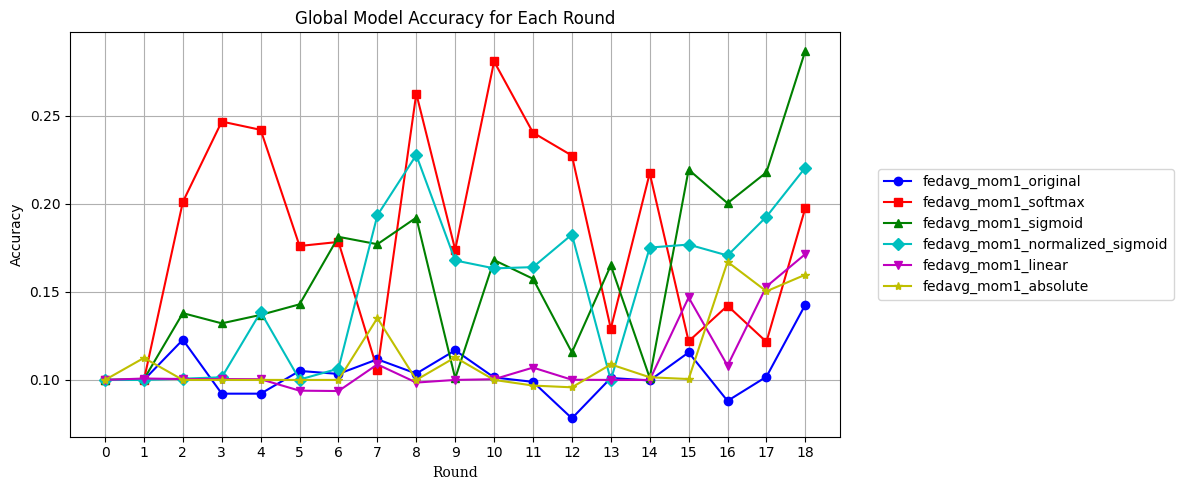

In [17]:
plot_accuracy_per_round(fedavg_mom1_results)

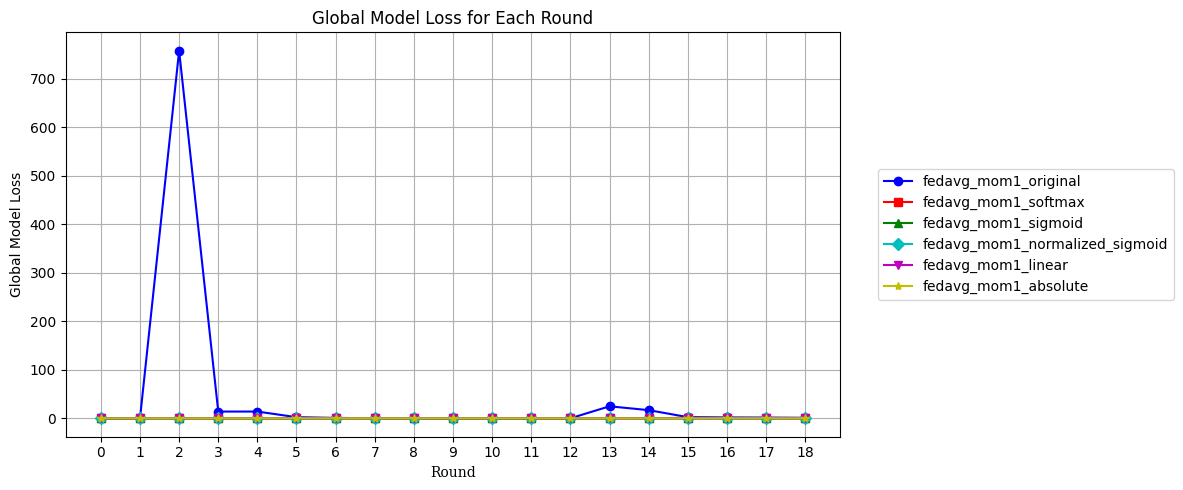

In [18]:
plot_loss_per_round(fedavg_mom1_results)

### Parameter Differences per Round













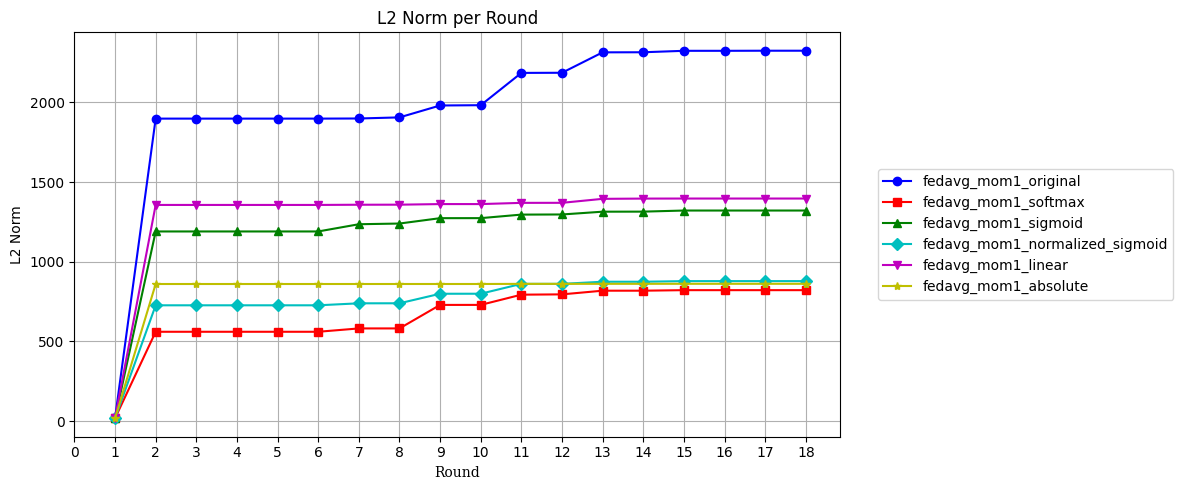

In [19]:
plot_l2_norm_per_round(fedavg_mom1_results)

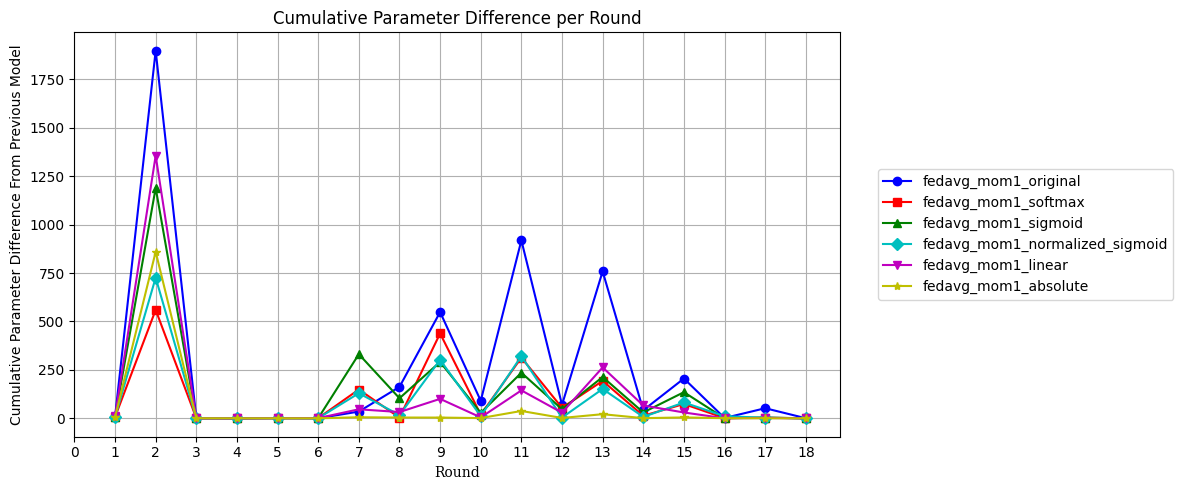

In [20]:
plot_parameter_difference_per_round(fedavg_mom1_results)

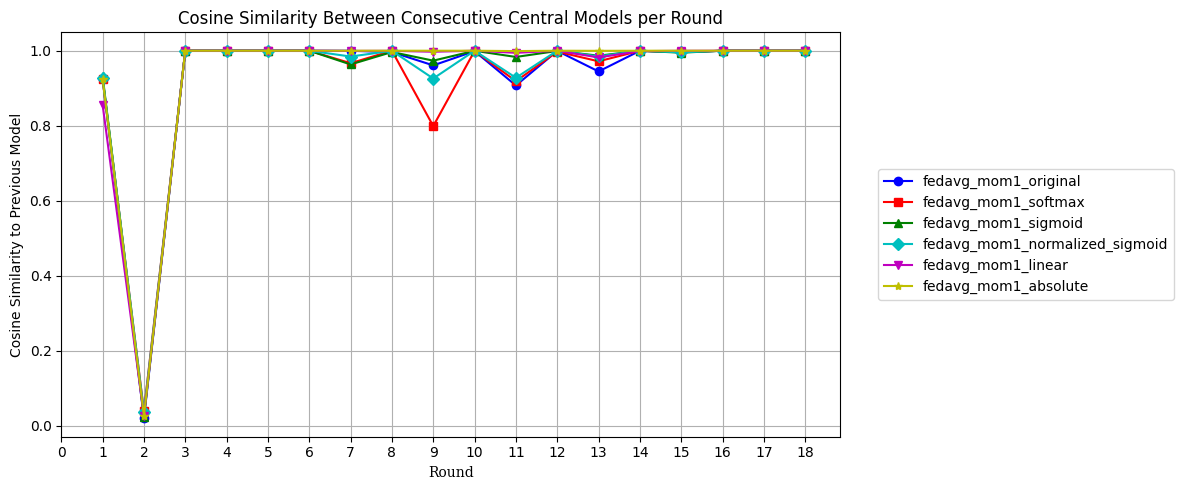

In [21]:
plot_cosine_similarity_per_round(fedavg_mom1_results)

### Save the results to pickle files

In [27]:
pickle.dump(fedavg_mom1_results, open(f"{experiment_type}_fedavgmom1.pkl", 'wb'))
all_results.update(fedavg_mom1_results)

# Pseudo Gradient

## Fed PseudoGradient Part Avg

In [61]:
from src.FedPseudoGradient.FedAvg.client import get_fedpseudo_gradient_avg_part_client_fn
from src.FedPseudoGradient.FedAvg.strategy import FedPseudoGradientPartAvg

In [62]:
fedpseudo_gradient_avg_part_client_fn = get_fedpseudo_gradient_avg_part_client_fn(load_datasets)
client = ClientApp(client_fn=fedpseudo_gradient_avg_part_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
fedpseudo_gradient_avg_part_strategy= FedPseudoGradientPartAvg(evaluate_fn=evaluate_fn)

def fedpseudo_gradient_avg_part_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=fedpseudo_gradient_avg_part_strategy,
    )

server = ServerApp(server_fn=fedpseudo_gradient_avg_part_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0722, Accuracy: 0.1000


(ClientAppActor pid=35238) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=35238)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=35238) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=35238) [Client 2] initialized
(ClientAppActor pid=35238) [Client 2] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=35238) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=35238) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=35238) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=35238) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=35238) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=35238) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=35238) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=35238) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=35238) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=35238) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=35238) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=35238) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=35238) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=35238) Layer 13 (fc5.bias) is trainable


(ClientAppActor pid=35238) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=35238)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]
(ClientAppActor pid=35237) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=35238) [Client 1] initialized
(ClientAppActor pid=35238) [Client 1] evaluate
(ClientAppActor pid=35237) Epoch 8: train loss 0.037876278162002563, accuracy 0.5525052505250525 [repeated 3x across cluster]
(ClientAppActor pid=35237) [Client 4] get_parameters


(ClientAppActor pid=35235) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.
(ClientAppActor pid=35236) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=35236)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=35236) [Client 3] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=35236) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=35236) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=35236) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=35236) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=35236) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=35236) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=35236) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=35236) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=35236) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=35236) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=35236) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=35236) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=35236) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=35236) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=35236) Layer 14 (fc7.weight) i

(ClientAppActor pid=35234) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 2x across cluster]
(ClientAppActor pid=35237) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=35237)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


total size: 7449672
Number of parameters after update: 154486
  Evaluation results - Loss: 0.0454, Accuracy: 0.5271
(ClientAppActor pid=35233) [Client 0] initialized
(ClientAppActor pid=35233) [Client 0] evaluate
(ClientAppActor pid=35236) Epoch 8: train loss 0.022101396694779396, accuracy 0.7382238223822383 [repeated 11x across cluster]
(ClientAppActor pid=35236) [Client 3] get_parameters [repeated 5x across cluster]


(ClientAppActor pid=35236) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.
(ClientAppActor pid=35233) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=35233)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=35238) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=35238)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=35238) [Client 2] fit, config: {'trainable_layers': 0, 'updated_layers': -1}
(ClientAppActor pid=35238) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=35238) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=35238) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=35238) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=35238) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=35238) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=35238) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=35238) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=35238) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=35238) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=35238) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=35238) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=35238) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=35238) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=35238) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=35238) L

(ClientAppActor pid=35238) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=35238)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=35238) [Client 3] initialized
(ClientAppActor pid=35238) [Client 3] evaluate
(ClientAppActor pid=35234) Epoch 8: train loss 0.039982933551073074, accuracy 0.5535553555355536 [repeated 11x across cluster]
(ClientAppActor pid=35234) [Client 3] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=35233) [Client 1] fit, config: {'trainable_layers': 0, 'updated_layers': 0}
(ClientAppActor pid=35233) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=35233) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=35233) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=35233) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=35233) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=35233) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=35233) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=35233) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=35233) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=35233) Layer 9 (fc3.bias) is frozen
(ClientAppActo

(ClientAppActor pid=35237) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=35237)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=35237) [Client 4] initialized
(ClientAppActor pid=35237) [Client 4] evaluate
(ClientAppActor pid=35238) Epoch 8: train loss 0.03960317373275757, accuracy 0.5604560456045604 [repeated 11x across cluster]
(ClientAppActor pid=35238) [Client 3] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=35234) [Client 4] fit, config: {'trainable_layers': 1, 'updated_layers': 0}
(ClientAppActor pid=35234) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=35234) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=35234) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=35234) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=35234) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=35234) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=35234) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=35234) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=35234) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=35234) Layer 9 (fc3.bias) is frozen
(ClientAppActor

(ClientAppActor pid=35237) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=35237)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=35237) [Client 4] initialized
(ClientAppActor pid=35237) [Client 4] evaluate
(ClientAppActor pid=35233) Epoch 8: train loss 0.036618586629629135, accuracy 0.5821208939553022 [repeated 11x across cluster]
(ClientAppActor pid=35233) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=35234) [Client 5] fit, config: {'trainable_layers': 1, 'updated_layers': 1}
(ClientAppActor pid=35234) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=35234) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=35234) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=35234) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=35234) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=35234) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=35234) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=35234) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=35234) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=35234) Layer 9 (fc3.bias) is frozen
(ClientAppActo

(ClientAppActor pid=35238) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=35238)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=35238) [Client 4] initialized
(ClientAppActor pid=35238) [Client 4] evaluate
(ClientAppActor pid=35233) Epoch 8: train loss 0.03557907044887543, accuracy 0.5883588358835884 [repeated 11x across cluster]
(ClientAppActor pid=35233) [Client 3] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=35238) [Client 4] fit, config: {'trainable_layers': 2, 'updated_layers': 1}
(ClientAppActor pid=35238) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=35238) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=35238) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=35238) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=35238) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=35238) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=35238) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=35238) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=35238) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=35238) Layer 9 (fc3.bias) is frozen
(ClientAppActor

(ClientAppActor pid=35236) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=35236)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=35236) [Client 0] initialized
(ClientAppActor pid=35236) [Client 0] evaluate
(ClientAppActor pid=35236) Epoch 8: train loss 0.013606644235551357, accuracy 0.9023402340234024 [repeated 6x across cluster]
(ClientAppActor pid=35236) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=35238) [Client 3] fit, config: {'trainable_layers': 2, 'updated_layers': 2}
(ClientAppActor pid=35238) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=35238) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=35238) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=35238) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=35238) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=35238) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=35238) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=35238) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=35238) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=35238) Layer 9 (fc3.bias) is frozen
(ClientAppActor

(ClientAppActor pid=35234) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=35234)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=35234) [Client 4] initialized
(ClientAppActor pid=35234) [Client 4] evaluate
(ClientAppActor pid=35236) Epoch 8: train loss 0.010648705996572971, accuracy 0.9324932493249325 [repeated 10x across cluster]
(ClientAppActor pid=35236) [Client 4] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=35235) [Client 0] fit, config: {'trainable_layers': 3, 'updated_layers': 2}
(ClientAppActor pid=35235) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=35235) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=35235) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=35235) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=35235) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=35235) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=35235) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=35235) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=35235) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=35235) Layer 9 (fc3.bias) is frozen
(ClientAppActo

(ClientAppActor pid=35233) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=35233)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=35233) [Client 1] fit, config: {'trainable_layers': 3, 'updated_layers': 3}
(ClientAppActor pid=35233) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=35233) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=35233) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=35233) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=35233) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=35233) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=35233) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=35233) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=35233) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=35233) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=35233) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=35233) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=35233) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=35233) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=35233) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=35233) La

(ClientAppActor pid=35235) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=35235)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=35236) [Client 4] fit, config: {'trainable_layers': 4, 'updated_layers': 3}
(ClientAppActor pid=35236) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=35236) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=35236) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=35236) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=35236) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=35236) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=35236) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=35236) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=35236) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=35236) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=35236) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=35236) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=35236) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=35236) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=35236) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=35236) La

(ClientAppActor pid=35233) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=35233)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=35233) [Client 3] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=35233) [Client 3] fit, config: {'trainable_layers': 4, 'updated_layers': 4}
(ClientAppActor pid=35233) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=35233) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=35233) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=35233) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=35233) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=35233) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=35233) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=35233) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=35233) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=35233) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=35233) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=35233) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=35233) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=35233) Layer 13 (fc5.bias) is frozen
(Clien

(ClientAppActor pid=35233) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=35233)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=35233) [Client 0] fit, config: {'trainable_layers': 5, 'updated_layers': 4}
(ClientAppActor pid=35233) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=35233) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=35233) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=35233) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=35233) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=35233) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=35233) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=35233) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=35233) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=35233) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=35233) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=35233) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=35233) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=35233) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=35233) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=35233) La

(ClientAppActor pid=35233) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=35233)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=35233) [Client 1] fit, config: {'trainable_layers': 5, 'updated_layers': 5}
(ClientAppActor pid=35233) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=35233) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=35233) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=35233) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=35233) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=35233) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=35233) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=35233) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=35233) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=35233) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=35233) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=35233) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=35233) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=35233) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=35233) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=35233) La

(ClientAppActor pid=35233) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=35233)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=35235) [Client 4] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=35238) [Client 0] fit, config: {'trainable_layers': 6, 'updated_layers': 5}
(ClientAppActor pid=35235) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=35235) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=35235) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=35235) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=35235) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=35235) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=35235) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=35235) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=35235) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=35235) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=35235) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=35235) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=35235) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=35235) Layer 13 (fc5.bias) is trainable
(Clien

(ClientAppActor pid=35236) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=35236)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=35236) [Client 2] initialized
(ClientAppActor pid=35236) [Client 2] evaluate
(ClientAppActor pid=35236) Epoch 8: train loss 0.02582256682217121, accuracy 0.7054147292635369 [repeated 23x across cluster]
(ClientAppActor pid=35236) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=35236) [Client 3] fit, config: {'trainable_layers': 6, 'updated_layers': 6}
(ClientAppActor pid=35236) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=35236) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=35236) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=35236) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=35236) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=35236) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=35236) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=35236) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=35236) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=35236) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=3

(ClientAppActor pid=35234) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=35234)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=35238) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=35238) Epoch 8: train loss 0.02572518214583397, accuracy 0.7086708670867087 [repeated 5x across cluster]
(ClientAppActor pid=35235) [Client 0] fit, config: {'trainable_layers': 7, 'updated_layers': 6}
(ClientAppActor pid=35235) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=35235) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=35235) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=35235) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=35235) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=35235) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=35235) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=35235) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=35235) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=35235) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=35235) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=35235) Layer 11 (fc4.bias) is frozen
(Cl

(ClientAppActor pid=35233) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=35233)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=35235) [Client 5] fit, config: {'trainable_layers': 7, 'updated_layers': 7}
(ClientAppActor pid=35235) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=35235) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=35235) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=35235) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=35235) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=35235) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=35235) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=35235) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=35235) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=35235) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=35235) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=35235) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=35235) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=35235) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=35235) Layer 14 (fc7.weight) is trainable
(ClientAppActor pid=35235) Layer

(ClientAppActor pid=35235) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=35235)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=35234) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=35237) [Client 3] initialized [repeated 5x across cluster]
(ClientAppActor pid=35237) [Client 3] evaluate [repeated 5x across cluster]


(ClientAppActor pid=35237) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=35237)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [63]:
fedpseudo_gradient_avg_part_results=fedpseudo_gradient_avg_part_strategy.get_results()
pseudo_gradient_results['fedpseudo_gradient_avg_part'] = fedpseudo_gradient_avg_part_results

## Summary

Compared to the momentum based strategies, using the average of pseudo-gradients as a model update presents to be more resilient to the data heterogeneity. Although we can still see a clear (much more toned down) fluctuation in both accuracy and loss, there is still an improving general trend for both which means with the more heterogeneous data the model is able to learn as also shown by the increasing L2 norm values.  Furthermore, the parameter differences though follow a similar pattern to the FedPartAvg strategy, the individual data points show that the differences are lower similarly to the cosine similarity between consecutive central models. This is suggest that the model is able to learn and the updates are not as contrasting as the momentum based strategies.

### Accuracy and Loss per Round

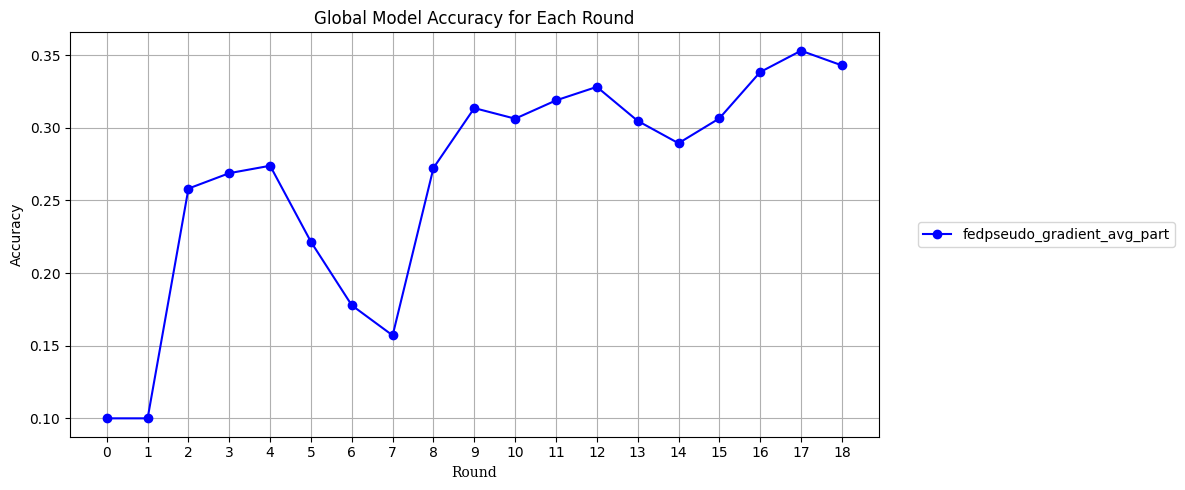

In [22]:
plot_accuracy_per_round(pseudo_gradient_results)

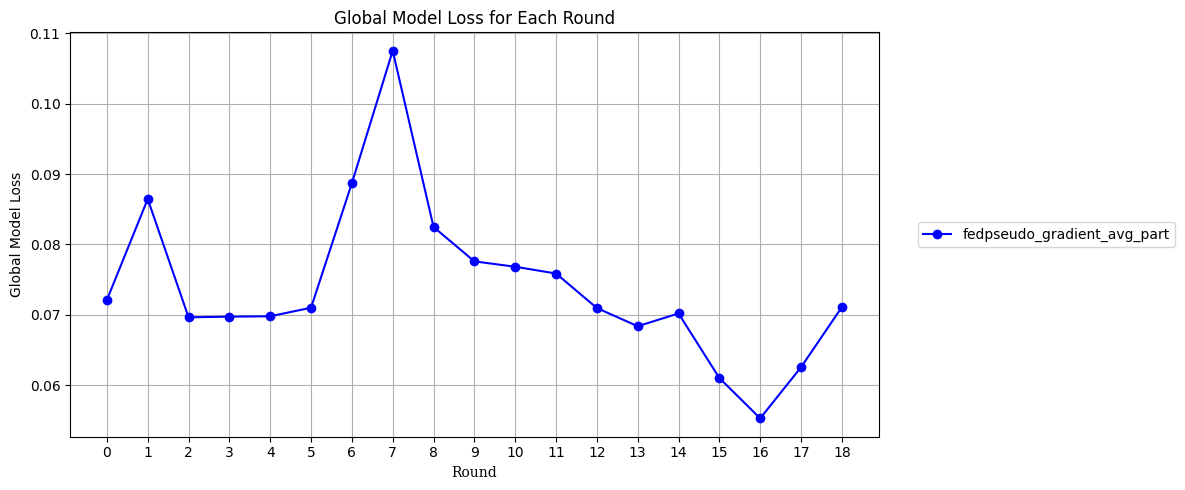

In [23]:
plot_loss_per_round(pseudo_gradient_results)

### Parameter Differences Across Rounds













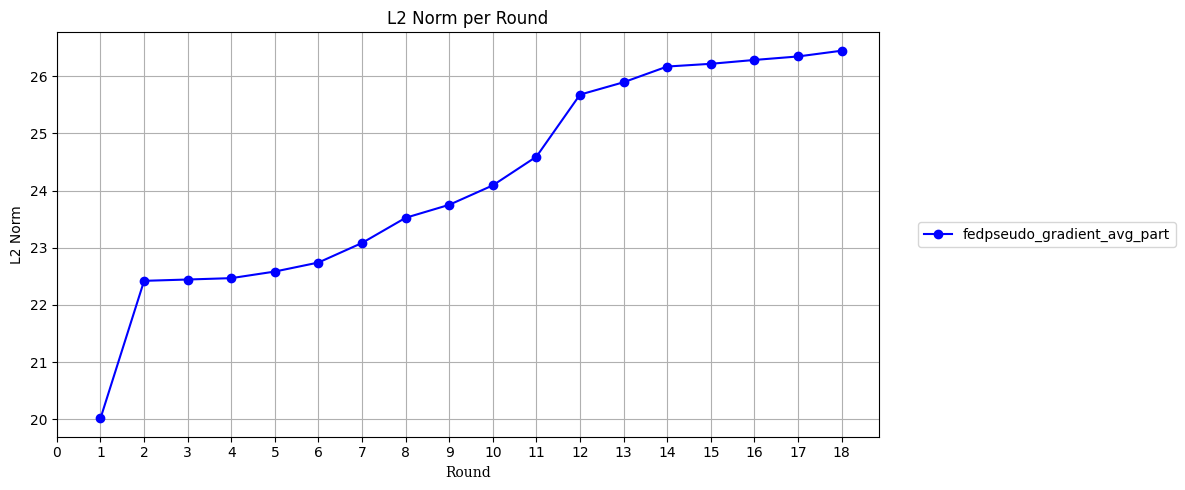

In [24]:
plot_l2_norm_per_round(pseudo_gradient_results)

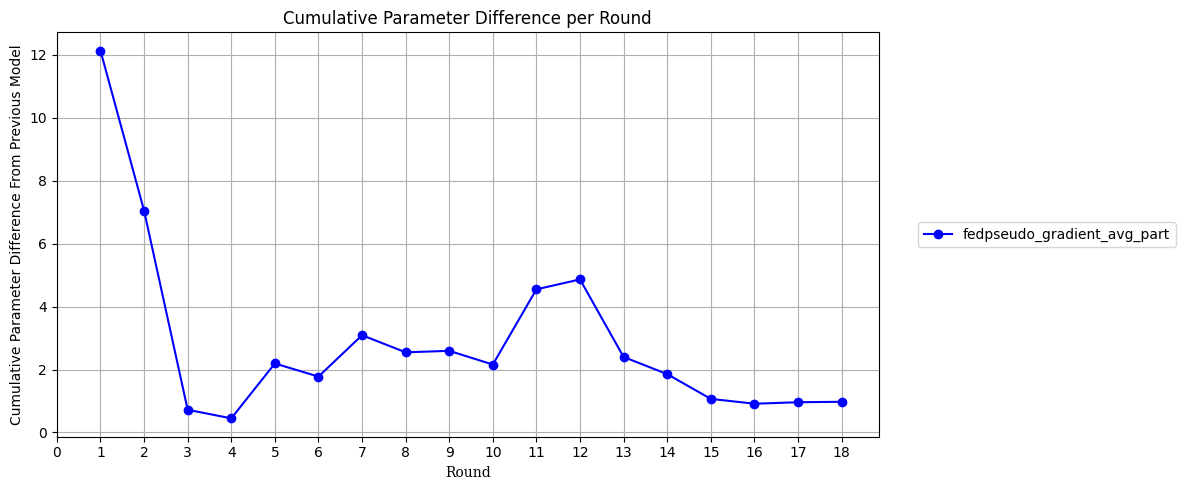

In [25]:
plot_parameter_difference_per_round(pseudo_gradient_results)

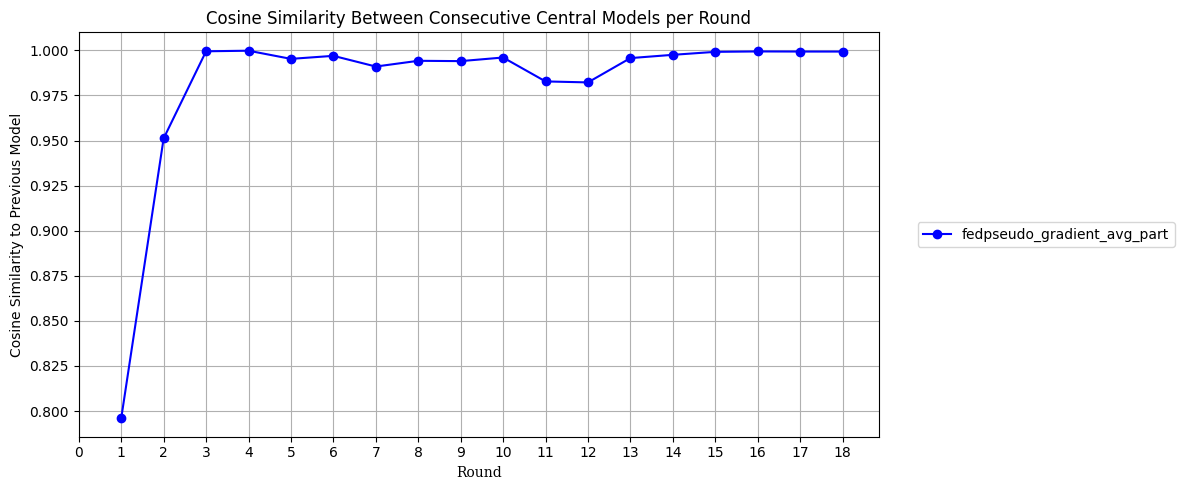

In [26]:
plot_cosine_similarity_per_round(pseudo_gradient_results)

### Save the results to pickle files

In [39]:
pickle.dump(pseudo_gradient_results, open(f"{experiment_type}_pseudogradient.pkl", 'wb'))

all_results.update(pseudo_gradient_results)

# PseudoGradient Similarity (PSAP)

## PseudoGradient Similarity Avg Part (PSAP)

In [47]:
from src.FedPseudoGradientSimilarity.FedAvg.client import get_fedpseudo_gradient_similarity_avg_part_client_fn
from src.FedPseudoGradientSimilarity.FedAvg.strategy import FedPseudoGradientSimilarityPartAvg

### PseudoGradient Similarity Avg Part -  Original Weighting

In [48]:
psap_original_client_fn = get_fedpseudo_gradient_similarity_avg_part_client_fn(load_datasets)
client = ClientApp(client_fn=psap_original_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
psap_original_strategy= FedPseudoGradientSimilarityPartAvg(evaluate_fn=evaluate_fn, aggregate_mode="original")

def psap_original_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=psap_original_strategy,
    )

server = ServerApp(server_fn=psap_original_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000
(ClientAppActor pid=48784) [Client 0] initialized
(ClientAppActor pid=48784) [Client 0] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=48784) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=48784) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=48784) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=48784) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=48784) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=48784) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=48784) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=48784) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=48784) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=48784) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=48784) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=48784) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=48784) Layer 12 (fc5.weight) is trainable
(Clien

(ClientAppActor pid=48784) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=48784)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=48784) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=48784) Epoch 1: train loss 0.04820605367422104, accuracy 0.28854041013269
(ClientAppActor pid=48783) [Client 4] initialized
(ClientAppActor pid=48783) [Client 4] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=48783) Layer 15 (fc7.bias) is trainable [repeated 16x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=48784) Epoch 3: train loss 0.03414357453584671, accuracy 0.5241254523522316 [repeated 4x across cluster]
(ClientAppActor pid=48784) Epoch 5: train loss 0.029048820957541466, accuracy 0.6218335343787696 [repeated 4x across cluster]
(ClientAppActor pid=48784) Epoch 7: train loss 0.025742897763848305, accuracy 0.6784077201447527 [repeated 4x across cluster]
(ClientAppActor pid=48784) [Client 0] get_parameters
total size: 2483224
  Eva

(ClientAppActor pid=48784) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=48784)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]
(ClientAppActor pid=48783) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.
(ClientAppActor pid=48782) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=48779) [Client 3] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=48779) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=48779) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=48779) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=48779) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=48779) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=48779) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=48779) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=48779) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=48779) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=48779) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=48779) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=48779) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=48779) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=48779) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=48779) Layer 14 (fc7.weight) i

(ClientAppActor pid=48779) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=48779)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=48784) Epoch 1: train loss 0.01577579416334629, accuracy 0.7967980295566502
(ClientAppActor pid=48783) [Client 4] fit, config: {'trainable_layers': -1, 'updated_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=48783) Layer 15 (fc7.bias) is trainable [repeated 80x across cluster]
(ClientAppActor pid=48783) [Client 4] initialized [repeated 5x across cluster]
(ClientAppActor pid=48779) Epoch 4: train loss 0.025700928643345833, accuracy 0.7080469962314343 [repeated 13x across cluster]
(ClientAppActor pid=48779) Epoch 7: train loss 0.01841590367257595, accuracy 0.7918421636000886 [repeated 13x across cluster]
(ClientAppActor pid=48779) [Client 3] get_parameters
(ClientAppActor pid=48783) Epoch 5: train loss 0.00864322204142809, accuracy 0.9091769157994324 [repeated 11x across cluster]
(ClientAppActor pid=48784) [Client 5] get_parameters
(ClientAppActor pid=48781) [Client 1] get_parameters
(ClientAppActor pid=48780) Epoch 7: train loss 0.014017289504408836, a

(ClientAppActor pid=48780) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 3x across cluster]
(ClientAppActor pid=48783) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=48783)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


total size: 7449672
  Evaluation results - Loss: 0.0766, Accuracy: 0.2458
(ClientAppActor pid=48781) [Client 4] initialized
(ClientAppActor pid=48781) [Client 4] evaluate
(ClientAppActor pid=48783) [Client 4] get_parameters [repeated 3x across cluster]
(ClientAppActor pid=48783) Epoch 8: train loss 0.005600032862275839, accuracy 0.9398060548722801 [repeated 3x across cluster]


(ClientAppActor pid=48781) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=48781)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=48779) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=48779)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=48784) [Client 0] fit, config: {'trainable_layers': 0, 'updated_layers': -1}
(ClientAppActor pid=48784) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=48784) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=48784) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48784) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48784) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48784) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48784) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48784) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48784) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48784) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=48784) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=48784) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=48784) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=48784) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=48784) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=48784) L

(ClientAppActor pid=48784) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=48784)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=48779) [Client 0] fit, config: {'trainable_layers': 0, 'updated_layers': 0}
(ClientAppActor pid=48779) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=48779) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=48779) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48779) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48779) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48779) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48779) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48779) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48779) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48779) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=48779) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=48779) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=48779) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=48779) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=48779) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=48779) La

(ClientAppActor pid=48781) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48781)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48782) [Client 5] fit, config: {'trainable_layers': 1, 'updated_layers': 0}
(ClientAppActor pid=48782) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48782) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48782) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=48782) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=48782) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48782) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48782) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48782) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48782) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48782) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=48782) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=48782) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=48782) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=48782) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=48782) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=48782) La

(ClientAppActor pid=48784) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48784)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48781) [Client 4] fit, config: {'trainable_layers': 1, 'updated_layers': 1}
(ClientAppActor pid=48781) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48781) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48781) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=48781) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=48781) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48781) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48781) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48781) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48781) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48781) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=48781) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=48781) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=48781) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=48781) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=48781) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=48781) La

(ClientAppActor pid=48784) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=48784) Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Tue Jun 24 02:55:08 2025).
(ClientAppActor pid=48784) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=48784)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=48784) [Client 0] initialized
(ClientAppActor pid=48784) [Client 0] evaluate
(ClientAppActor pid=48781) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=48781) Epoch 8: train loss 0.07432582229375839, accuracy 0.022232734153263954
(ClientAppActor pid=48782) [Client 5] initialized [repeated 2x across cluster]
(ClientAppActor pid=48782) [Client 5] evaluate [repeated 2x across cluster]


(ClientAppActor pid=48782) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=48782)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


(ClientAppActor pid=48779) [Client 4] fit, config: {'trainable_layers': 2, 'updated_layers': 1}
(ClientAppActor pid=48779) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48779) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48779) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48779) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48779) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=48779) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=48779) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48779) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48779) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48779) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=48779) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=48779) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=48779) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=48779) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=48779) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=48779) La

(ClientAppActor pid=48779) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=48779)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=48783) Epoch 1: train loss 0.0435066744685173, accuracy 0.5464420305918865
(ClientAppActor pid=48784) [Client 5] fit, config: {'trainable_layers': 2, 'updated_layers': 1} [repeated 5x across cluster]
(ClientAppActor pid=48784) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=48784) Layer 5 (fc1.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=48784) [Client 5] initialized [repeated 5x across cluster]
(ClientAppActor pid=48782) Epoch 4: train loss 0.06567588448524475, accuracy 0.3096357226792009 [repeated 22x across cluster]
(ClientAppActor pid=48783) [Client 3] get_parameters
(ClientAppActor pid=48779) Epoch 6: train loss 0.061041392385959625, accuracy 0.022350993377483443 [repeated 17x across cluster]
(ClientAppActor pid=48779) [Client 4] get_parameters [repeated 4x across cluster]
total size: 1796448
  Evaluation results - Loss: 0.0792, Accuracy: 0.2182
(ClientAppActor pid=48779) [Client 5] initialized
(ClientAppA

(ClientAppActor pid=48779) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=48779)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=48780) [Client 0] get_parameters
(ClientAppActor pid=48779) [Client 4] fit, config: {'trainable_layers': 2, 'updated_layers': 2}
(ClientAppActor pid=48779) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48779) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48779) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48779) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48779) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=48779) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=48779) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48779) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48779) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48779) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=48779) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=48779) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=48779) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=48779) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=48779) Layer 14

(ClientAppActor pid=48784) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48784)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48779) Epoch 8: train loss 0.056392062455415726, accuracy 0.022232734153263954
(ClientAppActor pid=48782) [Client 1] fit, config: {'trainable_layers': 3, 'updated_layers': 2}
(ClientAppActor pid=48782) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48782) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48782) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48782) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48782) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48782) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48782) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=48782) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=48782) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48782) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=48782) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=48782) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=48782) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=48782) Layer 13 (fc5.bias)

(ClientAppActor pid=48784) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48784)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48784) Epoch 8: train loss 0.04404670372605324, accuracy 0.33325449385052036
(ClientAppActor pid=48781) [Client 5] fit, config: {'trainable_layers': 3, 'updated_layers': 3}
(ClientAppActor pid=48781) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48781) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48781) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48781) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48781) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48781) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48781) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=48781) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=48781) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48781) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=48781) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=48781) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=48781) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=48781) Layer 13 (fc5.bias) i

(ClientAppActor pid=48783) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48783)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48780) Epoch 8: train loss 0.04251262545585632, accuracy 0.3491012298959319
(ClientAppActor pid=48779) [Client 2] fit, config: {'trainable_layers': 4, 'updated_layers': 3}
(ClientAppActor pid=48779) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48779) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48779) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48779) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48779) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48779) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48779) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48779) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48779) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=48779) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=48779) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=48779) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=48779) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=48779) Layer 13 (fc5.bias) is

(ClientAppActor pid=48781) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48781)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48780) [Client 0] get_parameters
(ClientAppActor pid=48781) [Client 5] fit, config: {'trainable_layers': 4, 'updated_layers': 4}
(ClientAppActor pid=48781) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48781) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48781) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48781) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48781) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48781) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48781) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48781) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48781) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=48781) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=48781) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=48781) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=48781) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=48781) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=48781) Layer 14

(ClientAppActor pid=48781) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48781)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48783) [Client 2] fit, config: {'trainable_layers': 5, 'updated_layers': 4}
(ClientAppActor pid=48783) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48783) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48783) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48783) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48783) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48783) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48783) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48783) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48783) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48783) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=48783) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=48783) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=48783) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=48783) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=48783) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=48783) La

(ClientAppActor pid=48780) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48780)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48784) [Client 3] fit, config: {'trainable_layers': 5, 'updated_layers': 5}
(ClientAppActor pid=48779) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48779) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48779) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48779) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48779) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48779) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48779) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48779) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48779) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48779) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=48779) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=48779) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=48779) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=48779) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=48779) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=48779) La

(ClientAppActor pid=48779) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48779)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48783) [Client 1] fit, config: {'trainable_layers': 6, 'updated_layers': 5}
(ClientAppActor pid=48783) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48783) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48783) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48783) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48783) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48783) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48783) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48783) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48783) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48783) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=48783) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=48783) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=48783) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=48783) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=48783) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=48783) La

(ClientAppActor pid=48784) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48784)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48781) [Client 4] fit, config: {'trainable_layers': 6, 'updated_layers': 6}
(ClientAppActor pid=48781) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48781) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48781) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48781) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48781) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48781) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48781) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48781) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48781) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48781) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=48781) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=48781) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=48781) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=48781) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=48781) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=48781) La

(ClientAppActor pid=48784) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48784)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48783) [Client 0] get_parameters
(ClientAppActor pid=48781) [Client 0] fit, config: {'trainable_layers': 7, 'updated_layers': 6}
(ClientAppActor pid=48781) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48781) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48781) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48781) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48781) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48781) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48781) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48781) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48781) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48781) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=48781) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=48781) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=48781) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=48781) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=48781) Layer 14 (fc7.

(ClientAppActor pid=48779) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48779)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48781) [Client 3] fit, config: {'trainable_layers': 7, 'updated_layers': 7}
(ClientAppActor pid=48781) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48781) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48781) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48781) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48781) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48781) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48781) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48781) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48781) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48781) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=48781) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=48781) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=48781) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=48781) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=48781) Layer 14 (fc7.weight) is trainable
(ClientAppActor pid=48781) Layer

(ClientAppActor pid=48779) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48779)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48780) [Client 0] initialized [repeated 5x across cluster]
(ClientAppActor pid=48780) [Client 0] evaluate [repeated 5x across cluster]


(ClientAppActor pid=48780) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=48780)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [49]:
psap_original_results=psap_original_strategy.get_results()
pseudo_gradient_similarity_avg_results['psap_original'] = psap_original_results

### PseudoGradient Similarity Avg Part -  Softmax Weighting

In [50]:
psap_softmax_client_fn = get_fedpseudo_gradient_similarity_avg_part_client_fn(load_datasets)
client = ClientApp(client_fn=psap_softmax_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
psap_softmax_strategy= FedPseudoGradientSimilarityPartAvg(evaluate_fn=evaluate_fn, aggregate_mode="softmax")

def psap_softmax_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=psap_softmax_strategy,
    )

server = ServerApp(server_fn=psap_softmax_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000


(ClientAppActor pid=59510) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=59510)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=59510) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=59510) [Client 5] initialized
(ClientAppActor pid=59510) [Client 5] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=59510) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=59510) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=59510) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=59510) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=59510) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=59510) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=59510) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=59510) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=59510) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=59510) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=59510) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=59510) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=59510) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=59510) Layer 13 (fc5.bias) is trainable


(ClientAppActor pid=59512) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=59512)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
(ClientAppActor pid=59511) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 5x across cluster]


(ClientAppActor pid=59513) [Client 1] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=59513) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=59513) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=59513) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=59513) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=59513) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=59513) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=59513) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=59513) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=59513) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=59513) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=59513) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=59513) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=59513) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=59513) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=59513) Layer 14 (fc7.weight) i

(ClientAppActor pid=59512) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=59512)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=59512) [Client 0] initialized
(ClientAppActor pid=59512) [Client 0] evaluate
(ClientAppActor pid=59512) [Client 4] get_parameters [repeated 3x across cluster]
(ClientAppActor pid=59512) Epoch 8: train loss 0.007641139905899763, accuracy 0.9173368022705771 [repeated 4x across cluster]
(ClientAppActor pid=59513) [Client 1] fit, config: {'trainable_layers': 0, 'updated_layers': -1}
(ClientAppActor pid=59513) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=59513) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=59513) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=59513) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=59513) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=59513) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=59513) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=59513) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=59513) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=59513) Layer 9 (fc3.bias) is frozen
(ClientAppActo

(ClientAppActor pid=59513) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=59513)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=59510) [Client 1] fit, config: {'trainable_layers': 0, 'updated_layers': 0}
(ClientAppActor pid=59510) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=59510) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=59510) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=59510) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=59510) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=59510) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=59510) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=59510) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=59510) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=59510) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=59510) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=59510) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=59510) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=59510) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=59510) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=59510) La

(ClientAppActor pid=59512) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=59512)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=59513) [Client 0] fit, config: {'trainable_layers': 1, 'updated_layers': 0}
(ClientAppActor pid=59513) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=59513) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=59513) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=59513) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=59513) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=59513) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=59513) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=59513) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=59513) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=59513) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=59513) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=59513) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=59513) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=59513) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=59513) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=59513) La

(ClientAppActor pid=59512) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=59512)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=59511) [Client 4] fit, config: {'trainable_layers': 1, 'updated_layers': 1}
(ClientAppActor pid=59511) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=59511) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=59511) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=59511) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=59511) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=59511) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=59511) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=59511) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=59511) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=59511) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=59511) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=59511) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=59511) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=59511) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=59511) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=59511) La

(ClientAppActor pid=59515) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=59515)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=59513) Epoch 8: train loss 0.03598533570766449, accuracy 0.5447527141133897
(ClientAppActor pid=59512) [Client 3] fit, config: {'trainable_layers': 2, 'updated_layers': 1}
(ClientAppActor pid=59512) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=59512) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=59512) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=59512) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=59512) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=59512) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=59512) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=59512) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=59512) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=59512) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=59512) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=59512) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=59512) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=59512) Layer 13 (fc5.bias) is

(ClientAppActor pid=59511) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=59511)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=59511) [Client 2] fit, config: {'trainable_layers': 2, 'updated_layers': 2}
(ClientAppActor pid=59511) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=59511) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=59511) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=59511) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=59511) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=59511) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=59511) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=59511) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=59511) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=59511) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=59511) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=59511) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=59511) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=59511) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=59511) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=59511) La

(ClientAppActor pid=59511) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=59511)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=59512) Epoch 8: train loss 0.06541075557470322, accuracy 0.2612346263008515
(ClientAppActor pid=59513) [Client 5] fit, config: {'trainable_layers': 3, 'updated_layers': 2}
(ClientAppActor pid=59513) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=59513) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=59513) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=59513) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=59513) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=59513) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=59513) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=59513) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=59513) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=59513) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=59513) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=59513) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=59513) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=59513) Layer 13 (fc5.bias) is

(ClientAppActor pid=59515) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=59515)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=59515) [Client 2] initialized
(ClientAppActor pid=59515) [Client 2] evaluate
(ClientAppActor pid=59511) Epoch 8: train loss 0.05321246013045311, accuracy 0.3424787133396405 [repeated 9x across cluster]
(ClientAppActor pid=59511) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=59514) [Client 0] fit, config: {'trainable_layers': 3, 'updated_layers': 3}
(ClientAppActor pid=59514) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=59514) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=59514) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=59514) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=59514) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=59514) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=59514) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=59514) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=59514) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=59514) Layer 9 (fc3.bias) is frozen
(ClientAppActor 

(ClientAppActor pid=59511) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=59511)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=59511) [Client 3] fit, config: {'trainable_layers': 4, 'updated_layers': 3}
(ClientAppActor pid=59511) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=59511) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=59511) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=59511) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=59511) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=59511) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=59511) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=59511) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=59511) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=59511) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=59511) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=59511) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=59511) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=59511) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=59511) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=59511) La

(ClientAppActor pid=59515) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=59515)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=59515) [Client 5] fit, config: {'trainable_layers': 4, 'updated_layers': 4}
(ClientAppActor pid=59515) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=59515) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=59515) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=59515) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=59515) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=59515) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=59515) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=59515) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=59515) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=59515) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=59515) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=59515) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=59515) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=59515) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=59515) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=59515) La

(ClientAppActor pid=59510) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=59510)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=59510) [Client 2] initialized
(ClientAppActor pid=59510) [Client 2] evaluate
(ClientAppActor pid=59513) Epoch 8: train loss 0.030505578964948654, accuracy 0.7576868495742668 [repeated 9x across cluster]
(ClientAppActor pid=59513) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=59511) [Client 0] fit, config: {'trainable_layers': 5, 'updated_layers': 4}
(ClientAppActor pid=59511) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=59511) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=59511) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=59511) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=59511) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=59511) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=59511) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=59511) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=59511) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=59511) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=5

(ClientAppActor pid=59515) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=59515)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=59515) [Client 2] fit, config: {'trainable_layers': 5, 'updated_layers': 5}
(ClientAppActor pid=59515) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=59515) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=59515) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=59515) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=59515) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=59515) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=59515) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=59515) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=59515) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=59515) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=59515) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=59515) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=59515) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=59515) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=59515) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=59515) La

(ClientAppActor pid=59515) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=59515)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=59513) [Client 4] get_parameters
(ClientAppActor pid=59514) [Client 1] fit, config: {'trainable_layers': 6, 'updated_layers': 5}
(ClientAppActor pid=59514) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=59514) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=59514) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=59514) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=59514) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=59514) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=59514) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=59514) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=59514) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=59514) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=59514) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=59514) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=59514) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=59514) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=59514) Layer 14

(ClientAppActor pid=59513) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=59513)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=59515) [Client 2] fit, config: {'trainable_layers': 6, 'updated_layers': 6}
(ClientAppActor pid=59515) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=59515) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=59515) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=59515) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=59515) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=59515) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=59515) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=59515) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=59515) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=59515) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=59515) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=59515) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=59515) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=59515) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=59515) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=59515) La

(ClientAppActor pid=59512) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=59512)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=59515) [Client 3] fit, config: {'trainable_layers': 7, 'updated_layers': 6}
(ClientAppActor pid=59515) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=59515) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=59515) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=59515) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=59515) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=59515) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=59515) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=59515) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=59515) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=59515) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=59515) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=59515) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=59515) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=59515) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=59515) Layer 14 (fc7.weight) is trainable
(ClientAppActor pid=59515) Layer

(ClientAppActor pid=59513) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=59513)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=59515) [Client 3] fit, config: {'trainable_layers': 7, 'updated_layers': 7}
(ClientAppActor pid=59515) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=59515) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=59515) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=59515) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=59515) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=59515) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=59515) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=59515) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=59515) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=59515) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=59515) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=59515) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=59515) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=59515) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=59515) Layer 14 (fc7.weight) is trainable
(ClientAppActor pid=59515) Layer

(ClientAppActor pid=59515) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=59515)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=59513) [Client 4] initialized [repeated 5x across cluster]
(ClientAppActor pid=59513) [Client 4] evaluate [repeated 5x across cluster]


(ClientAppActor pid=59513) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=59513)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [51]:
psap_softmax_results=psap_softmax_strategy.get_results()
pseudo_gradient_similarity_avg_results['psap_softmax'] = psap_softmax_results

### PseudoGradient Similarity Avg Part -  Sigmoid Weighting

In [52]:
psap_sigmoid_client_fn = get_fedpseudo_gradient_similarity_avg_part_client_fn(load_datasets)
client = ClientApp(client_fn=psap_sigmoid_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
psap_sigmoid_strategy= FedPseudoGradientSimilarityPartAvg(evaluate_fn=evaluate_fn, aggregate_mode="sigmoid")

def psap_sigmoid_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=psap_sigmoid_strategy,
    )

server = ServerApp(server_fn=psap_sigmoid_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000
(ClientAppActor pid=69812) [Client 1] initialized
(ClientAppActor pid=69812) [Client 1] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=69812) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=69812) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=69812) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=69812) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=69812) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=69812) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=69812) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=69812) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=69812) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=69812) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=69812) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=69812) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=69812) Layer 12 (fc5.weight) is trainable
(Clien

(ClientAppActor pid=69812) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=69812)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=69812) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=69811) Epoch 1: train loss 0.055002469569444656, accuracy 0.3409443582354245
(ClientAppActor pid=69811) [Client 3] initialized
(ClientAppActor pid=69811) [Client 3] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=69811) Layer 15 (fc7.bias) is trainable [repeated 16x across cluster]
(ClientAppActor pid=69812) Epoch 3: train loss 0.015314706601202488, accuracy 0.8419506462984724 [repeated 6x across cluster]
(ClientAppActor pid=69811) [Client 3] get_parameters
(ClientAppActor pid=69811) Epoch 8: train loss 0.03026735596358776, accuracy 0.6570605187319885 [repeated 6x across cluster]
(ClientAppActor pid=69812) [Client 1] get_parameters
(ClientAppActor pid=69812) Epoch 8: train loss 0.012168795801699162, accuracy 0.8650117508813161 [repeated 3x across cluster]
total size: 2483224
  Evaluation results - Loss: 0.0825, Accuracy: 0.1000


(ClientAppActor pid=69811) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=69811)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]
(ClientAppActor pid=69811) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=69811) [Client 1] initialized
(ClientAppActor pid=69811) [Client 1] evaluate


(ClientAppActor pid=69807) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.
(ClientAppActor pid=69807) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=69807)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=69807) [Client 4] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=69807) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=69807) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=69807) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=69807) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=69807) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=69807) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=69807) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=69807) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=69807) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=69807) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=69807) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=69807) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=69807) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=69807) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=69807) Layer 14 (fc7.weight) i

(ClientAppActor pid=69809) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 3x across cluster]
(ClientAppActor pid=69812) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=69812)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=69809) [Client 3] get_parameters
(ClientAppActor pid=69807) Epoch 5: train loss 0.012213343754410744, accuracy 0.8667218543046358 [repeated 12x across cluster]
(ClientAppActor pid=69811) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=69810) Epoch 7: train loss 0.02044263854622841, accuracy 0.7531966224366707 [repeated 8x across cluster]
total size: 7449672
  Evaluation results - Loss: 0.0696, Accuracy: 0.2493


(ClientAppActor pid=69811) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=69811)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=69812) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=69812)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=69811) [Client 2] initialized
(ClientAppActor pid=69811) [Client 2] evaluate
(ClientAppActor pid=69807) [Client 4] get_parameters [repeated 3x across cluster]
(ClientAppActor pid=69807) Epoch 8: train loss 0.009578785859048367, accuracy 0.8975875118259224 [repeated 3x across cluster]
(ClientAppActor pid=69811) [Client 0] fit, config: {'trainable_layers': 0, 'updated_layers': -1}
(ClientAppActor pid=69811) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=69811) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=69811) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=69811) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=69811) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=69811) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=69811) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=69811) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=69811) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=69811) Layer 9 (fc3.bias) is frozen
(ClientAppActo

(ClientAppActor pid=69809) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=69809)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=69809) [Client 3] initialized
(ClientAppActor pid=69809) [Client 3] evaluate
(ClientAppActor pid=69812) [Client 4] get_parameters [repeated 3x across cluster]
(ClientAppActor pid=69812) Epoch 8: train loss 0.07961773127317429, accuracy 0.015728476821192054 [repeated 2x across cluster]
(ClientAppActor pid=69812) [Client 0] fit, config: {'trainable_layers': 0, 'updated_layers': 0}
(ClientAppActor pid=69812) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=69812) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=69812) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=69812) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=69812) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=69812) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=69812) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=69812) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=69812) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=69812) Layer 9 (fc3.bias) is frozen
(ClientAppActo

(ClientAppActor pid=69807) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=69807)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=69807) [Client 0] initialized
(ClientAppActor pid=69807) [Client 0] evaluate
(ClientAppActor pid=69808) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=69808) Epoch 8: train loss 0.07986024767160416, accuracy 0.014900662251655629 [repeated 2x across cluster]
(ClientAppActor pid=69812) [Client 2] fit, config: {'trainable_layers': 1, 'updated_layers': 0}
(ClientAppActor pid=69811) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=69811) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=69811) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=69811) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=69811) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=69811) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=69811) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=69811) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=69811) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=69811) Layer 9 (fc3.bias) is frozen
(ClientAppActo

(ClientAppActor pid=69811) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=69811)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=69811) [Client 5] initialized
(ClientAppActor pid=69811) [Client 5] evaluate
(ClientAppActor pid=69810) [Client 4] get_parameters [repeated 3x across cluster]
(ClientAppActor pid=69810) Epoch 8: train loss 0.07488652318716049, accuracy 0.11542100283822138
(ClientAppActor pid=69809) [Client 0] fit, config: {'trainable_layers': 1, 'updated_layers': 1}
(ClientAppActor pid=69809) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=69809) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=69809) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=69809) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=69809) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=69809) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=69809) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=69809) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=69809) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=69809) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=69809) Layer 10 (fc4.wei

(ClientAppActor pid=69809) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=69809)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=69809) [Client 1] initialized
(ClientAppActor pid=69809) [Client 1] evaluate
(ClientAppActor pid=69812) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=69812) Epoch 8: train loss 0.07409773021936417, accuracy 0.1434484389782403
(ClientAppActor pid=69807) [Client 0] fit, config: {'trainable_layers': 2, 'updated_layers': 1}
(ClientAppActor pid=69807) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=69807) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=69807) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=69807) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=69807) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=69807) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=69807) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=69807) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=69807) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=69807) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=69807) Layer 10 (fc4.weig

(ClientAppActor pid=69807) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=69807)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=69807) [Client 4] initialized
(ClientAppActor pid=69807) [Client 4] evaluate
(ClientAppActor pid=69812) Epoch 8: train loss 0.06113897264003754, accuracy 0.3586802270577105 [repeated 9x across cluster]
(ClientAppActor pid=69812) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=69812) [Client 5] fit, config: {'trainable_layers': 2, 'updated_layers': 2}
(ClientAppActor pid=69812) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=69812) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=69812) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=69812) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=69812) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=69812) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=69812) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=69812) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=69812) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=69812) Layer 9 (fc3.bias) is frozen
(ClientAppActor 

(ClientAppActor pid=69810) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 10x across cluster]
(ClientAppActor pid=69810)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 10x across cluster]


(ClientAppActor pid=69810) [Client 2] initialized [repeated 10x across cluster]
(ClientAppActor pid=69809) [Client 0] evaluate [repeated 5x across cluster]
(ClientAppActor pid=69812) Epoch 1: train loss 0.018653417006134987, accuracy 0.7701149425287356
(ClientAppActor pid=69807) [Client 3] fit, config: {'trainable_layers': 2, 'updated_layers': 2} [repeated 5x across cluster]
(ClientAppActor pid=69807) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=69807) Layer 5 (fc1.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=69807) [Client 3] initialized
(ClientAppActor pid=69812) Epoch 5: train loss 0.012299166060984135, accuracy 0.8676108374384236 [repeated 18x across cluster]
(ClientAppActor pid=69812) [Client 5] get_parameters
(ClientAppActor pid=69811) Epoch 6: train loss 0.049994468688964844, accuracy 0.3729435957696827 [repeated 16x across cluster]
(ClientAppActor pid=69810) [Client 2] get_parameters [repeated 3x across cluster]
(Client

(ClientAppActor pid=69809) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=69809)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


(ClientAppActor pid=69807) [Client 1] initialized
(ClientAppActor pid=69807) [Client 1] evaluate
(ClientAppActor pid=69808) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=69812) [Client 3] fit, config: {'trainable_layers': 3, 'updated_layers': 2}
(ClientAppActor pid=69812) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=69812) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=69812) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=69812) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=69812) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=69812) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=69812) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=69812) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=69812) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=69812) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=69812) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=69812) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=69812

(ClientAppActor pid=69809) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=69809)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=69809) [Client 1] initialized
(ClientAppActor pid=69809) [Client 1] evaluate
(ClientAppActor pid=69811) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=69811) [Client 4] fit, config: {'trainable_layers': 3, 'updated_layers': 3}
(ClientAppActor pid=69811) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=69811) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=69811) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=69811) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=69811) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=69811) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=69811) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=69811) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=69811) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=69811) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=69811) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=69811) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=69811

(ClientAppActor pid=69809) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=69809)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=69809) [Client 2] initialized
(ClientAppActor pid=69809) [Client 2] evaluate
(ClientAppActor pid=69811) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=69807) [Client 4] fit, config: {'trainable_layers': 4, 'updated_layers': 3}
(ClientAppActor pid=69811) Epoch 8: train loss 0.05528837814927101, accuracy 0.3509933774834437
(ClientAppActor pid=69810) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=69810) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=69810) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=69810) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=69810) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=69810) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=69810) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=69810) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=69810) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=69810) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=69810) Layer 10 (fc4.weig

(ClientAppActor pid=69811) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=69811)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=69811) [Client 2] initialized
(ClientAppActor pid=69811) [Client 2] evaluate
(ClientAppActor pid=69808) Epoch 8: train loss 0.028647899627685547, accuracy 0.6200241254523522 [repeated 9x across cluster]
(ClientAppActor pid=69808) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=69808) [Client 4] fit, config: {'trainable_layers': 4, 'updated_layers': 4}
(ClientAppActor pid=69808) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=69808) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=69808) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=69808) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=69808) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=69808) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=69808) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=69808) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=69808) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=69808) Layer 9 (fc3.bias) is trainable
(ClientAppActor

(ClientAppActor pid=69808) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=69808)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=69809) [Client 1] fit, config: {'trainable_layers': 5, 'updated_layers': 4}
(ClientAppActor pid=69807) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=69807) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=69807) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=69807) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=69807) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=69807) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=69807) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=69807) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=69807) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=69807) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=69807) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=69807) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=69807) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=69807) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=69807) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=69807) La

(ClientAppActor pid=69810) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=69810)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=69810) [Client 5] initialized
(ClientAppActor pid=69810) [Client 5] evaluate
(ClientAppActor pid=69811) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=69811) Epoch 8: train loss 0.0172104611992836, accuracy 0.8198912015137181
(ClientAppActor pid=69811) [Client 5] fit, config: {'trainable_layers': 5, 'updated_layers': 5}
(ClientAppActor pid=69811) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=69811) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=69811) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=69811) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=69811) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=69811) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=69811) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=69811) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=69811) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=69811) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=69811) Layer 10 (fc4.weight) is 

(ClientAppActor pid=69807) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=69807)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=69807) [Client 3] initialized
(ClientAppActor pid=69807) [Client 3] evaluate
(ClientAppActor pid=69808) Epoch 8: train loss 0.017091594636440277, accuracy 0.8190633869441817 [repeated 9x across cluster]
(ClientAppActor pid=69808) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=69807) [Client 5] fit, config: {'trainable_layers': 6, 'updated_layers': 5}
(ClientAppActor pid=69807) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=69807) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=69807) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=69807) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=69807) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=69807) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=69807) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=69807) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=69807) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=69807) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=6

(ClientAppActor pid=69809) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=69809)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=69807) [Client 3] initialized
(ClientAppActor pid=69807) [Client 3] evaluate
(ClientAppActor pid=69808) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=69807) [Client 1] fit, config: {'trainable_layers': 6, 'updated_layers': 6}
(ClientAppActor pid=69807) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=69807) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=69807) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=69807) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=69807) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=69807) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=69807) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=69807) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=69807) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=69807) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=69807) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=69807) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=69807) Laye

(ClientAppActor pid=69812) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=69812)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=69807) [Client 5] fit, config: {'trainable_layers': 7, 'updated_layers': 6}
(ClientAppActor pid=69807) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=69807) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=69807) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=69807) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=69807) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=69807) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=69807) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=69807) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=69807) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=69807) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=69807) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=69807) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=69807) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=69807) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=69807) Layer 14 (fc7.weight) is trainable
(ClientAppActor pid=69807) Layer

(ClientAppActor pid=69811) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=69811)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=69811) [Client 3] initialized
(ClientAppActor pid=69811) [Client 3] evaluate
(ClientAppActor pid=69812) Epoch 8: train loss 0.01619952917098999, accuracy 0.820127719962157 [repeated 6x across cluster]
(ClientAppActor pid=69812) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=69812) [Client 2] fit, config: {'trainable_layers': 7, 'updated_layers': 7}
(ClientAppActor pid=69812) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=69812) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=69812) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=69812) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=69812) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=69812) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=69812) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=69812) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=69812) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=69812) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=698

(ClientAppActor pid=69810) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=69810)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=69807) [Client 4] get_parameters
(ClientAppActor pid=69807) [Client 1] initialized [repeated 5x across cluster]
(ClientAppActor pid=69807) [Client 1] evaluate [repeated 5x across cluster]


(ClientAppActor pid=69807) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=69807)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [53]:
psap_sigmoid_results=psap_sigmoid_strategy.get_results()
pseudo_gradient_similarity_avg_results['psap_sigmoid'] = psap_sigmoid_results

### PseudoGradient Similarity Avg Part -  Normalized Sigmoid Weighting


In [54]:
psap_normalized_sigmoid_client_fn = get_fedpseudo_gradient_similarity_avg_part_client_fn(load_datasets)
client = ClientApp(client_fn=psap_normalized_sigmoid_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
psap_normalized_sigmoid_strategy= FedPseudoGradientSimilarityPartAvg(evaluate_fn=evaluate_fn, aggregate_mode="normalized_sigmoid")

def psap_normalized_sigmoid_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=psap_normalized_sigmoid_strategy,
    )

server = ServerApp(server_fn=psap_normalized_sigmoid_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000
(ClientAppActor pid=80066) [Client 0] initialized
(ClientAppActor pid=80066) [Client 0] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=80066) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=80066) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=80066) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=80066) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=80066) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=80066) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=80066) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=80066) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=80066) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=80066) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=80066) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=80066) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=80066) Layer 12 (fc5.weight) is trainable
(Clien

(ClientAppActor pid=80066) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80066)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=80066) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=80065) Epoch 1: train loss 0.05509871616959572, accuracy 0.3112391930835735
(ClientAppActor pid=80065) [Client 3] initialized
(ClientAppActor pid=80065) [Client 3] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=80065) Layer 15 (fc7.bias) is trainable [repeated 16x across cluster]
(ClientAppActor pid=80065) Epoch 5: train loss 0.035935577005147934, accuracy 0.5803591221458657 [repeated 6x across cluster]
(ClientAppActor pid=80065) [Client 3] get_parameters
(ClientAppActor pid=80066) Epoch 5: train loss 0.029727960005402565, accuracy 0.6090470446320868 [repeated 6x across cluster]
(ClientAppActor pid=80066) Epoch 7: train loss 0.02612619288265705, accuracy 0.6692400482509047 [repeated 2x across cluster]
total size: 2483224
(ClientAppActor pid=80066) [Client 0] get_parameters
  Evaluation results - Loss: 0.0921, Accuracy: 0.1098
(ClientAppActor pid=80066) [Client 0] initialized
(ClientAppActor pid=80066) [Client 0] evaluate
(ClientAppAc

(ClientAppActor pid=80066) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=80066)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]
(ClientAppActor pid=80065) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.
(ClientAppActor pid=80062) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=80065) [Client 5] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=80065) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=80065) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=80065) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=80065) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=80065) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=80065) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=80065) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=80065) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=80065) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=80065) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=80065) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=80065) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=80065) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=80065) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=80065) Layer 14 (fc7.weight) i

(ClientAppActor pid=80065) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=80065)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=80065) Epoch 1: train loss 0.018072854727506638, accuracy 0.7844827586206896
(ClientAppActor pid=80062) [Client 2] fit, config: {'trainable_layers': -1, 'updated_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=80062) Layer 15 (fc7.bias) is trainable [repeated 80x across cluster]
(ClientAppActor pid=80062) [Client 2] initialized [repeated 5x across cluster]
(ClientAppActor pid=80066) Epoch 2: train loss 0.018651751801371574, accuracy 0.799787133396405 [repeated 12x across cluster]
(ClientAppActor pid=80062) Epoch 4: train loss 0.009446007199585438, accuracy 0.8881178303356465 [repeated 13x across cluster]


(ClientAppActor pid=80063) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 3x across cluster]
(ClientAppActor pid=80062) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=80062)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=80063) [Client 3] get_parameters
(ClientAppActor pid=80064) Epoch 6: train loss 0.010347863659262657, accuracy 0.8842538190364277 [repeated 9x across cluster]
(ClientAppActor pid=80065) [Client 5] get_parameters
(ClientAppActor pid=80064) [Client 1] get_parameters
(ClientAppActor pid=80064) Epoch 8: train loss 0.007826495915651321, accuracy 0.9174500587544065 [repeated 8x across cluster]
total size: 7449672
  Evaluation results - Loss: 0.0755, Accuracy: 0.2560


(ClientAppActor pid=80063) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80063)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=80063) [Client 4] initialized
(ClientAppActor pid=80063) [Client 4] evaluate
(ClientAppActor pid=80066) [Client 4] get_parameters [repeated 3x across cluster]
(ClientAppActor pid=80066) Epoch 8: train loss 0.010113177821040154, accuracy 0.891438032166509 [repeated 5x across cluster]


(ClientAppActor pid=80061) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80061)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=80065) [Client 3] fit, config: {'trainable_layers': 0, 'updated_layers': -1}
(ClientAppActor pid=80065) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=80065) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=80065) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80065) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80065) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80065) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80065) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80065) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80065) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80065) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80065) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=80065) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=80065) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=80065) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=80065) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=80065) L

(ClientAppActor pid=80066) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=80066)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=80065) [Client 5] fit, config: {'trainable_layers': 0, 'updated_layers': 0}
(ClientAppActor pid=80065) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=80065) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=80065) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80065) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80065) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80065) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80065) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80065) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80065) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80065) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80065) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=80065) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=80065) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=80065) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=80065) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=80065) La

(ClientAppActor pid=80061) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80061)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=80066) Epoch 8: train loss 0.07889021933078766, accuracy 0.02294228949858089
(ClientAppActor pid=80066) [Client 5] fit, config: {'trainable_layers': 1, 'updated_layers': 0}
(ClientAppActor pid=80066) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80066) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80066) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=80066) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=80066) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80066) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80066) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80066) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80066) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80066) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80066) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=80066) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=80066) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=80066) Layer 13 (fc5.bias) i

(ClientAppActor pid=80066) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80066)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=80062) [Client 1] fit, config: {'trainable_layers': 1, 'updated_layers': 1}
(ClientAppActor pid=80062) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80062) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80062) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=80062) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=80062) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80062) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80062) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80062) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80062) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80062) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80062) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=80062) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=80062) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=80062) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=80062) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=80062) La

(ClientAppActor pid=80066) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80066)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=80066) Epoch 8: train loss 0.0762990340590477, accuracy 0.019749290444654684
(ClientAppActor pid=80064) [Client 5] fit, config: {'trainable_layers': 2, 'updated_layers': 1}
(ClientAppActor pid=80064) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80064) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80064) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80064) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80064) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=80064) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=80064) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80064) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80064) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80064) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80064) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=80064) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=80064) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=80064) Layer 13 (fc5.bias) i

(ClientAppActor pid=80061) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=80061)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


(ClientAppActor pid=80061) [Client 1] fit, config: {'trainable_layers': 2, 'updated_layers': 2}
(ClientAppActor pid=80061) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80061) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80061) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80061) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80061) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=80061) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=80061) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80061) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80061) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80061) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80061) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=80061) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=80061) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=80061) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=80061) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=80061) La

(ClientAppActor pid=80064) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80064)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=80063) [Client 2] initialized
(ClientAppActor pid=80063) [Client 2] evaluate
(ClientAppActor pid=80064) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=80061) 
(ClientAppActor pid=80064) Epoch 8: train loss 0.06908491998910904, accuracy 0.031338694418164614
(ClientAppActor pid=80066) [Client 4] fit, config: {'trainable_layers': 3, 'updated_layers': 2}
(ClientAppActor pid=80066) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80066) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80066) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80066) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80066) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80066) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80066) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=80066) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=80066) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80066) Layer 9 (fc3.bias) is frozen
(ClientAppActor

(ClientAppActor pid=80066) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80066)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=80063) [Client 5] fit, config: {'trainable_layers': 3, 'updated_layers': 3}
(ClientAppActor pid=80061) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80061) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80061) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80061) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80061) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80061) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80061) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=80061) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=80061) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80061) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80061) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=80061) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=80061) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=80061) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=80061) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=80061) La

(ClientAppActor pid=80062) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80062)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=80062) [Client 3] initialized
(ClientAppActor pid=80062) [Client 3] evaluate
(ClientAppActor pid=80066) Epoch 8: train loss 0.025471175089478493, accuracy 0.678648974668275 [repeated 9x across cluster]
(ClientAppActor pid=80066) [Client 0] get_parameters
(ClientAppActor pid=80064) [Client 0] fit, config: {'trainable_layers': 4, 'updated_layers': 3}
(ClientAppActor pid=80064) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80064) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80064) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80064) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80064) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80064) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80064) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80064) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80064) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=80064) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=80064) Layer 10 (fc4.weig

(ClientAppActor pid=80062) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80062)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=80062) [Client 0] initialized
(ClientAppActor pid=80062) [Client 0] evaluate
(ClientAppActor pid=80061) [Client 4] get_parameters
(ClientAppActor pid=80065) [Client 2] fit, config: {'trainable_layers': 4, 'updated_layers': 4}
(ClientAppActor pid=80065) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80065) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80065) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80065) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80065) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80065) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80065) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80065) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80065) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=80065) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=80065) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=80065) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=80065) Layer 12 (fc5.weight) is fr

(ClientAppActor pid=80065) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80065)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=80062) [Client 2] fit, config: {'trainable_layers': 5, 'updated_layers': 4}
(ClientAppActor pid=80062) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80062) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80062) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80062) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80062) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80062) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80062) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80062) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80062) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80062) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80062) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=80062) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=80062) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=80062) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=80062) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=80062) La

(ClientAppActor pid=80066) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80066)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=80066) [Client 4] get_parameters
(ClientAppActor pid=80065) [Client 3] fit, config: {'trainable_layers': 5, 'updated_layers': 5}
(ClientAppActor pid=80065) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80065) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80065) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80065) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80065) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80065) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80065) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80065) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80065) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80065) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80065) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=80065) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=80065) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=80065) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=80065) Layer 14

(ClientAppActor pid=80063) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=80063)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=80066) Epoch 1: train loss 0.011507292278110981, accuracy 0.8665845648604269
(ClientAppActor pid=80063) [Client 4] fit, config: {'trainable_layers': 5, 'updated_layers': 5} [repeated 5x across cluster]
(ClientAppActor pid=80063) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=80063) Layer 11 (fc4.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=80063) [Client 4] initialized
(ClientAppActor pid=80065) Epoch 6: train loss 0.028985556215047836, accuracy 0.6672578142318776 [repeated 20x across cluster]
(ClientAppActor pid=80065) [Client 3] get_parameters
(ClientAppActor pid=80061) Epoch 6: train loss 0.027027752250432968, accuracy 0.651145958986731 [repeated 18x across cluster]
(ClientAppActor pid=80062) [Client 2] get_parameters [repeated 3x across cluster]
total size: 818304
  Evaluation results - Loss: 0.0830, Accuracy: 0.2556
(ClientAppActor pid=80061) [Client 1] initialized
(ClientAppActor pid=80061) [Client 1] ev

(ClientAppActor pid=80061) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80061)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=80062) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80062)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=80063) [Client 3] fit, config: {'trainable_layers': 6, 'updated_layers': 5}
(ClientAppActor pid=80063) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80063) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80063) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80063) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80063) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80063) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80063) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80063) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80063) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80063) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80063) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=80063) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=80063) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=80063) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=80063) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=80063) La

(ClientAppActor pid=80061) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=80061)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=80061) [Client 2] fit, config: {'trainable_layers': 6, 'updated_layers': 6}
(ClientAppActor pid=80061) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80061) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80061) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80061) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80061) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80061) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80061) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80061) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80061) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80061) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80061) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=80061) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=80061) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=80061) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=80061) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=80061) La

(ClientAppActor pid=80062) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80062)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=80062) [Client 4] initialized
(ClientAppActor pid=80062) [Client 4] evaluate
(ClientAppActor pid=80065) Epoch 8: train loss 0.027280094102025032, accuracy 0.6490952955367914 [repeated 3x across cluster]
(ClientAppActor pid=80061) [Client 1] fit, config: {'trainable_layers': 7, 'updated_layers': 6}
(ClientAppActor pid=80061) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80061) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80061) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80061) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80061) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80061) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80061) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80061) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80061) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80061) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80061) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=80061) Layer 11 (fc4.bia

(ClientAppActor pid=80062) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80062)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=80062) [Client 0] initialized
(ClientAppActor pid=80062) [Client 0] evaluate
(ClientAppActor pid=80062) Epoch 8: train loss 0.017596714198589325, accuracy 0.8105487228003785 [repeated 3x across cluster]
(ClientAppActor pid=80066) [Client 2] fit, config: {'trainable_layers': 7, 'updated_layers': 7}
(ClientAppActor pid=80066) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80066) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80066) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80066) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80066) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80066) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80066) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80066) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80066) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80066) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80066) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=80066) Layer 11 (fc4.bia

(ClientAppActor pid=80062) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80062)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=80062) [Client 2] initialized
(ClientAppActor pid=80062) [Client 2] evaluate
(ClientAppActor pid=80062) Epoch 8: train loss 0.017654890194535255, accuracy 0.8081835383159887 [repeated 2x across cluster]
(ClientAppActor pid=80062) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=80065) [Client 5] initialized [repeated 5x across cluster]
(ClientAppActor pid=80065) [Client 5] evaluate [repeated 5x across cluster]


(ClientAppActor pid=80065) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=80065)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [55]:
psap_normalized_sigmoid_results=psap_normalized_sigmoid_strategy.get_results()
pseudo_gradient_similarity_avg_results['psap_normalized_sigmoid'] = psap_normalized_sigmoid_results

### PseudoGradient Similarity Avg Part -  Linear Weighting


In [56]:
psap_linear_client_fn = get_fedpseudo_gradient_similarity_avg_part_client_fn(load_datasets)
client = ClientApp(client_fn=psap_linear_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
psap_linear_strategy= FedPseudoGradientSimilarityPartAvg(evaluate_fn=evaluate_fn, aggregate_mode="linear")

def psap_linear_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=psap_linear_strategy,
    )

server = ServerApp(server_fn=psap_linear_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1001


(ClientAppActor pid=89882) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=89882)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=89882) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=89882) [Client 3] initialized
(ClientAppActor pid=89882) [Client 3] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=89882) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=89882) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=89882) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=89882) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=89882) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=89882) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=89882) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=89882) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=89882) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=89882) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=89882) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=89882) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=89882) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=89882) Layer 13 (fc5.bias) is trainable


(ClientAppActor pid=89883) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=89883)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]
(ClientAppActor pid=89883) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.
(ClientAppActor pid=89881) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.
(ClientAppActor pid=89878) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActo

(ClientAppActor pid=89878) [Client 2] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=89878) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=89878) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=89878) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=89878) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=89878) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=89878) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=89878) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=89878) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=89878) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=89878) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=89878) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=89878) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=89878) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=89878) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=89878) Layer 14 (fc7.weight) i

(ClientAppActor pid=89880) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 3x across cluster]
(ClientAppActor pid=89880) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=89880)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=89878) Epoch 7: train loss 0.006723405327647924, accuracy 0.9218241042345277 [repeated 13x across cluster]
(ClientAppActor pid=89881) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=89879) Epoch 8: train loss 0.016249636188149452, accuracy 0.8078407720144752 [repeated 7x across cluster]
total size: 7449672
  Evaluation results - Loss: 0.0734, Accuracy: 0.2215


(ClientAppActor pid=89881) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=89881)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=89878) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=89878)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=89881) [Client 4] initialized
(ClientAppActor pid=89881) [Client 4] evaluate
(ClientAppActor pid=89882) [Client 4] get_parameters [repeated 3x across cluster]
(ClientAppActor pid=89882) Epoch 8: train loss 0.008135650306940079, accuracy 0.9116603595080416
(ClientAppActor pid=89882) [Client 2] fit, config: {'trainable_layers': 0, 'updated_layers': -1}
(ClientAppActor pid=89882) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=89882) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=89882) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=89882) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=89882) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=89882) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=89882) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=89882) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=89882) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=89882) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=89882) Layer 10 (fc4.we

(ClientAppActor pid=89878) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=89878)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=89878) [Client 4] initialized
(ClientAppActor pid=89878) [Client 4] evaluate
(ClientAppActor pid=89880) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=89880) Epoch 8: train loss 0.07526849955320358, accuracy 0.2718779564806055
(ClientAppActor pid=89882) [Client 2] fit, config: {'trainable_layers': 0, 'updated_layers': 0}
(ClientAppActor pid=89882) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=89882) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=89882) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=89882) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=89882) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=89882) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=89882) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=89882) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=89882) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=89882) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=89882) Layer 10 (fc4.weig

(ClientAppActor pid=89879) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=89879)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=89882) [Client 5] fit, config: {'trainable_layers': 1, 'updated_layers': 0}
(ClientAppActor pid=89882) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=89882) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=89882) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=89882) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=89882) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=89882) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=89882) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=89882) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=89882) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=89882) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=89882) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=89882) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=89882) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=89882) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=89882) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=89882) La

(ClientAppActor pid=89879) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=89879)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=89879) [Client 4] get_parameters
(ClientAppActor pid=89881) [Client 4] fit, config: {'trainable_layers': 1, 'updated_layers': 1}
(ClientAppActor pid=89881) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=89881) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=89881) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=89881) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=89881) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=89881) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=89881) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=89881) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=89881) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=89881) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=89881) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=89881) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=89881) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=89881) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=89881) Layer 14

(ClientAppActor pid=89882) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=89882)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=89882) [Client 3] initialized
(ClientAppActor pid=89882) [Client 3] evaluate
(ClientAppActor pid=89881) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=89882) [Client 4] fit, config: {'trainable_layers': 2, 'updated_layers': 1}
(ClientAppActor pid=89881) Epoch 8: train loss 0.06688840687274933, accuracy 0.37807473982970674
(ClientAppActor pid=89878) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=89878) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=89878) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=89878) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=89878) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=89878) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=89878) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=89878) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=89878) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=89878) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=89878) Layer 10 (fc4.wei

(ClientAppActor pid=89883) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=89883)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=89883) [Client 3] fit, config: {'trainable_layers': 2, 'updated_layers': 2}
(ClientAppActor pid=89883) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=89883) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=89883) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=89883) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=89883) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=89883) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=89883) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=89883) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=89883) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=89883) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=89883) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=89883) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=89883) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=89883) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=89883) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=89883) La

(ClientAppActor pid=89881) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=89881)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=89879) [Client 0] initialized
(ClientAppActor pid=89879) [Client 0] evaluate
(ClientAppActor pid=89879) Epoch 8: train loss 0.05738281458616257, accuracy 0.3815042573320719 [repeated 9x across cluster]
(ClientAppActor pid=89879) [Client 4] get_parameters [repeated 3x across cluster]
(ClientAppActor pid=89880) [Client 3] fit, config: {'trainable_layers': 3, 'updated_layers': 2}
(ClientAppActor pid=89880) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=89880) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=89880) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=89880) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=89880) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=89880) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=89880) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=89880) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=89880) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=89880) Layer 9 (fc3.bias) is frozen
(ClientAppActor 

(ClientAppActor pid=89881) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=89881)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=89881) [Client 5] initialized
(ClientAppActor pid=89881) [Client 5] evaluate
(ClientAppActor pid=89882) Epoch 8: train loss 0.055386319756507874, accuracy 0.3706244087038789 [repeated 6x across cluster]
(ClientAppActor pid=89882) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=89882) [Client 1] fit, config: {'trainable_layers': 3, 'updated_layers': 3}
(ClientAppActor pid=89882) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=89882) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=89882) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=89882) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=89882) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=89882) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=89882) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=89882) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=89882) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=89882) Layer 9 (fc3.bias) is frozen
(ClientAppActor

(ClientAppActor pid=89878) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=89878)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=89879) [Client 1] fit, config: {'trainable_layers': 4, 'updated_layers': 3}
(ClientAppActor pid=89879) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=89879) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=89879) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=89879) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=89879) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=89879) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=89879) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=89879) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=89879) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=89879) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=89879) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=89879) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=89879) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=89879) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=89879) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=89879) La

(ClientAppActor pid=89882) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=89882)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=89882) [Client 5] initialized
(ClientAppActor pid=89882) [Client 5] evaluate
(ClientAppActor pid=89883) Epoch 8: train loss 0.030423196032643318, accuracy 0.7950567644276254 [repeated 7x across cluster]
(ClientAppActor pid=89883) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=89883) [Client 2] fit, config: {'trainable_layers': 4, 'updated_layers': 4}
(ClientAppActor pid=89883) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=89883) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=89883) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=89883) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=89883) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=89883) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=89883) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=89883) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=89883) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=89883) Layer 9 (fc3.bias) is trainable
(ClientAppActor

(ClientAppActor pid=89881) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=89881)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=89880) [Client 1] initialized
(ClientAppActor pid=89880) [Client 1] evaluate
(ClientAppActor pid=89882) Epoch 8: train loss 0.02788315713405609, accuracy 0.7948202459791863 [repeated 7x across cluster]
(ClientAppActor pid=89882) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=89882) [Client 5] fit, config: {'trainable_layers': 5, 'updated_layers': 4}
(ClientAppActor pid=89882) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=89882) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=89882) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=89882) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=89882) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=89882) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=89882) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=89882) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=89882) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=89882) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=89

(ClientAppActor pid=89881) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=89881)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=89879) [Client 1] initialized
(ClientAppActor pid=89879) [Client 1] evaluate
(ClientAppActor pid=89879) Epoch 8: train loss 0.017470117658376694, accuracy 0.8116130558183539 [repeated 5x across cluster]
(ClientAppActor pid=89879) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=89883) [Client 5] fit, config: {'trainable_layers': 5, 'updated_layers': 5}
(ClientAppActor pid=89883) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=89883) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=89883) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=89883) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=89883) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=89883) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=89883) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=89883) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=89883) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=89883) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=8

(ClientAppActor pid=89878) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=89878)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=89878) [Client 0] initialized
(ClientAppActor pid=89878) [Client 0] evaluate
(ClientAppActor pid=89878) Epoch 8: train loss 0.017326220870018005, accuracy 0.8129139072847682 [repeated 7x across cluster]
(ClientAppActor pid=89878) [Client 4] get_parameters
(ClientAppActor pid=89878) [Client 2] fit, config: {'trainable_layers': 6, 'updated_layers': 5}
(ClientAppActor pid=89878) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=89878) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=89878) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=89878) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=89878) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=89878) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=89878) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=89878) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=89878) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=89878) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=89878) Layer 10 (fc4.weight) i

(ClientAppActor pid=89879) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=89879)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=89883) [Client 4] get_parameters
(ClientAppActor pid=89878) [Client 1] fit, config: {'trainable_layers': 6, 'updated_layers': 6}
(ClientAppActor pid=89878) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=89878) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=89878) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=89878) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=89878) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=89878) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=89878) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=89878) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=89878) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=89878) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=89878) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=89878) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=89878) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=89878) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=89878) Layer 14

(ClientAppActor pid=89882) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=89882)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=89882) [Client 2] initialized
(ClientAppActor pid=89882) [Client 2] evaluate
(ClientAppActor pid=89880) Epoch 8: train loss 0.01733088307082653, accuracy 0.809484389782403 [repeated 4x across cluster]
(ClientAppActor pid=89882) [Client 3] fit, config: {'trainable_layers': 7, 'updated_layers': 6}
(ClientAppActor pid=89882) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=89882) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=89882) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=89882) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=89882) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=89882) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=89882) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=89882) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=89882) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=89882) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=89882) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=89882) Layer 11 (fc4.bias)

(ClientAppActor pid=89881) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=89881)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=89881) [Client 5] initialized
(ClientAppActor pid=89881) [Client 5] evaluate
(ClientAppActor pid=89879) Epoch 8: train loss 0.016544964164495468, accuracy 0.8171712393566698 [repeated 5x across cluster]
(ClientAppActor pid=89879) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=89882) [Client 3] fit, config: {'trainable_layers': 7, 'updated_layers': 7}
(ClientAppActor pid=89882) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=89882) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=89882) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=89882) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=89882) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=89882) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=89882) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=89882) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=89882) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=89882) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=8

(ClientAppActor pid=89881) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=89881)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=89881) [Client 2] initialized
(ClientAppActor pid=89881) [Client 2] evaluate
(ClientAppActor pid=89881) Epoch 8: train loss 0.016594788059592247, accuracy 0.8170529801324503 [repeated 5x across cluster]
(ClientAppActor pid=89881) [Client 4] get_parameters
(ClientAppActor pid=89883) [Client 4] initialized [repeated 5x across cluster]
(ClientAppActor pid=89883) [Client 4] evaluate [repeated 5x across cluster]


(ClientAppActor pid=89883) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=89883)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [57]:
psap_linear_results=psap_linear_strategy.get_results()
pseudo_gradient_similarity_avg_results['psap_linear'] = psap_linear_results

### PseudoGradient Similarity Avg Part -  Absolute Weighting

In [58]:
psap_absolute_client_fn = get_fedpseudo_gradient_similarity_avg_part_client_fn(load_datasets)
client = ClientApp(client_fn=psap_absolute_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
psap_absolute_strategy= FedPseudoGradientSimilarityPartAvg(evaluate_fn=evaluate_fn, aggregate_mode="absolute")

def psap_absolute_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=psap_absolute_strategy,
    )

server = ServerApp(server_fn=psap_absolute_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0722, Accuracy: 0.1000


(ClientAppActor pid=99261) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=99261)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=99261) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=99261) [Client 0] initialized
(ClientAppActor pid=99261) [Client 0] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=99261) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=99261) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=99261) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=99261) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=99261) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=99261) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=99261) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=99261) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=99261) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=99261) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=99261) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=99261) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=99261) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=99261) Layer 13 (fc5.bias) is trainable


(ClientAppActor pid=99261) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=99261)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]
(ClientAppActor pid=99260) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=99261) [Client 0] initialized
(ClientAppActor pid=99261) [Client 0] evaluate
(ClientAppActor pid=99261) [Client 0] get_parameters
(ClientAppActor pid=99261) Epoch 8: train loss 0.025585101917386055, accuracy 0.6785283474065139


(ClientAppActor pid=99258) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=99259) [Client 2] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=99259) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=99259) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=99259) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=99259) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=99259) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=99259) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=99259) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=99259) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=99259) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=99259) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=99259) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=99259) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=99259) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=99259) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=99259) Layer 14 (fc7.weight) i

(ClientAppActor pid=99258) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=99258)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=99260) Epoch 1: train loss 0.04173365235328674, accuracy 0.5364664154289515
(ClientAppActor pid=99257) [Client 1] fit, config: {'trainable_layers': -1, 'updated_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=99257) Layer 15 (fc7.bias) is trainable [repeated 80x across cluster]
(ClientAppActor pid=99257) [Client 1] initialized [repeated 5x across cluster]
(ClientAppActor pid=99260) Epoch 4: train loss 0.026961850002408028, accuracy 0.6900908889381512 [repeated 14x across cluster]
(ClientAppActor pid=99257) Epoch 4: train loss 0.009846956469118595, accuracy 0.8954171562867215 [repeated 10x across cluster]
(ClientAppActor pid=99260) [Client 3] get_parameters
(ClientAppActor pid=99257) Epoch 6: train loss 0.007630678825080395, accuracy 0.9173031727379554 [repeated 13x across cluster]
(ClientAppActor pid=99261) [Client 5] get_parameters
(ClientAppActor pid=99259) [Client 2] get_parameters
(ClientAppActor pid=99258) Epoch 7: train loss 0.010689222253859043,

(ClientAppActor pid=99256) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 3x across cluster]
(ClientAppActor pid=99256) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=99256)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=99259) [Client 2] initialized
(ClientAppActor pid=99259) [Client 2] evaluate
(ClientAppActor pid=99256) [Client 0] get_parameters [repeated 3x across cluster]
(ClientAppActor pid=99256) Epoch 8: train loss 0.014001143164932728, accuracy 0.8340168878166465 [repeated 3x across cluster]
(ClientAppActor pid=99260) [Client 3] fit, config: {'trainable_layers': 0, 'updated_layers': -1}
(ClientAppActor pid=99260) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=99260) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=99260) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=99260) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=99260) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=99260) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=99260) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=99260) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=99260) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=99260) Layer 9 (fc3.bias) is frozen
(ClientAppActo

(ClientAppActor pid=99256) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=99256)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=99259) [Client 0] fit, config: {'trainable_layers': 0, 'updated_layers': 0}
(ClientAppActor pid=99259) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=99259) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=99259) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=99259) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=99259) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=99259) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=99259) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=99259) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=99259) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=99259) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=99259) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=99259) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=99259) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=99259) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=99259) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=99259) La

(ClientAppActor pid=99258) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=99258)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=99261) [Client 5] fit, config: {'trainable_layers': 1, 'updated_layers': 0}
(ClientAppActor pid=99261) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=99261) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=99261) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=99261) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=99261) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=99261) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=99261) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=99261) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=99261) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=99261) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=99261) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=99261) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=99261) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=99261) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=99261) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=99261) La

(ClientAppActor pid=99259) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=99259)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=99259) [Client 2] fit, config: {'trainable_layers': 1, 'updated_layers': 0} [repeated 5x across cluster]
(ClientAppActor pid=99259) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=99259) Layer 3 (conv2.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=99261) Epoch 5: train loss 0.03384041786193848, accuracy 0.7103858784893268 [repeated 17x across cluster]
(ClientAppActor pid=99260) [Client 3] get_parameters
(ClientAppActor pid=99259) Epoch 6: train loss 0.07602756470441818, accuracy 0.4601331256196006 [repeated 19x across cluster]
(ClientAppActor pid=99256) [Client 1] get_parameters [repeated 2x across cluster]
total size: 75072
  Evaluation results - Loss: 0.0981, Accuracy: 0.1780
(ClientAppActor pid=99259) [Client 2] initialized
(ClientAppActor pid=99259) [Client 2] evaluate
(ClientAppActor pid=99257) Epoch 8: train loss 0.10445705056190491, accuracy 0.01348155156102176 [repeated 10x across cluster]
(ClientAppActo

(ClientAppActor pid=99259) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=99259)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=99261) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=99261)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=99257) [Client 4] fit, config: {'trainable_layers': 1, 'updated_layers': 1}
(ClientAppActor pid=99257) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=99257) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=99257) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=99257) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=99257) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=99257) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=99257) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=99257) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=99257) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=99257) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=99257) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=99257) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=99257) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=99257) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=99257) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=99257) La

(ClientAppActor pid=99261) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=99261)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=99261) [Client 0] initialized
(ClientAppActor pid=99261) [Client 0] evaluate
(ClientAppActor pid=99257) Epoch 8: train loss 0.10429023206233978, accuracy 0.006977294228949858 [repeated 9x across cluster]
(ClientAppActor pid=99257) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=99257) [Client 1] fit, config: {'trainable_layers': 2, 'updated_layers': 1}
(ClientAppActor pid=99257) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=99257) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=99257) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=99257) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=99257) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=99257) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=99257) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=99257) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=99257) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=99257) Layer 9 (fc3.bias) is frozen
(ClientAppActo

(ClientAppActor pid=99259) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=99259)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=99257) [Client 3] fit, config: {'trainable_layers': 2, 'updated_layers': 2}
(ClientAppActor pid=99257) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=99257) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=99257) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=99257) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=99257) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=99257) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=99257) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=99257) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=99257) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=99257) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=99257) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=99257) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=99257) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=99257) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=99257) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=99257) La

(ClientAppActor pid=99256) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=99256)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=99256) [Client 2] initialized
(ClientAppActor pid=99256) [Client 2] evaluate
(ClientAppActor pid=99259) Epoch 8: train loss 0.10155116021633148, accuracy 0.0016556291390728477 [repeated 6x across cluster]
(ClientAppActor pid=99259) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=99257) [Client 5] fit, config: {'trainable_layers': 3, 'updated_layers': 2}
(ClientAppActor pid=99257) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=99257) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=99257) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=99257) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=99257) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=99257) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=99257) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=99257) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=99257) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=99257) Layer 9 (fc3.bias) is frozen
(ClientAppAct

(ClientAppActor pid=99257) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=99257)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=99261) [Client 4] get_parameters
(ClientAppActor pid=99259) [Client 2] fit, config: {'trainable_layers': 3, 'updated_layers': 3}
(ClientAppActor pid=99259) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=99259) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=99259) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=99259) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=99259) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=99259) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=99259) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=99259) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=99259) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=99259) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=99259) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=99259) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=99259) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=99259) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=99259) Layer 14

(ClientAppActor pid=99256) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=99256)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=99258) [Client 3] fit, config: {'trainable_layers': 4, 'updated_layers': 3}
(ClientAppActor pid=99258) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=99258) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=99258) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=99258) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=99258) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=99258) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=99258) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=99258) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=99258) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=99258) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=99258) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=99258) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=99258) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=99258) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=99258) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=99258) La

(ClientAppActor pid=99259) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=99259)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=99256) [Client 0] fit, config: {'trainable_layers': 4, 'updated_layers': 4}
(ClientAppActor pid=99256) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=99256) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=99256) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=99256) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=99256) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=99256) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=99256) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=99256) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=99256) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=99256) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=99256) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=99256) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=99256) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=99256) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=99256) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=99256) La

(ClientAppActor pid=99258) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=99258)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=99261) [Client 5] fit, config: {'trainable_layers': 5, 'updated_layers': 4}
(ClientAppActor pid=99261) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=99261) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=99261) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=99261) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=99261) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=99261) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=99261) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=99261) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=99261) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=99261) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=99261) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=99261) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=99261) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=99261) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=99261) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=99261) La

(ClientAppActor pid=99258) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=99258)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=99261) [Client 0] fit, config: {'trainable_layers': 5, 'updated_layers': 5}
(ClientAppActor pid=99261) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=99261) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=99261) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=99261) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=99261) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=99261) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=99261) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=99261) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=99261) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=99261) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=99261) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=99261) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=99261) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=99261) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=99261) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=99261) La

(ClientAppActor pid=99258) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=99258)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=99259) [Client 0] fit, config: {'trainable_layers': 6, 'updated_layers': 5}
(ClientAppActor pid=99259) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=99259) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=99259) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=99259) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=99259) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=99259) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=99259) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=99259) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=99259) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=99259) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=99259) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=99259) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=99259) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=99259) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=99259) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=99259) La

(ClientAppActor pid=99261) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=99261)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=99261) [Client 2] initialized
(ClientAppActor pid=99261) [Client 2] evaluate
(ClientAppActor pid=99261) Epoch 8: train loss 0.022944508120417595, accuracy 0.7568590350047304 [repeated 6x across cluster]
(ClientAppActor pid=99261) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=99256) [Client 2] fit, config: {'trainable_layers': 6, 'updated_layers': 6}
(ClientAppActor pid=99256) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=99256) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=99256) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=99256) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=99256) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=99256) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=99256) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=99256) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=99256) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=99256) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=9

(ClientAppActor pid=99260) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=99260)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=99259) [Client 1] fit, config: {'trainable_layers': 7, 'updated_layers': 6}
(ClientAppActor pid=99259) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=99259) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=99259) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=99259) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=99259) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=99259) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=99259) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=99259) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=99259) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=99259) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=99259) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=99259) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=99259) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=99259) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=99259) Layer 14 (fc7.weight) is trainable
(ClientAppActor pid=99259) Layer

(ClientAppActor pid=99256) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=99256)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=99256) [Client 1] initialized
(ClientAppActor pid=99256) [Client 1] evaluate
(ClientAppActor pid=99256) Epoch 8: train loss 0.02175760827958584, accuracy 0.7556764427625354 [repeated 4x across cluster]
(ClientAppActor pid=99257) [Client 5] fit, config: {'trainable_layers': 7, 'updated_layers': 7}
(ClientAppActor pid=99256) [Client 4] get_parameters
(ClientAppActor pid=99260) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=99260) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=99260) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=99260) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=99260) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=99260) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=99260) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=99260) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=99260) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=99260) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=99260) Layer 10 (fc4.weight) is

(ClientAppActor pid=99256) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=99256)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=99256) [Client 3] initialized
(ClientAppActor pid=99256) [Client 3] evaluate
(ClientAppActor pid=99260) Epoch 8: train loss 0.021550120785832405, accuracy 0.7555581835383159 [repeated 3x across cluster]
(ClientAppActor pid=99260) [Client 4] get_parameters
(ClientAppActor pid=99261) [Client 0] initialized [repeated 5x across cluster]
(ClientAppActor pid=99261) [Client 0] evaluate [repeated 5x across cluster]


(ClientAppActor pid=99261) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=99261)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [59]:
psap_absolute_results=psap_absolute_strategy.get_results()
pseudo_gradient_similarity_avg_results['psap_absolute'] = psap_absolute_results


## Summary

Similarly the average pseud-gradient update based strategy, the strategies based cosine similarity of pseudo-gradient show a fluctuating but generally upwards trend for accuracy. Regarding the various variants accuracy and loss we can see varying behaviour but in general they present the similar trends to FedPartAvg with more or less amplification caused by the similarity weighting of parameters. Furthermore, for each of the strategies we can see an upward trend of L2 norm values which indicate that the models learn and change between rounds. Lastly, the parameter differences between consecutive central models as well as their cosine similarity are showing an a differently amplified behaviour of the average pseud-gradient update based strategy depending on the weighting mechanism. These results show that though the weighting mechanisms effects the training process the underlying pseudo-gradient update is still the main driver of theprocess.

### Accuracy and Loss per Round

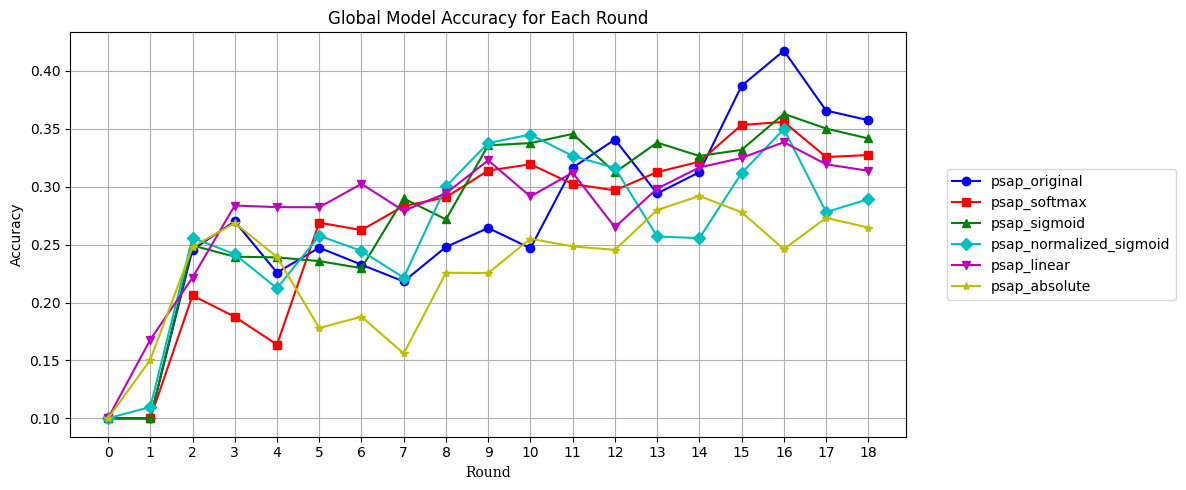

In [27]:
plot_accuracy_per_round(pseudo_gradient_similarity_avg_results)

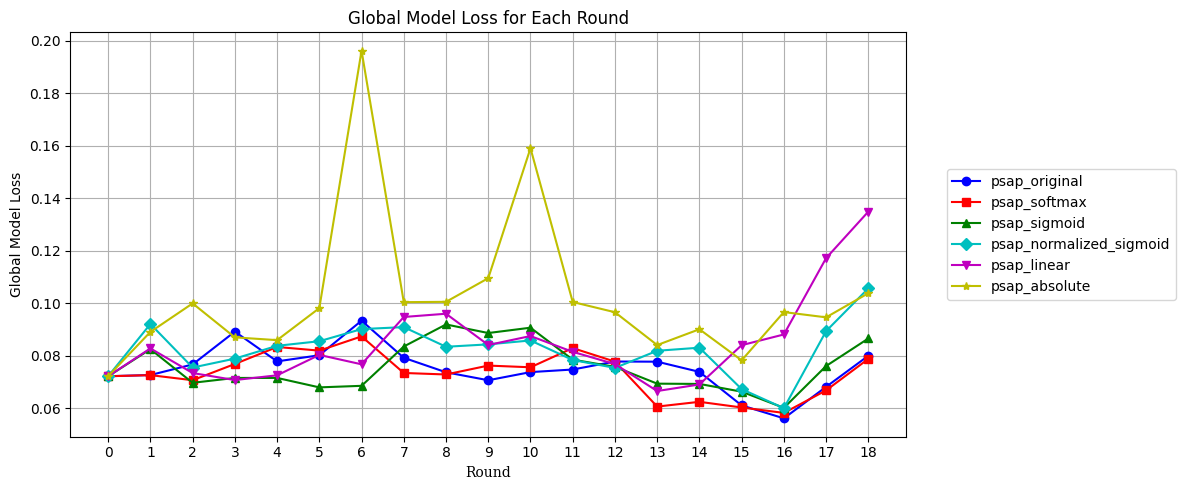

In [28]:
plot_loss_per_round(pseudo_gradient_similarity_avg_results)

### Parameter Differences Across Rounds













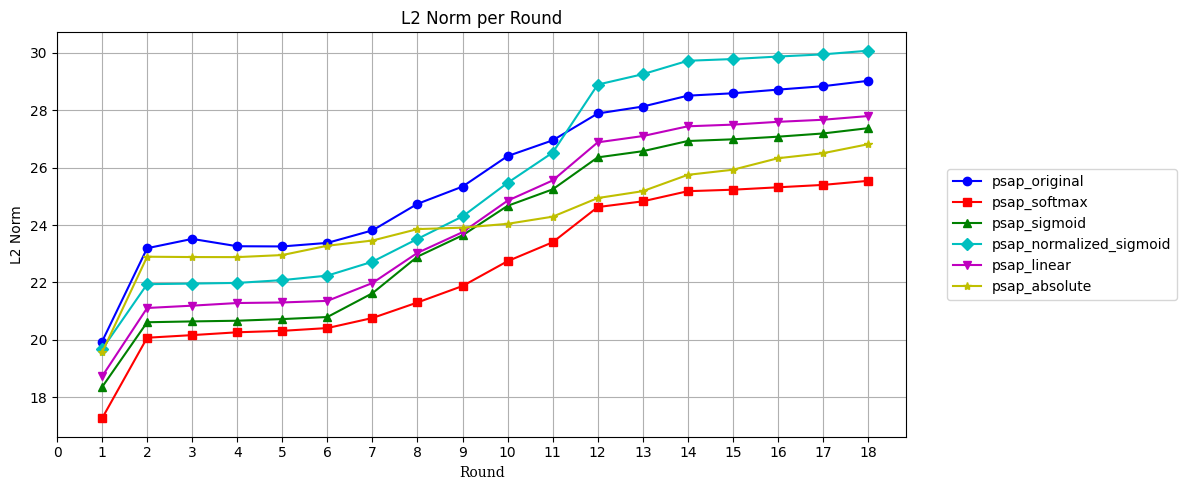

In [29]:
plot_l2_norm_per_round(pseudo_gradient_similarity_avg_results)

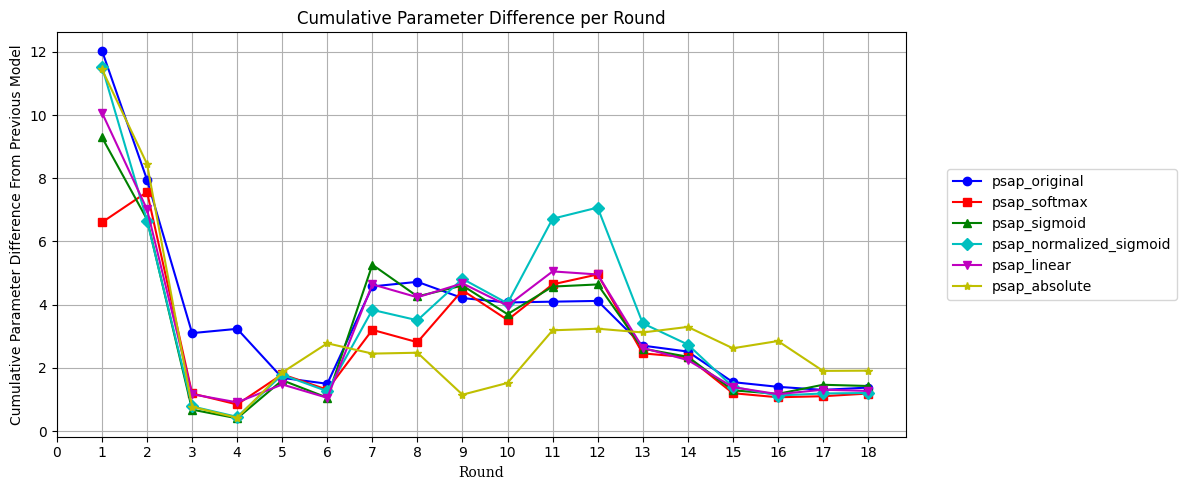

In [30]:
plot_parameter_difference_per_round(pseudo_gradient_similarity_avg_results)

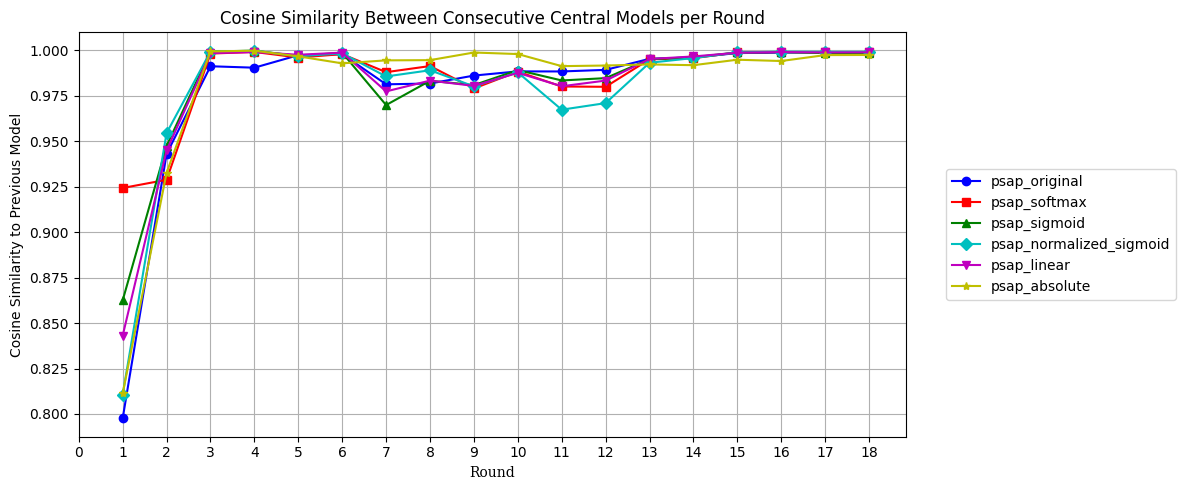

In [31]:
plot_cosine_similarity_per_round(pseudo_gradient_similarity_avg_results)

### Save the results to pickle files

In [77]:
pickle.dump(pseudo_gradient_similarity_avg_results, open(f"{experiment_type}_pseudogradient_similarity_avg.pkl", 'wb'))

all_results.update(pseudo_gradient_similarity_avg_results)

# Local Adam

## FedAvg with Local Adam

In [83]:
from src.LocalAdam.FedAvg.strategy import FedPartAdam
from src.LocalAdam.FedAvg.client import get_local_adam_fed_part_avg_client_fn

In [84]:
fedpart_local_adam_avg_client_fn = get_local_adam_fed_part_avg_client_fn(load_datasets)
client = ClientApp(client_fn=fedpart_local_adam_avg_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
fedpart_local_adam_avg_strategy= FedPartAdam(evaluate_fn=evaluate_fn)

def fedpart_local_adam_avg_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=fedpart_local_adam_avg_strategy,
    )

server = ServerApp(server_fn=fedpart_local_adam_avg_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


[DEBUG] Initialized parameters with 16 model parameters
[DEBUG] Model architecture: [(6, 3, 5, 5), (6,), (16, 6, 5, 5), (16,), (180, 400), (180,), (160, 180), (160,), (140, 160), (140,), (120, 140), (120,), (84, 120), (84,), (10, 84), (10,)]
  Evaluation results - Loss: 0.0722, Accuracy: 0.1000
(ClientAppActor pid=93804) [Client 2] initialized


(ClientAppActor pid=93804) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=93804)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=93804) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=93804) [DEBUG] Model patch length: 16
(ClientAppActor pid=93804) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=93804) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=93804) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=93804) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=93804) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=93804) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=93804) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=93804) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=93804) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=93804) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=93804) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=93804) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=93804) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=93804) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=93804) Layer 14 (fc7.weight) is trainable
(ClientAppActor pid=93804) L

(ClientAppActor pid=93803) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=93803)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]
(ClientAppActor pid=93803) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=93803) [Client 0] initialized
(ClientAppActor pid=93803) Epoch 8/8: train_loss 1.51626, accuracy 0.4016 [repeated 3x across cluster]
(ClientAppActor pid=93803) Local Adam training finished.
(ClientAppActor pid=93803) [Client 0] evaluate


(ClientAppActor pid=93801) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=93801) [DEBUG] Model patch length: 16
(ClientAppActor pid=93801) [Client 1] initialized [repeated 6x across cluster]
(ClientAppActor pid=93798) [Client 5] evaluate [repeated 5x across cluster]


(ClientAppActor pid=93801) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=93801)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=93800) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=93800) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=93800) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=93800) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=93800) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=93800) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=93800) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=93800) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=93800) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=93800) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=93800) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=93800) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=93800) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=93800) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=93800) Layer 14 (fc7.weight) is trainable
(ClientAppActor pid=93800) Layer 15 (fc7.bias) is trainable
(ClientAppActor pid=93800)

(ClientAppActor pid=93798) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=93801) Epoch 1/8: train_loss 1.93010, accuracy 0.2278
(ClientAppActor pid=93803) [DEBUG] Model patch length: 16 [repeated 5x across cluster]
(ClientAppActor pid=93803) [Client 3] initialized [repeated 5x across cluster]
(ClientAppActor pid=93803) Layer 15 (fc7.bias) is trainable [repeated 80x across cluster]
(ClientAppActor pid=93803) Starting explicit Local Adam training for 8 epochs... [repeated 5x across cluster]
(ClientAppActor pid=93800) Epoch 2/8: train_loss 1.70339, accuracy 0.3447 [repeated 7x across cluster]
(ClientAppActor pid=93802) Epoch 3/8: train_loss 1.52042, accuracy 0.4230 [repeated 8x across cluster]
(ClientAppActor pid=93801) Epoch 5/8: train_loss 1.41001, accuracy 0.4683 [repeated 9x across cluster]
(ClientAppActor pid=93802) Epoch 6/8: train_loss 1.21676, accuracy 0.5504 [repeated 9x across cluster]
(ClientAppActor pid=93801) Local Adam training finished.
(ClientAppActor pid=93801) Epoch 8/8: train_loss 1.12262, accuracy 0.5725 [repeated 9x acro

(ClientAppActor pid=93800) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.
(ClientAppActor pid=93803) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=93803)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


total size: 22345608
  Evaluation results - Loss: 0.0507, Accuracy: 0.3949
(ClientAppActor pid=93801) [Client 3] initialized
(ClientAppActor pid=93801) [Client 3] evaluate
(ClientAppActor pid=93803) Local Adam training finished. [repeated 5x across cluster]
(ClientAppActor pid=93803) Epoch 8/8: train_loss 1.17805, accuracy 0.5567 [repeated 5x across cluster]


(ClientAppActor pid=93802) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.
(ClientAppActor pid=93801) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=93801)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=93798) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=93798)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=93802) [DEBUG] Model patch length: 16
(ClientAppActor pid=93802) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=93802) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=93802) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93802) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93802) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93802) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93802) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93802) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93802) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93802) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93802) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93802) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=93802) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=93802) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=93802) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=93802) Layer 15 (fc7.bias) is frozen
(ClientApp

(ClientAppActor pid=93800) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=93800)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=93801) [DEBUG] Model patch length: 6
(ClientAppActor pid=93801) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=93801) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=93801) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93801) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93801) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93801) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93801) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93801) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93801) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93801) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93801) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93801) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=93801) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=93801) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=93801) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=93801) Layer 15 (fc7.bias) is frozen
(ClientAppA

(ClientAppActor pid=93802) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93802)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93804) [DEBUG] Model patch length: 6
(ClientAppActor pid=93802) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93802) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93802) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=93802) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=93802) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93802) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93802) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93802) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93802) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93802) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93802) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93802) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=93802) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=93802) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=93802) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=93802) Layer 15 (fc7.bias) is frozen
(ClientAppA

(ClientAppActor pid=93800) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93800)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93798) Local Adam training finished. [repeated 5x across cluster]
(ClientAppActor pid=93802) [DEBUG] Model patch length: 6
(ClientAppActor pid=93802) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93802) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93802) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=93802) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=93802) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93802) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93802) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93802) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93802) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93802) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93802) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93802) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=93802) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=93802) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=93802) Layer 14 (fc7.

(ClientAppActor pid=93801) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=93801)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=93802) Epoch 1/8: train_loss 1.40443, accuracy 0.4833
(ClientAppActor pid=93801) [DEBUG] Model patch length: 6 [repeated 5x across cluster]
(ClientAppActor pid=93801) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=93801) Layer 3 (conv2.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=93801) Starting explicit Local Adam training for 8 epochs... [repeated 5x across cluster]
(ClientAppActor pid=93804) Epoch 3/8: train_loss 1.45418, accuracy 0.4719 [repeated 16x across cluster]
(ClientAppActor pid=93802) Epoch 6/8: train_loss 1.36903, accuracy 0.4958 [repeated 14x across cluster]
(ClientAppActor pid=93802) Local Adam training finished.
total size: 11259804
  Evaluation results - Loss: 0.0474, Accuracy: 0.4498
(ClientAppActor pid=93800) [Client 2] initialized
(ClientAppActor pid=93800) [Client 2] evaluate
(ClientAppActor pid=93801) Epoch 8/8: train_loss 1.43178, accuracy 0.4644 [repeated 17x across cluster]
(ClientAppA

(ClientAppActor pid=93800) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=93800)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=93803) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=93803)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=93798) [DEBUG] Model patch length: 6
(ClientAppActor pid=93798) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93798) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93798) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93798) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93798) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=93798) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=93798) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93798) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93798) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93798) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93798) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93798) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=93798) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=93798) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=93798) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=93798) Layer 15 (fc7.bias) is frozen
(ClientAppA

(ClientAppActor pid=93802) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=93802)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=93801) Local Adam training finished. [repeated 5x across cluster]
(ClientAppActor pid=93802) [DEBUG] Model patch length: 6
(ClientAppActor pid=93800) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93800) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93800) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93800) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93800) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=93800) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=93800) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93800) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93800) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93800) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93800) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93800) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=93800) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=93800) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=93800) Layer 14 (fc7.

(ClientAppActor pid=93803) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93803)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93803) [Client 5] initialized
(ClientAppActor pid=93803) [Client 5] evaluate
(ClientAppActor pid=93804) Epoch 8/8: train_loss 0.87144, accuracy 0.6993 [repeated 17x across cluster]
(ClientAppActor pid=93804) Local Adam training finished. [repeated 5x across cluster]
(ClientAppActor pid=93800) [DEBUG] Model patch length: 6
(ClientAppActor pid=93800) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93800) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93800) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93800) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93800) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93800) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93800) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=93800) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=93800) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93800) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93800) Layer 10 (fc4.weight) is frozen
(ClientAppAct

(ClientAppActor pid=93803) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93803)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93803) [Client 2] initialized
(ClientAppActor pid=93803) [Client 2] evaluate
(ClientAppActor pid=93804) Epoch 8/8: train_loss 1.07510, accuracy 0.6156 [repeated 11x across cluster]
(ClientAppActor pid=93804) Local Adam training finished. [repeated 5x across cluster]
(ClientAppActor pid=93804) [DEBUG] Model patch length: 6
(ClientAppActor pid=93804) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93804) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93804) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93804) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93804) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93804) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93804) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=93804) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=93804) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93804) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93804) Layer 10 (fc4.weight) is frozen
(ClientAppAct

(ClientAppActor pid=93802) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93802)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93800) [DEBUG] Model patch length: 6
(ClientAppActor pid=93800) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93800) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93800) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93800) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93800) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93800) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93800) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93800) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93800) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=93800) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=93800) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93800) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=93800) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=93800) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=93800) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=93800) Layer 15 (fc7.bias) is frozen
(ClientAppA

(ClientAppActor pid=93803) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93803)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93800) [Client 5] initialized
(ClientAppActor pid=93800) [Client 5] evaluate
(ClientAppActor pid=93801) Epoch 8/8: train_loss 1.03229, accuracy 0.6227 [repeated 11x across cluster]
(ClientAppActor pid=93801) Local Adam training finished. [repeated 5x across cluster]
(ClientAppActor pid=93802) [DEBUG] Model patch length: 6
(ClientAppActor pid=93802) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93802) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93802) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93802) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93802) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93802) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93802) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93802) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93802) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=93802) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=93802) Layer 10 (fc4.weight) is frozen
(ClientAppAct

(ClientAppActor pid=93802) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93802)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93798) Local Adam training finished. [repeated 5x across cluster]
(ClientAppActor pid=93802) [DEBUG] Model patch length: 6
(ClientAppActor pid=93802) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93802) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93802) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93802) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93802) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93802) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93802) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93802) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93802) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93802) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93802) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=93802) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=93802) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=93802) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=93802) Layer 14 (fc7.

(ClientAppActor pid=93802) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93802)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93803) [Client 2] initialized
(ClientAppActor pid=93803) [Client 2] evaluate
(ClientAppActor pid=93800) Epoch 8/8: train_loss 1.04509, accuracy 0.6170 [repeated 11x across cluster]
(ClientAppActor pid=93800) Local Adam training finished. [repeated 5x across cluster]
(ClientAppActor pid=93803) [DEBUG] Model patch length: 6
(ClientAppActor pid=93803) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93803) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93803) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93803) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93803) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93803) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93803) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93803) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93803) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93803) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93803) Layer 10 (fc4.weight) is trainable
(ClientAppActor 

(ClientAppActor pid=93802) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93802)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93801) Local Adam training finished. [repeated 5x across cluster]
(ClientAppActor pid=93801) Epoch 8/8: train_loss 1.11823, accuracy 0.5861 [repeated 5x across cluster]
(ClientAppActor pid=93801) [DEBUG] Model patch length: 6
(ClientAppActor pid=93801) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93801) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93801) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93801) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93801) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93801) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93801) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93801) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93801) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93801) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93801) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93801) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=93801) Layer 12 (fc5.weight) is trainabl

(ClientAppActor pid=93802) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93802)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93801) [DEBUG] Model patch length: 6
(ClientAppActor pid=93801) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93801) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93801) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93801) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93801) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93801) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93801) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93801) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93801) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93801) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93801) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93801) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=93801) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=93801) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=93801) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=93801) Layer 15 (fc7.bias) is frozen
(ClientAppA

(ClientAppActor pid=93802) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93802)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93802) Local Adam training finished. [repeated 5x across cluster]
(ClientAppActor pid=93802) Epoch 8/8: train_loss 1.11461, accuracy 0.5943 [repeated 5x across cluster]
(ClientAppActor pid=93804) [DEBUG] Model patch length: 6
(ClientAppActor pid=93804) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93804) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93804) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93804) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93804) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93804) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93804) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93804) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93804) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93804) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93804) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93804) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=93804) Layer 12 (fc5.weight) is frozen
(

(ClientAppActor pid=93800) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93800)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93804) [DEBUG] Model patch length: 6
(ClientAppActor pid=93804) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93804) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93804) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93804) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93804) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93804) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93804) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93804) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93804) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93804) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93804) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93804) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=93804) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=93804) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=93804) Layer 14 (fc7.weight) is trainable
(ClientAppActor pid=93804) Layer 15 (fc7.bias) is trainable
(ClientAppA

(ClientAppActor pid=93798) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93798)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93804) [Client 5] initialized
(ClientAppActor pid=93804) [Client 5] evaluate
(ClientAppActor pid=93801) Epoch 8/8: train_loss 1.11709, accuracy 0.5982 [repeated 11x across cluster]
(ClientAppActor pid=93801) Local Adam training finished. [repeated 5x across cluster]
(ClientAppActor pid=93800) [Client 0] initialized [repeated 5x across cluster]
(ClientAppActor pid=93800) [Client 0] evaluate [repeated 5x across cluster]


(ClientAppActor pid=93800) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=93800)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [85]:
fedpart_local_adam_avg_results=fedpart_local_adam_avg_strategy.get_results()
local_adam_results['fedpart_local_adam_avg'] = fedpart_local_adam_avg_results

## Summary

Compared to the other momentum based strategies we can see a similar sharply fluctuating behaviour in the accuracy and loss values which shows that using momentum, regardless of the weighting mechanism, can hinder the learning process in an extremely data heterogeneous setting due to the contrasting optimiser states. However, compared to the other momentum based approaches, using local adam we can see a steady and consistent increase in the L2 norm values as well as less drastic differences when it comes to the parameter differences between consecutive central models and their cosine similarity. Considering local adam as a part of a decompositional analysis of the momentum based strategies, this confirms that amplified difference and dissimilarity between consecutive models and hence their effect on learning performance caused by the use of cosine similarity weighting, especially in the early rounds after which FedPart can not recover from using layer-wise updates.

### Accuracy and Loss per Round

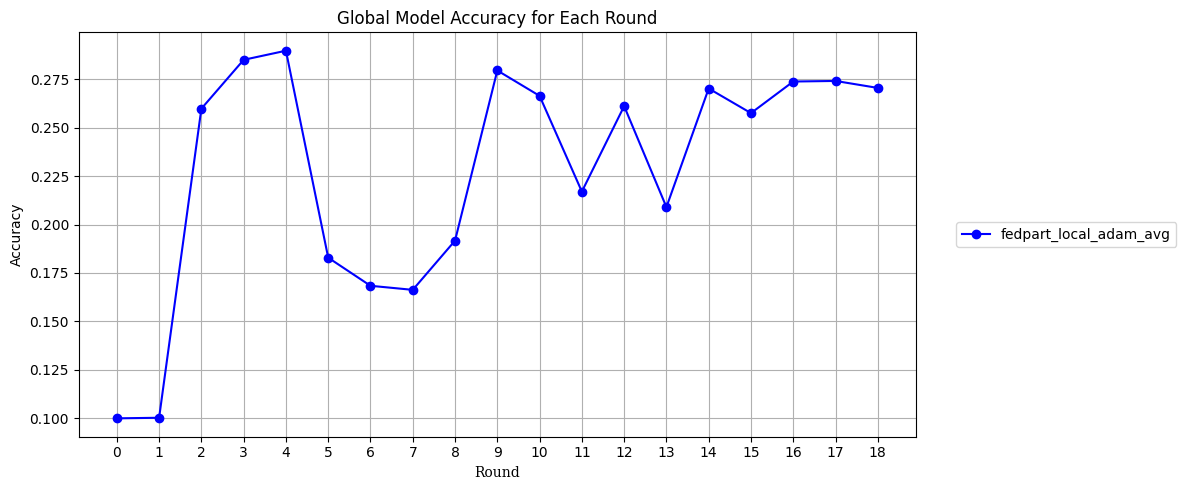

In [32]:
plot_accuracy_per_round(local_adam_results)

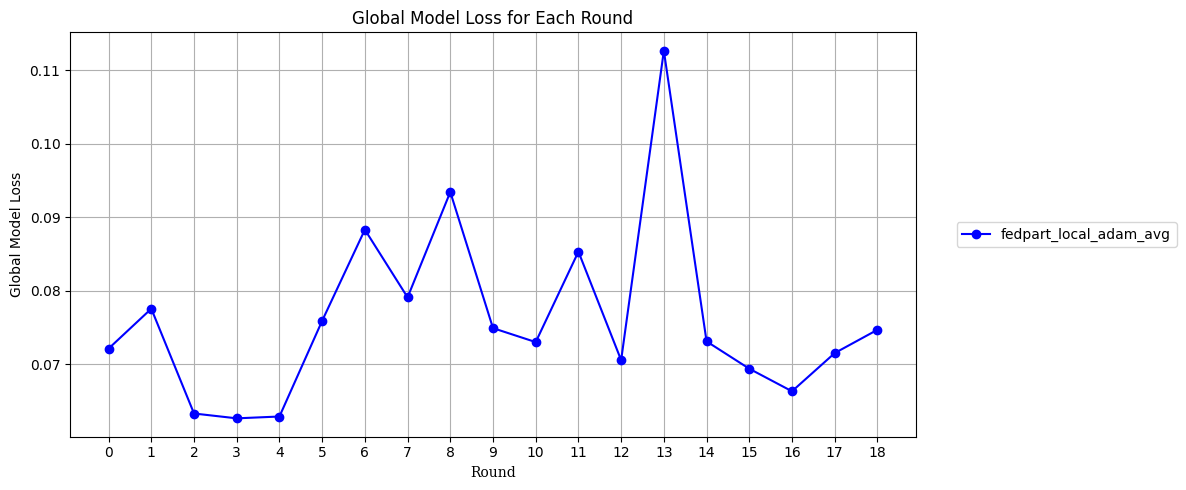

In [33]:
plot_loss_per_round(local_adam_results)

### Parameter Differences Across Rounds













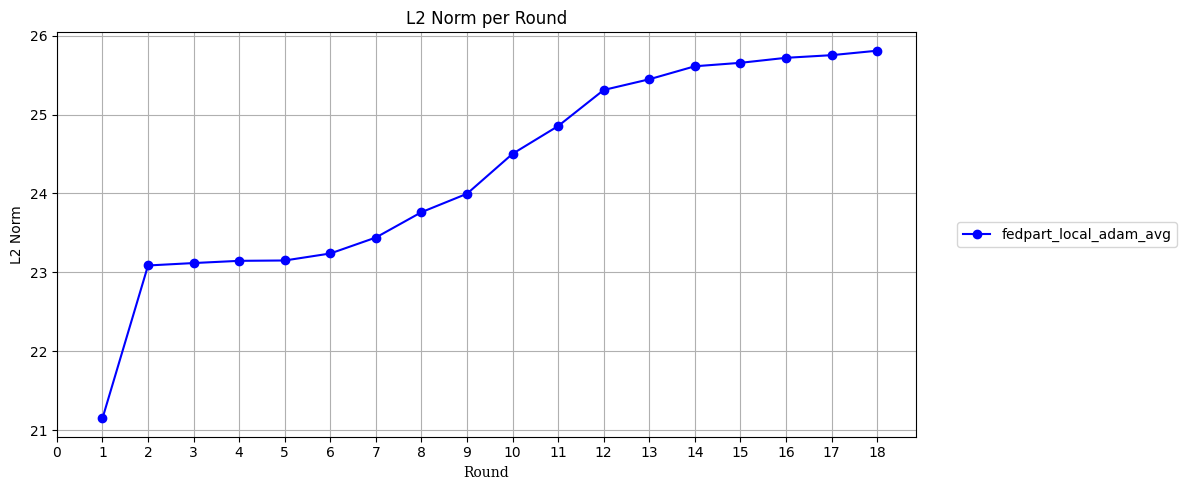

In [34]:
plot_l2_norm_per_round(local_adam_results)

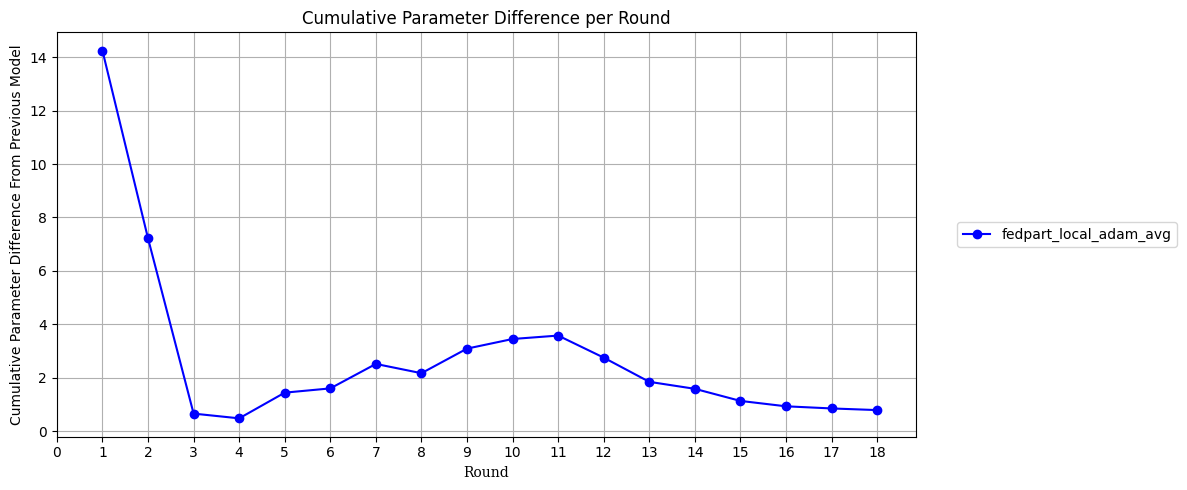

In [35]:
plot_parameter_difference_per_round(local_adam_results)

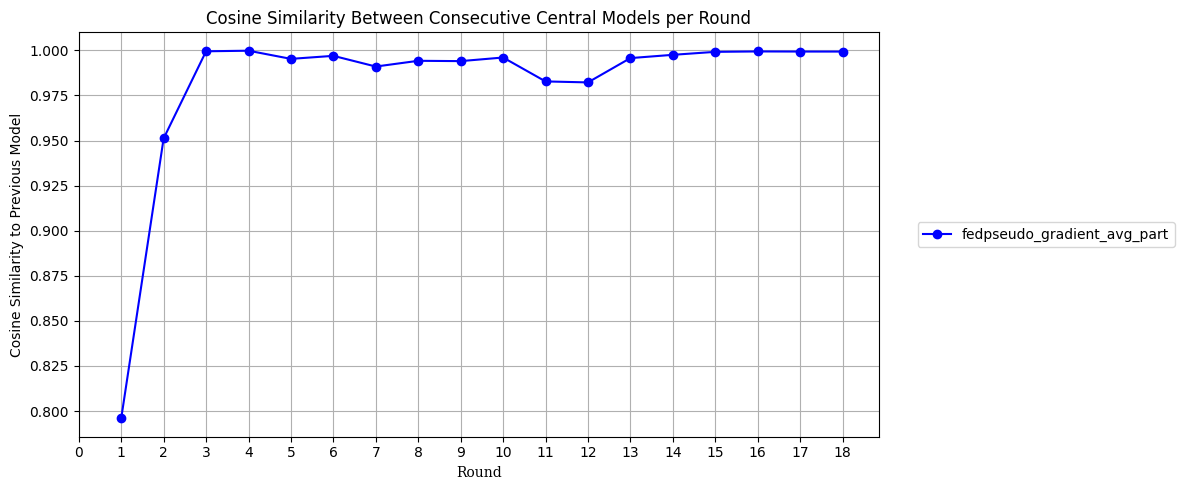

In [36]:
plot_cosine_similarity_per_round(pseudo_gradient_results)

### Save the results to pickle files

In [59]:
pickle.dump(local_adam_results, open(f"{experiment_type}_local_adam_results.pkl", 'wb'))
all_results.update(local_adam_results)

# Analysis 

In this section we compare and contrast the best performing strategy variants selected from the previous experiments. Based on the best accuracy score achieved we select the weighting variant of the strategy (if there are multiple) and compare it to the other strategies. The selected strategies are:

- FedAvg (fedavg)
- FedPartAvg (fedpartavg)
- FedAvgMom1 using softmax weighting (fedavg_mom1_softmax)
- FedAvgMom2 using sigmoid weighting (fedavg_mom2_sigmoid)
- Local Adam in FedPart using FedAvg (fedpart_local_adam_avg)
- PseudoGradient Avg Update (fedpseudo_gradient_avg_part)
- PseudoGradient Similarity Part Avg original weighting (psap_original)









In [38]:
analysis_results = {}
for key, value in all_results["baseline"].items():
    analysis_results[key] = value

analysis_results["fedavg_mom2_softmax"] = fedavg_mom2_results["fedavg_mom2_softmax"]
analysis_results["fedavg_mom1_sigmoid"] = fedavg_mom1_results["fedavg_mom1_sigmoid"]
analysis_results["fedpseudo_gradient_avg_part"]= pseudo_gradient_results["fedpseudo_gradient_avg_part"]
analysis_results["psap_original"] = pseudo_gradient_similarity_avg_results["psap_original"]
analysis_results["fedpart_local_adam_avg"] = local_adam_results["fedpart_local_adam_avg"]



As shown on the per round accuracy plot we can see that FedAvg can still outperform all the other strategies due to its ability aggregate and share all layer parameters in every round. However, we can see that the pseudo-gradient based similarity strategy using the original weighting mechanism is able to produce really close result to FedAVg, in fact in round 16 it is capable outperforming it, showing potential for further improvement. Furthermore, although we discussed the negative effect of cosine similarity based weighting and aggregation of momentum from clients, we can see that both of our best performing momentum based strategies were able to outperform the simply local adam based FedPart strategy, presenting a small benefit of using cosine similarity based weighting for momentum. Lastly, it is important to mention that the average pseudo-gradient based strategy was able to out perform all momentum based ones which highlights the stable nature of using pseudo-gradient compared to momentum states in layer-wise training strategies.

When it comes to the loss plot of the various strategies we can see that all of the FedPart based strategies have an amplified and fluctuating loss curve which shows the difficulty of layer-wise updates as the parameters are less synchronised compared to full-layer updates. With more initial warm up (full layer update) rounds, this problem could be mitigated or decreased as clients would be more in-sync before layer-wise training could start. which could also potentially decrease parameter and cosine similarity differences between consecutive central models hence decrease the fluctuation in the training process.














## Accuracy and Loss Comparison

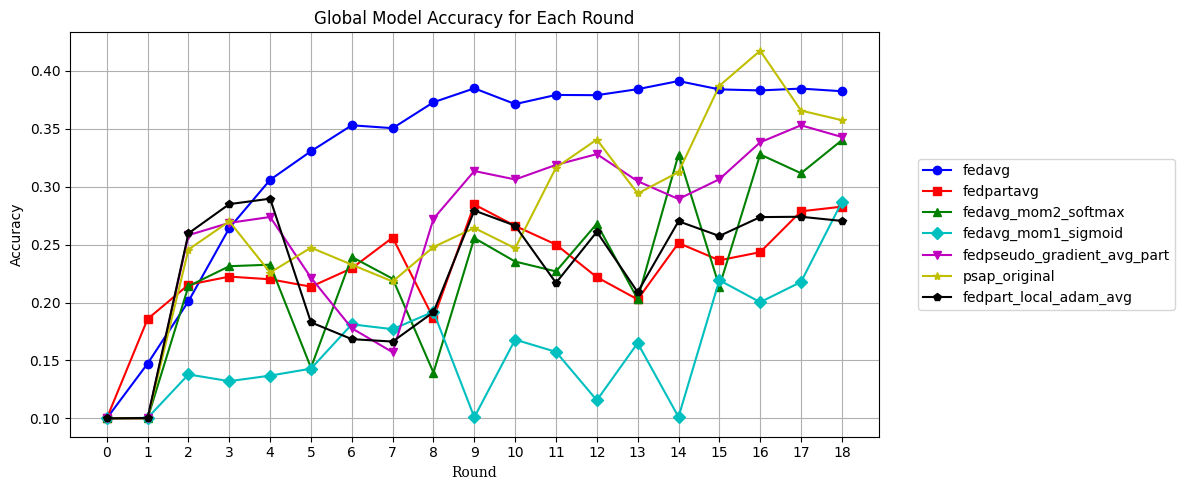

In [39]:
plot_accuracy_per_round(analysis_results)

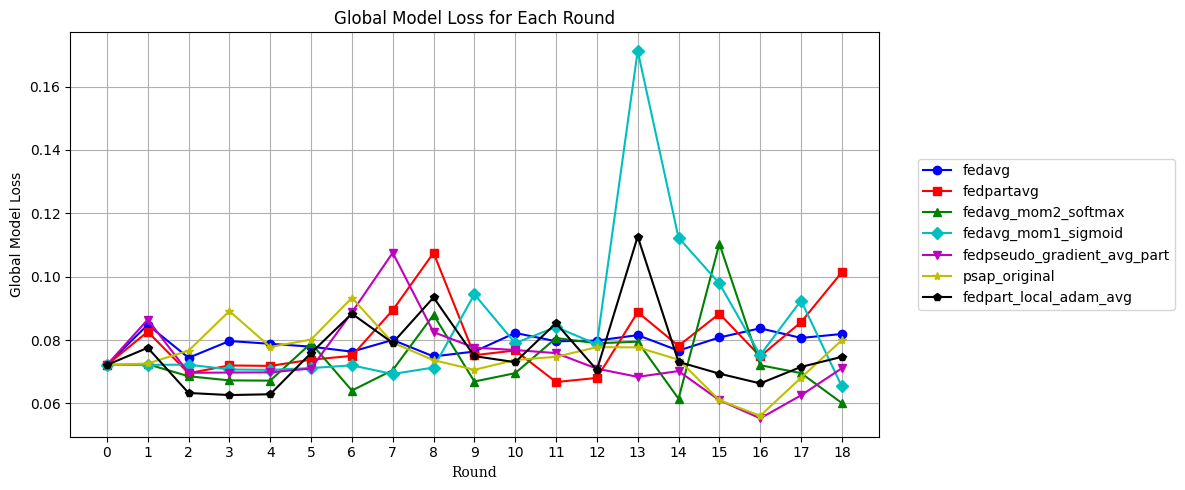

In [40]:
plot_loss_per_round(analysis_results)

## Parameter Differences 

Regarding the parameter and L2 norm differences we can see a similar relationship between FedAvg and the FedPart based strategies as we saw in the "Ideal Setting" experiments. However, we can see that the L2 norm values are slightly increased in the FedPart based strategies compared to the FedAvg strategy as well as we can see more amplified fluctuation between parameter differences between consecutive central models but the their general trend is similar.
















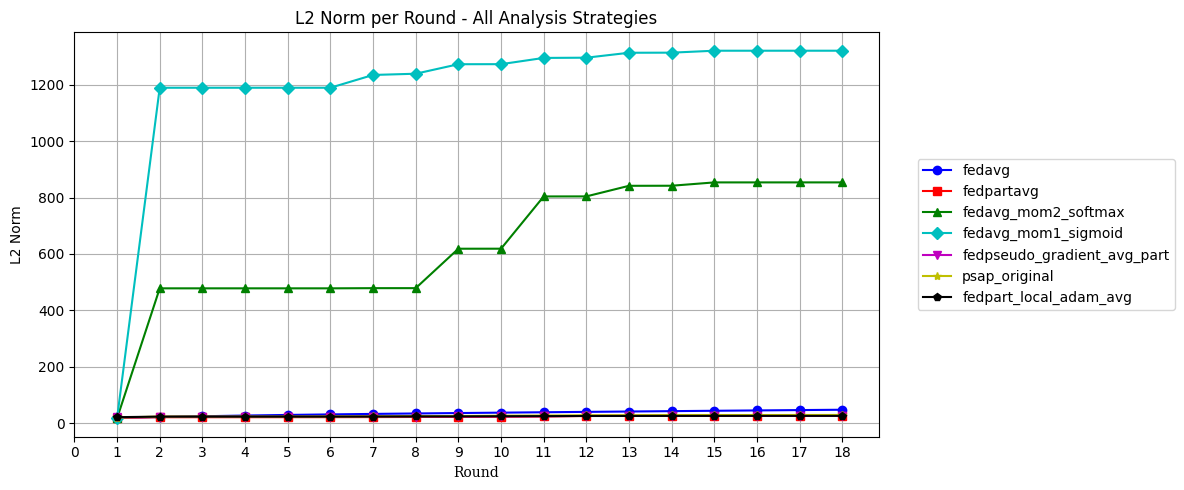

In [41]:
plot_l2_norm_per_round(analysis_results, modified_label="All Analysis Strategies")

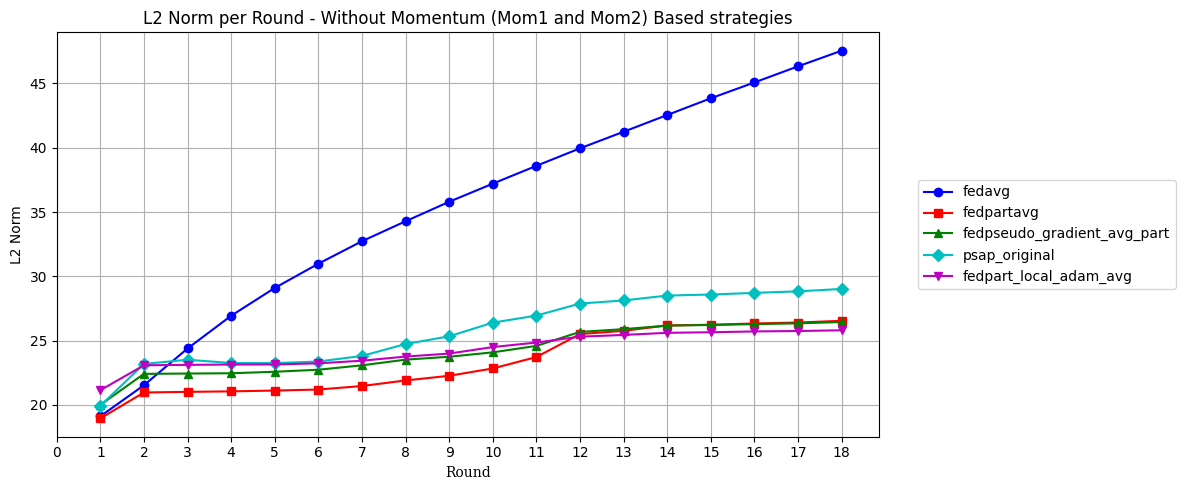

In [42]:
analysis_results_without_momentums = analysis_results.copy()

analysis_results_without_momentums.pop('fedavg_mom2_softmax')
analysis_results_without_momentums.pop('fedavg_mom1_sigmoid')

plot_l2_norm_per_round(analysis_results_without_momentums, modified_label="Without Momentum (Mom1 and Mom2) Based strategies")

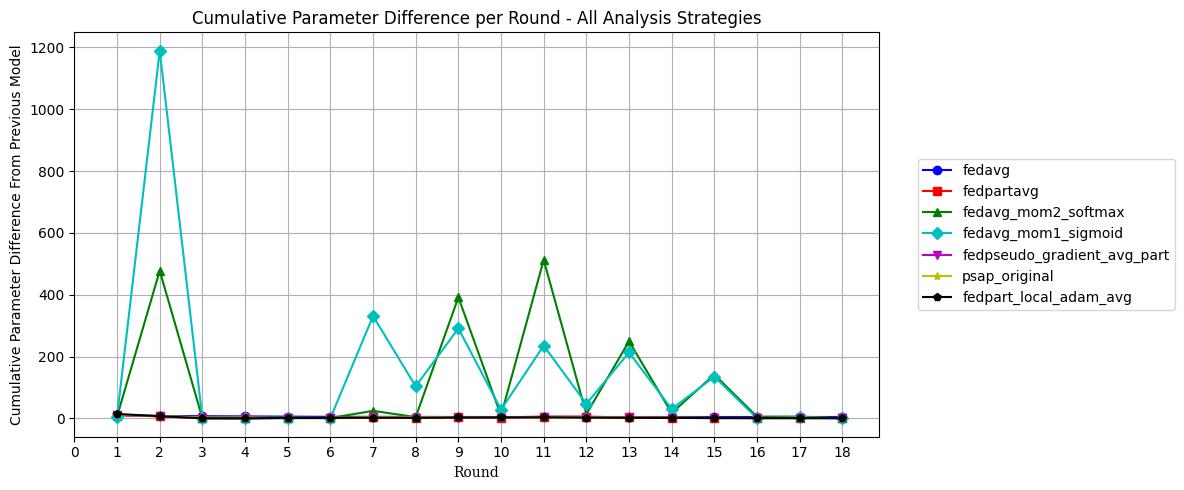

In [43]:
plot_parameter_difference_per_round(analysis_results, modified_label="All Analysis Strategies")

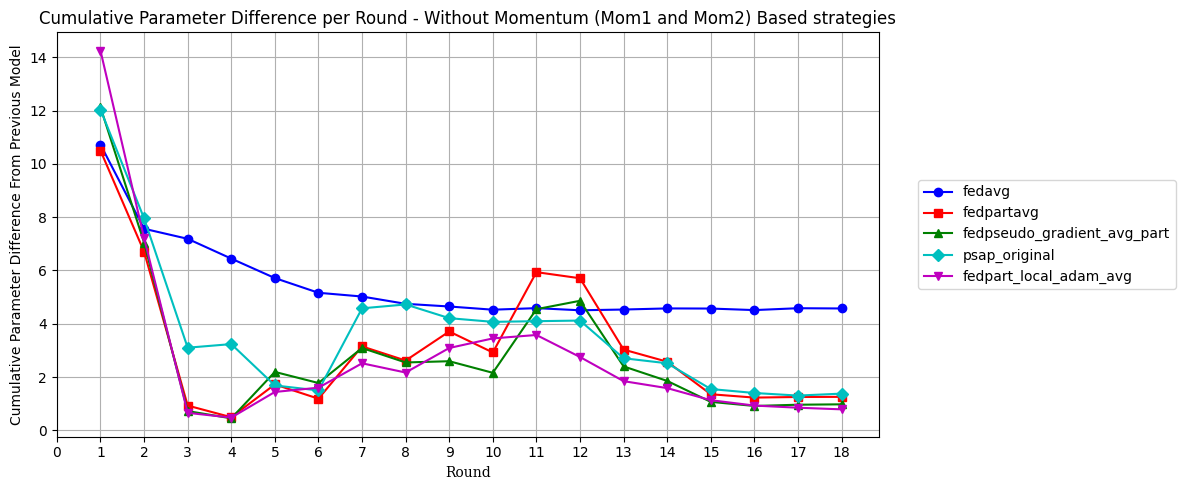

In [44]:
plot_parameter_difference_per_round(analysis_results_without_momentums, modified_label="Without Momentum (Mom1 and Mom2) Based strategies")